# Zika Virus round 3 with 40 more datasets

In [ ]:
while read p; do
echo "$p" 

prefetch $p --max-size u -O /drive/8nextflow3/
fasterq-dump -p /drive/8nextflow3/$p -e 4
pigz -0 -p4 $p*

rm -r "$p"

done < acc.txt

# Nextflow

In [ ]:
nextflow run \
    nf-core/rnaseq \
    --input Homo_sapiens_paired.csv \
    --outdir Homo_sapiens_paired_results/ \
    --gtf /drive/Homo_sapiens_genome_indexed/Homo_sapiens.GRCh38.112.gtf \
    --fasta /drive/Homo_sapiens_genome_indexed/Homo_sapiens.GRCh38.dna.toplevel.fa \
    --igenomes_ignore \
    --genome null \
    -profile docker \
    --max_memory 31.GB \
    --max_cpus 8 \
    --aligner hisat2 \
    --save_trimmed \
    --rseqc_modules infer_experiment,read_distribution \
    --skip_markduplicates \
    --skip_bigwig \
    --skip_stringtie \
    --skip_dupradar \
    --skip_biotype_qc \
    --skip_deseq2_qc \
    --hisat2_index /drive/Homo_sapiens_genome_indexed/index/hisat2/ \
    --salmon_index /drive/Homo_sapiens_genome_indexed/index/salmon/ \
    --rsem_index /drive/Homo_sapiens_genome_indexed/rsem/ \
    --splicesites /drive/Homo_sapiens_genome_indexed/index/Homo_sapiens.GRCh38.dna.toplevel.filtered.splice_sites.txt \
    --gene_bed /drive/Homo_sapiens_genome_indexed/Homo_sapiens.GRCh38.dna.toplevel.filtered.bed \
    --transcript_fasta /drive/Homo_sapiens_genome_indexed/genome.transcripts.fa 

rm -r work

# Expression

In [1]:
cd /mnt
mkdir Zika_round4
cd Zika_round4
mkdir virus_ref

cp /mnt/Zika_virus_expression/virus_ref/Zika_brazil.fasta virus_ref/
cd virus_ref

In [4]:
bowtie2-build -f Zika_brazil.fasta Zika_brazil

Settings:
  Output files: "Zika_brazil.*.bt2"
  Line rate: 6 (line is 64 bytes)
  Lines per side: 1 (side is 64 bytes)
  Offset rate: 4 (one in 16)
  FTable chars: 10
  Strings: unpacked
  Max bucket size: default
  Max bucket size, sqrt multiplier: default
  Max bucket size, len divisor: 4
  Difference-cover sample period: 1024
  Endianness: little
  Actual local endianness: little
  Sanity checking: disabled
  Assertions: disabled
  Random seed: 0
  Sizeofs: void*:8, int:4, long:8, size_t:8
Input files DNA, FASTA:
  Zika_brazil.fasta
Building a SMALL index
Reading reference sizes
  Time reading reference sizes: 00:00:00
Calculating joined length
Writing header
Reserving space for joined string
Joining reference sequences
  Time to join reference sequences: 00:00:00
bmax according to bmaxDivN setting: 2702
Using parameters --bmax 2027 --dcv 1024
  Doing ahead-of-time memory usage test
  Passed!  Constructing with these parameters: --bmax 2027 --dcv 1024
Constructing suffix-array eleme

In [5]:
cd ..

In [6]:
tail -n +2 /drive/9nextflow4/Homo_sapiens_paired.csv | cut -d',' -f1 > Homo_sapiens_paired.txt

In [ ]:
Virus=Zika_brazil

while read p; do
echo $p

pigz -k -dc -p4 /drive/9nextflow4/Homo_sapiens_paired_results/trimgalore/$p"_1_val_1.fq.gz" > $p"_1.fastq"
pigz -k -dc -p4 /drive/9nextflow4/Homo_sapiens_paired_results/trimgalore/$p"_2_val_2.fq.gz" > $p"_2.fastq"

time bowtie2 --local --very-sensitive-local --threads 8 -k 10 -x virus_ref/$Virus -1 $p"_1.fastq" -2 $p"_2.fastq" -S  $Virus"_"$p

rm $p"_1.fastq"
rm $p"_2.fastq"

samtools view -S -b -@ 8 -F 260 $Virus"_"$p > $Virus"_"$p".bam"

rm $Virus"_"$p

samtools sort -@ 8 $Virus"_"$p".bam" > $Virus"_"$p"_sorted.bam"

rm $Virus"_"$p".bam"

samtools index $Virus"_"$p"_sorted.bam"

done < Homo_sapiens_paired.txt

# Subgenomic Plotting

In [12]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import matplotlib.gridspec as gridspec

In [2]:
# Function to read numbers from a file and return them as a list
def read_acc_from_file(file_path):
    acc = []
    with open(file_path, 'r') as file:
        for line in file:
            # Strip the newline character and convert the line to an integer
            accession = str(line.strip())
            acc.append(accession)
    return acc

# Example usage
file_path = '/mnt/Zika_round4/Homo_sapiens_paired.txt'  # Replace with the path to your file
acc_list = read_acc_from_file(file_path)

print(acc_list)

['SRR9106108', 'SRR9106110', 'SRR9106112', 'SRR9106114', 'SRR9106116', 'SRR9106118', 'SRR9106120', 'SRR9106122', 'SRR9106124', 'SRR9106126', 'SRR9106128', 'SRR9106130', 'SRR9106132', 'SRR9106134', 'SRR9106136', 'SRR9106138', 'SRR9106140', 'SRR9106142', 'SRR9106144', 'SRR9106146']


Virus Coverage Plot Calculation

In [5]:
%cd /mnt/Zika_round4

/mnt/Zika_round4


In [4]:
!mkdir plotting
!mkdir plotting/original_depth

In [ ]:
while read p; do
echo $p

samtools depth -aa *$p"_sorted.bam" > plotting/original_depth/$p".tsv"

done < Homo_sapiens_paired.txt

## Antisense sense read seperation

In [2]:
!mkdir infer_exp/

In [3]:
!cp /drive/9nextflow4/Homo_sapiens_paired_results/hisat2/rseqc/infer_experiment/*".infer_experiment.txt" infer_exp/

In [4]:
!mkdir bam_read_seperation/

In [ ]:
single() {
  if (( $(echo "$strand_one > $strand_two" | bc -l) )); then
    echo "strand_one: $strand_one"
    echo "strand_two: $strand_two"
    echo "++,--"
    samtools view -@ 8 -b -F 0x10 bam_read_seperation/$p"_filtered.bam" > bam_read_seperation/$p"_sense.bam"
    samtools view -@ 8 -b -f 0x10 bam_read_seperation/$p"_filtered.bam" > bam_read_seperation/$p"_antisense.bam"

    samtools sort -@ 8 bam_read_seperation/$p"_sense.bam" > bam_read_seperation/$p"_sense_sorted.bam"
    samtools sort -@ 8 bam_read_seperation/$p"_antisense.bam" > bam_read_seperation/$p"_antisense_sorted.bam"

    rm bam_read_seperation/$p"_filtered.bam"
    rm bam_read_seperation/$p"_sense.bam"
    rm bam_read_seperation/$p"_antisense.bam"
    
  else
    echo "strand_one: $strand_one"
    echo "strand_two: $strand_two"
    echo "+-,-+"
    samtools view -@ 8 -b -F 0x10 bam_read_seperation/$p"_filtered.bam" > bam_read_seperation/$p"_antisense.bam"
    samtools view -@ 8 -b -f 0x10 bam_read_seperation/$p"_filtered.bam" > bam_read_seperation/$p"_sense.bam"

    samtools sort -@ 8 bam_read_seperation/$p"_sense.bam" > bam_read_seperation/$p"_sense_sorted.bam"
    samtools sort -@ 8 bam_read_seperation/$p"_antisense.bam" > bam_read_seperation/$p"_antisense_sorted.bam"

    rm bam_read_seperation/$p"_filtered.bam"
    rm bam_read_seperation/$p"_sense.bam"
    rm bam_read_seperation/$p"_antisense.bam"

  fi
}

In [ ]:
paired() {
  if (( $(echo "$strand_one > $strand_two" | bc -l) )); then
    echo "strand_one: $strand_one"
    echo "strand_two: $strand_two"
    echo "1++,1--,2+-,2-+"
    samtools view -@ 8 -b -f 0x40 -F 0x10 bam_read_seperation/$p"_filtered.bam" > bam_read_seperation/$p"_sense_read1.bam"

    samtools view -@ 8 -b -f 0x40 -f 0x10 bam_read_seperation/$p"_filtered.bam" > bam_read_seperation/$p"_antisense_read1.bam"

    samtools view -@ 8 -b -f 0x80 -F 0x10 bam_read_seperation/$p"_filtered.bam" > bam_read_seperation/$p"_antisense_read2.bam"

    samtools view -@ 8 -b -f 0x80 -f 0x10 bam_read_seperation/$p"_filtered.bam" > bam_read_seperation/$p"_sense_read2.bam"

    samtools cat -o bam_read_seperation/$p"_sense.bam" bam_read_seperation/$p"_sense_read1.bam" bam_read_seperation/$p"_sense_read2.bam"
    samtools cat -o bam_read_seperation/$p"_antisense.bam" bam_read_seperation/$p"_antisense_read1.bam" bam_read_seperation/$p"_antisense_read2.bam"

    samtools sort -@ 8 bam_read_seperation/$p"_sense.bam" > bam_read_seperation/$p"_sense_sorted.bam"
    samtools sort -@ 8 bam_read_seperation/$p"_antisense.bam" > bam_read_seperation/$p"_antisense_sorted.bam"


    rm bam_read_seperation/$p"_sense.bam"
    rm bam_read_seperation/$p"_antisense.bam"
    rm bam_read_seperation/$p"_filtered.bam"
    rm bam_read_seperation/$p"_sense_read1.bam"
    rm bam_read_seperation/$p"_sense_read2.bam"
    rm bam_read_seperation/$p"_antisense_read1.bam"
    rm bam_read_seperation/$p"_antisense_read2.bam"

  else
    echo "strand_one: $strand_one"
    echo "strand_two: $strand_two"
    echo "1+-,1-+,2++,2--"

    samtools view -@ 8 -b -f 0x40 -F 0x10 bam_read_seperation/$p"_filtered.bam" > bam_read_seperation/$p"_antisense_read1.bam"

    samtools view -@ 8 -b -f 0x40 -f 0x10 bam_read_seperation/$p"_filtered.bam" > bam_read_seperation/$p"_sense_read1.bam"

    samtools view -@ 8 -b -f 0x80 -F 0x10 bam_read_seperation/$p"_filtered.bam" > bam_read_seperation/$p"_sense_read2.bam"

    samtools view -@ 8 -b -f 0x80 -f 0x10 bam_read_seperation/$p"_filtered.bam" > bam_read_seperation/$p"_antisense_read2.bam"

    samtools cat -o bam_read_seperation/$p"_sense.bam" bam_read_seperation/$p"_sense_read1.bam" bam_read_seperation/$p"_sense_read2.bam"
    samtools cat -o bam_read_seperation/$p"_antisense.bam" bam_read_seperation/$p"_antisense_read1.bam" bam_read_seperation/$p"_antisense_read2.bam"

    samtools sort -@ 8 bam_read_seperation/$p"_sense.bam" > bam_read_seperation/$p"_sense_sorted.bam"
    samtools sort -@ 8 bam_read_seperation/$p"_antisense.bam" > bam_read_seperation/$p"_antisense_sorted.bam"

    rm bam_read_seperation/$p"_sense.bam"
    rm bam_read_seperation/$p"_antisense.bam"
    rm bam_read_seperation/$p"_filtered.bam"
    rm bam_read_seperation/$p"_sense_read1.bam"
    rm bam_read_seperation/$p"_sense_read2.bam"
    rm bam_read_seperation/$p"_antisense_read1.bam"
    rm bam_read_seperation/$p"_antisense_read2.bam"

  fi
}

In [ ]:
while read p; do

#Extract if it is single-end or paired
data_type=$(grep -oP '^This is \K.*' infer_exp/$p".infer_experiment.txt")

if [ "$data_type" = "SingleEnd Data" ]; then
  echo "Single_$p"
  samtools view -@ 8 -b -q 10 *$p"_sorted.bam" > bam_read_seperation/$p"_filtered.bam"

  strand_one=$(grep '++,--' infer_exp/$p".infer_experiment.txt" | sed 's/.*++,--": \([0-9.]*\).*/\1/')
  strand_two=$(grep '+-,-+' "infer_exp/"$p".infer_experiment.txt" | sed 's/.*+-,-+": \([0-9.]*\).*/\1/')

  single
  
else
  echo "Paired_$p"
  samtools view -@ 8 -b -f 0x2 -q 10 *$p"_sorted.bam" > bam_read_seperation/$p"_filtered.bam"
  strand_one=$(grep '1++,1--,2+-,2-+' "infer_exp/"$p".infer_experiment.txt" | sed 's/.*1++,1--,2+-,2-+": \([0-9.]*\).*/\1/')
  strand_two=$(grep '1+-,1-+,2++,2--' "infer_exp/"$p".infer_experiment.txt" | sed 's/.*1+-,1-+,2++,2--": \([0-9.]*\).*/\1/')

  paired

fi

done < Homo_sapiens_paired.txt

## Positive and Negative Read Coverage Plots

In [6]:
!mkdir plotting/positive_depth
!mkdir plotting/negative_depth

In [ ]:
while read p; do
echo $p
samtools depth -aa bam_read_seperation/$p"_sense_sorted.bam" > plotting/positive_depth/$p".tsv"
samtools depth -aa bam_read_seperation/$p"_antisense_sorted.bam" > plotting/negative_depth/$p".tsv"
done < Homo_sapiens_paired.txt

## Positive and Negative 5' start points and 3' End points

In [7]:
!mkdir read_start_end

In [ ]:
while read p; do
echo $p
samtools view "bam_read_seperation/"$p"_sense_sorted.bam" | cut -f 4,6 > "read_start_end/"$p"_sense.tsv"
samtools view "bam_read_seperation/"$p"_antisense_sorted.bam" | cut -f 4,6 > "read_start_end/"$p"_antisense.tsv"

done < Homo_sapiens_paired.txt

In [8]:
%cd /mnt/Zika_round4/read_start_end/

/mnt/Zika_round4/read_start_end


In [9]:
from cigar import Cigar

# Example function to apply
def cigar_len(x):
    return Cigar(x).reference_length()

Creating the edited tsv files where I convert CIGAR to Length

In [10]:
# Function to read numbers from a file and return them as a list
def read_acc_from_file(file_path):
    acc = []
    with open(file_path, 'r') as file:
        for line in file:
            # Strip the newline character and convert the line to an integer
            accession = str(line.strip())
            acc.append(accession)
    return acc

# Example usage
file_path = '/mnt/Zika_round4/Homo_sapiens_paired.txt'  # Replace with the path to your file
acc_list = read_acc_from_file(file_path)

print(acc_list)

['SRR9106108', 'SRR9106110', 'SRR9106112', 'SRR9106114', 'SRR9106116', 'SRR9106118', 'SRR9106120', 'SRR9106122', 'SRR9106124', 'SRR9106126', 'SRR9106128', 'SRR9106130', 'SRR9106132', 'SRR9106134', 'SRR9106136', 'SRR9106138', 'SRR9106140', 'SRR9106142', 'SRR9106144', 'SRR9106146']


In [13]:
for i in acc_list:
    
    positive_start = pd.read_csv(i + "_sense.tsv", sep="\t", names=["Start", "CIGAR"])
    
    positive_start['Length'] = positive_start['CIGAR'].apply(cigar_len)
    positive_start['End'] = positive_start['Start'] + positive_start['Length']
    
    positive_start = positive_start.drop('Length', axis=1)
    positive_start = positive_start.drop('CIGAR', axis=1)
    
    positive_start.to_csv(i + "_sense_edited.tsv", sep="\t", header=True, index=False)
    
    
    negative_start = pd.read_csv(i + "_antisense.tsv", sep="\t", names=["Start", "CIGAR"])
    
    negative_start['Length'] = negative_start['CIGAR'].apply(cigar_len)
    negative_start['End'] = negative_start['Start'] + negative_start['Length']
    
    negative_start = negative_start.drop('Length', axis=1)
    negative_start = negative_start.drop('CIGAR', axis=1)
    
    negative_start.to_csv(i + "_antisense_edited.tsv", sep="\t", header=True, index=False)

Creating the plotting tsv files where I count the occurences of the start sites

In [14]:
!mkdir /mnt/Zika_round4/plotting/negative_start
!mkdir /mnt/Zika_round4/plotting/positive_start

In [15]:
for i in acc_list:
    original_depth = pd.read_csv("/mnt/Zika_round4/plotting/original_depth/" + i + ".tsv", sep="\t", names=["Virus", "Position", "Count"])
    full_range = pd.DataFrame({'Start': range(original_depth['Position'].min(), original_depth['Position'].max() + 1)})
    
    positive_start = pd.read_csv(i + "_sense_edited.tsv", sep="\t")
    negative_start = pd.read_csv(i + "_antisense_edited.tsv", sep="\t")
    
    counts_pos = positive_start['Start'].value_counts().reset_index()
    counts_neg = negative_start['Start'].value_counts().reset_index()
    
    # Rename the columns for clarity
    counts_pos.columns = ['Start', 'Count']
    counts_neg.columns = ['Start', 'Count']
    
    counts_pos = counts_pos.sort_values(by=['Start'])
    counts_neg = counts_neg.sort_values(by=['Start'])

    counts_pos_complete = pd.merge(full_range, counts_pos, on='Start', how='left').fillna(0)
    counts_neg_complete = pd.merge(full_range, counts_neg, on='Start', how='left').fillna(0)
    
    counts_neg_complete.to_csv("/mnt/Zika_round4/plotting/negative_start/" + i + ".tsv", sep="\t", header=False, index=False)
    counts_pos_complete.to_csv("/mnt/Zika_round4/plotting/positive_start/" + i + ".tsv", sep="\t", header=False, index=False)

In [16]:
!mkdir /mnt/Zika_round4/plotting/negative_end
!mkdir /mnt/Zika_round4/plotting/positive_end

In [17]:
for i in acc_list:
    original_depth = pd.read_csv("/mnt/Zika_round4/plotting/original_depth/" + i + ".tsv", sep="\t", names=["Virus", "Position", "Count"])
    full_range = pd.DataFrame({'End': range(original_depth['Position'].min(), original_depth['Position'].max() + 1)})
    
    positive_end = pd.read_csv(i + "_sense_edited.tsv", sep="\t")
    negative_end = pd.read_csv(i + "_antisense_edited.tsv", sep="\t")
    
    counts_pos = positive_end['End'].value_counts().reset_index()
    counts_neg = negative_end['End'].value_counts().reset_index()
    
    # Rename the columns for clarity
    counts_pos.columns = ['End', 'Count']
    counts_neg.columns = ['End', 'Count']
    
    counts_pos = counts_pos.sort_values(by=['End'])
    counts_neg = counts_neg.sort_values(by=['End'])

    counts_pos_complete = pd.merge(full_range, counts_pos, on='End', how='left').fillna(0)
    counts_neg_complete = pd.merge(full_range, counts_neg, on='End', how='left').fillna(0)
    
    counts_neg_complete.to_csv("/mnt/Zika_round4/plotting/negative_end/" + i + ".tsv", sep="\t", header=False, index=False)
    counts_pos_complete.to_csv("/mnt/Zika_round4/plotting/positive_end/" + i + ".tsv", sep="\t", header=False, index=False)

## Final Plots

In [18]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import matplotlib.gridspec as gridspec
import ruptures as rpt

In [19]:
# Function to read numbers from a file and return them as a list
def read_acc_from_file(file_path):
    acc = []
    with open(file_path, 'r') as file:
        for line in file:
            # Strip the newline character and convert the line to an integer
            accession = str(line.strip())
            acc.append(accession)
    return acc

# Example usage
file_path = '/mnt/Zika_round4/Homo_sapiens_paired.txt'  # Replace with the path to your file
acc_list = read_acc_from_file(file_path)
print(acc_list)

['SRR9106108', 'SRR9106110', 'SRR9106112', 'SRR9106114', 'SRR9106116', 'SRR9106118', 'SRR9106120', 'SRR9106122', 'SRR9106124', 'SRR9106126', 'SRR9106128', 'SRR9106130', 'SRR9106132', 'SRR9106134', 'SRR9106136', 'SRR9106138', 'SRR9106140', 'SRR9106142', 'SRR9106144', 'SRR9106146']


In [20]:
%cd /mnt/Zika_round4/plotting/

/mnt/Zika_round4/plotting


In [21]:
reference_virus = {"ERR1802071":"Zika virus (Brazil strain)",
"ERR1802073":"Zika virus (Brazil strain)",
"ERR1802074":"Zika virus (Brazil strain)",
"ERR1802079":"Zika virus (Brazil strain)",
"SRR15923994":"Zika virus (Uganda strain)",
"SRR15923995":"Zika virus (Uganda strain)",
"SRR15923996":"Zika virus (Uganda strain)",
"SRR8155998":"Zika virus (Brazil strain)",
"SRR8155999":"Zika virus (Uganda strain)",
"SRR8156000":"Zika virus (Brazil strain)",
"SRR9971533":"Zika virus (Brazil strain)",
"SRR9971534":"Zika virus (Brazil strain)",
"SRR9971537":"Zika virus (Brazil strain)",
"SRR9971538":"Zika virus (Brazil strain)",
"SRR9971539":"Zika virus (Brazil strain)",
"SRR9971540":"Zika virus (Brazil strain)",
"SRR9106110":"Zika virus (Brazil strain)",
"SRR12615453":"Zika virus (Brazil strain)",
"SRR12615452":"Zika virus (Brazil strain)",
"SRR12615466":"Zika virus (Brazil strain)",
"SRR12615449":"Zika virus (Brazil strain)",
"SRR12615470":"Zika virus (Brazil strain)",
"SRR12615469":"Zika virus (Brazil strain)"}

In [25]:
# !mkdir '/mnt/Zika_round4/final_plots/'

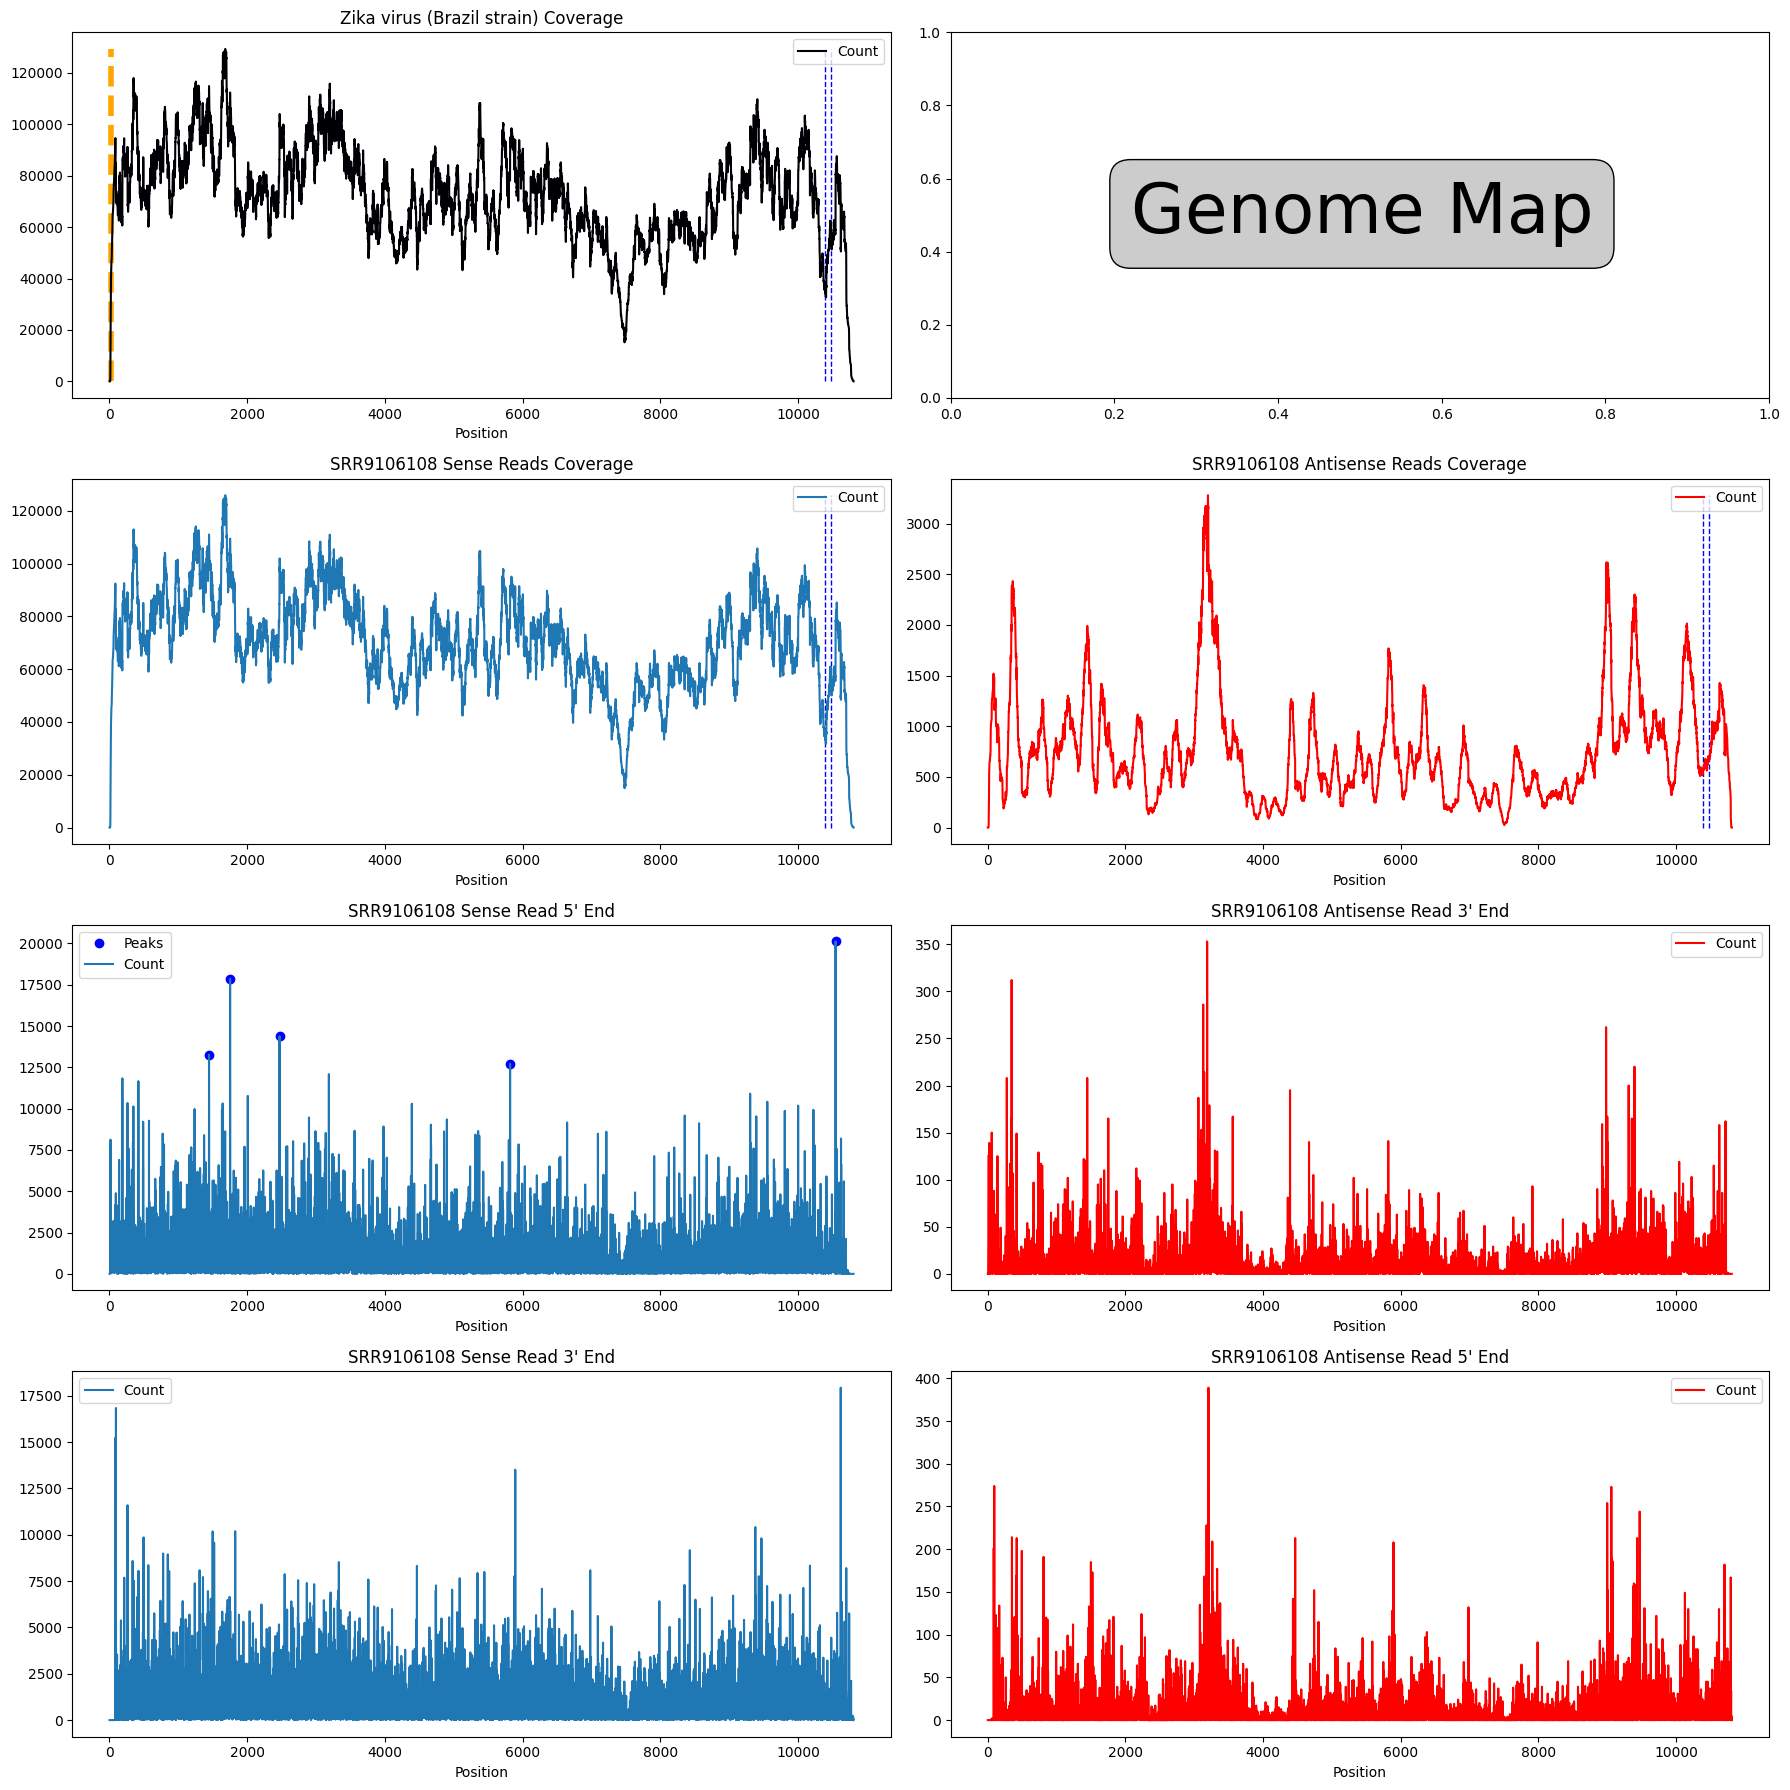

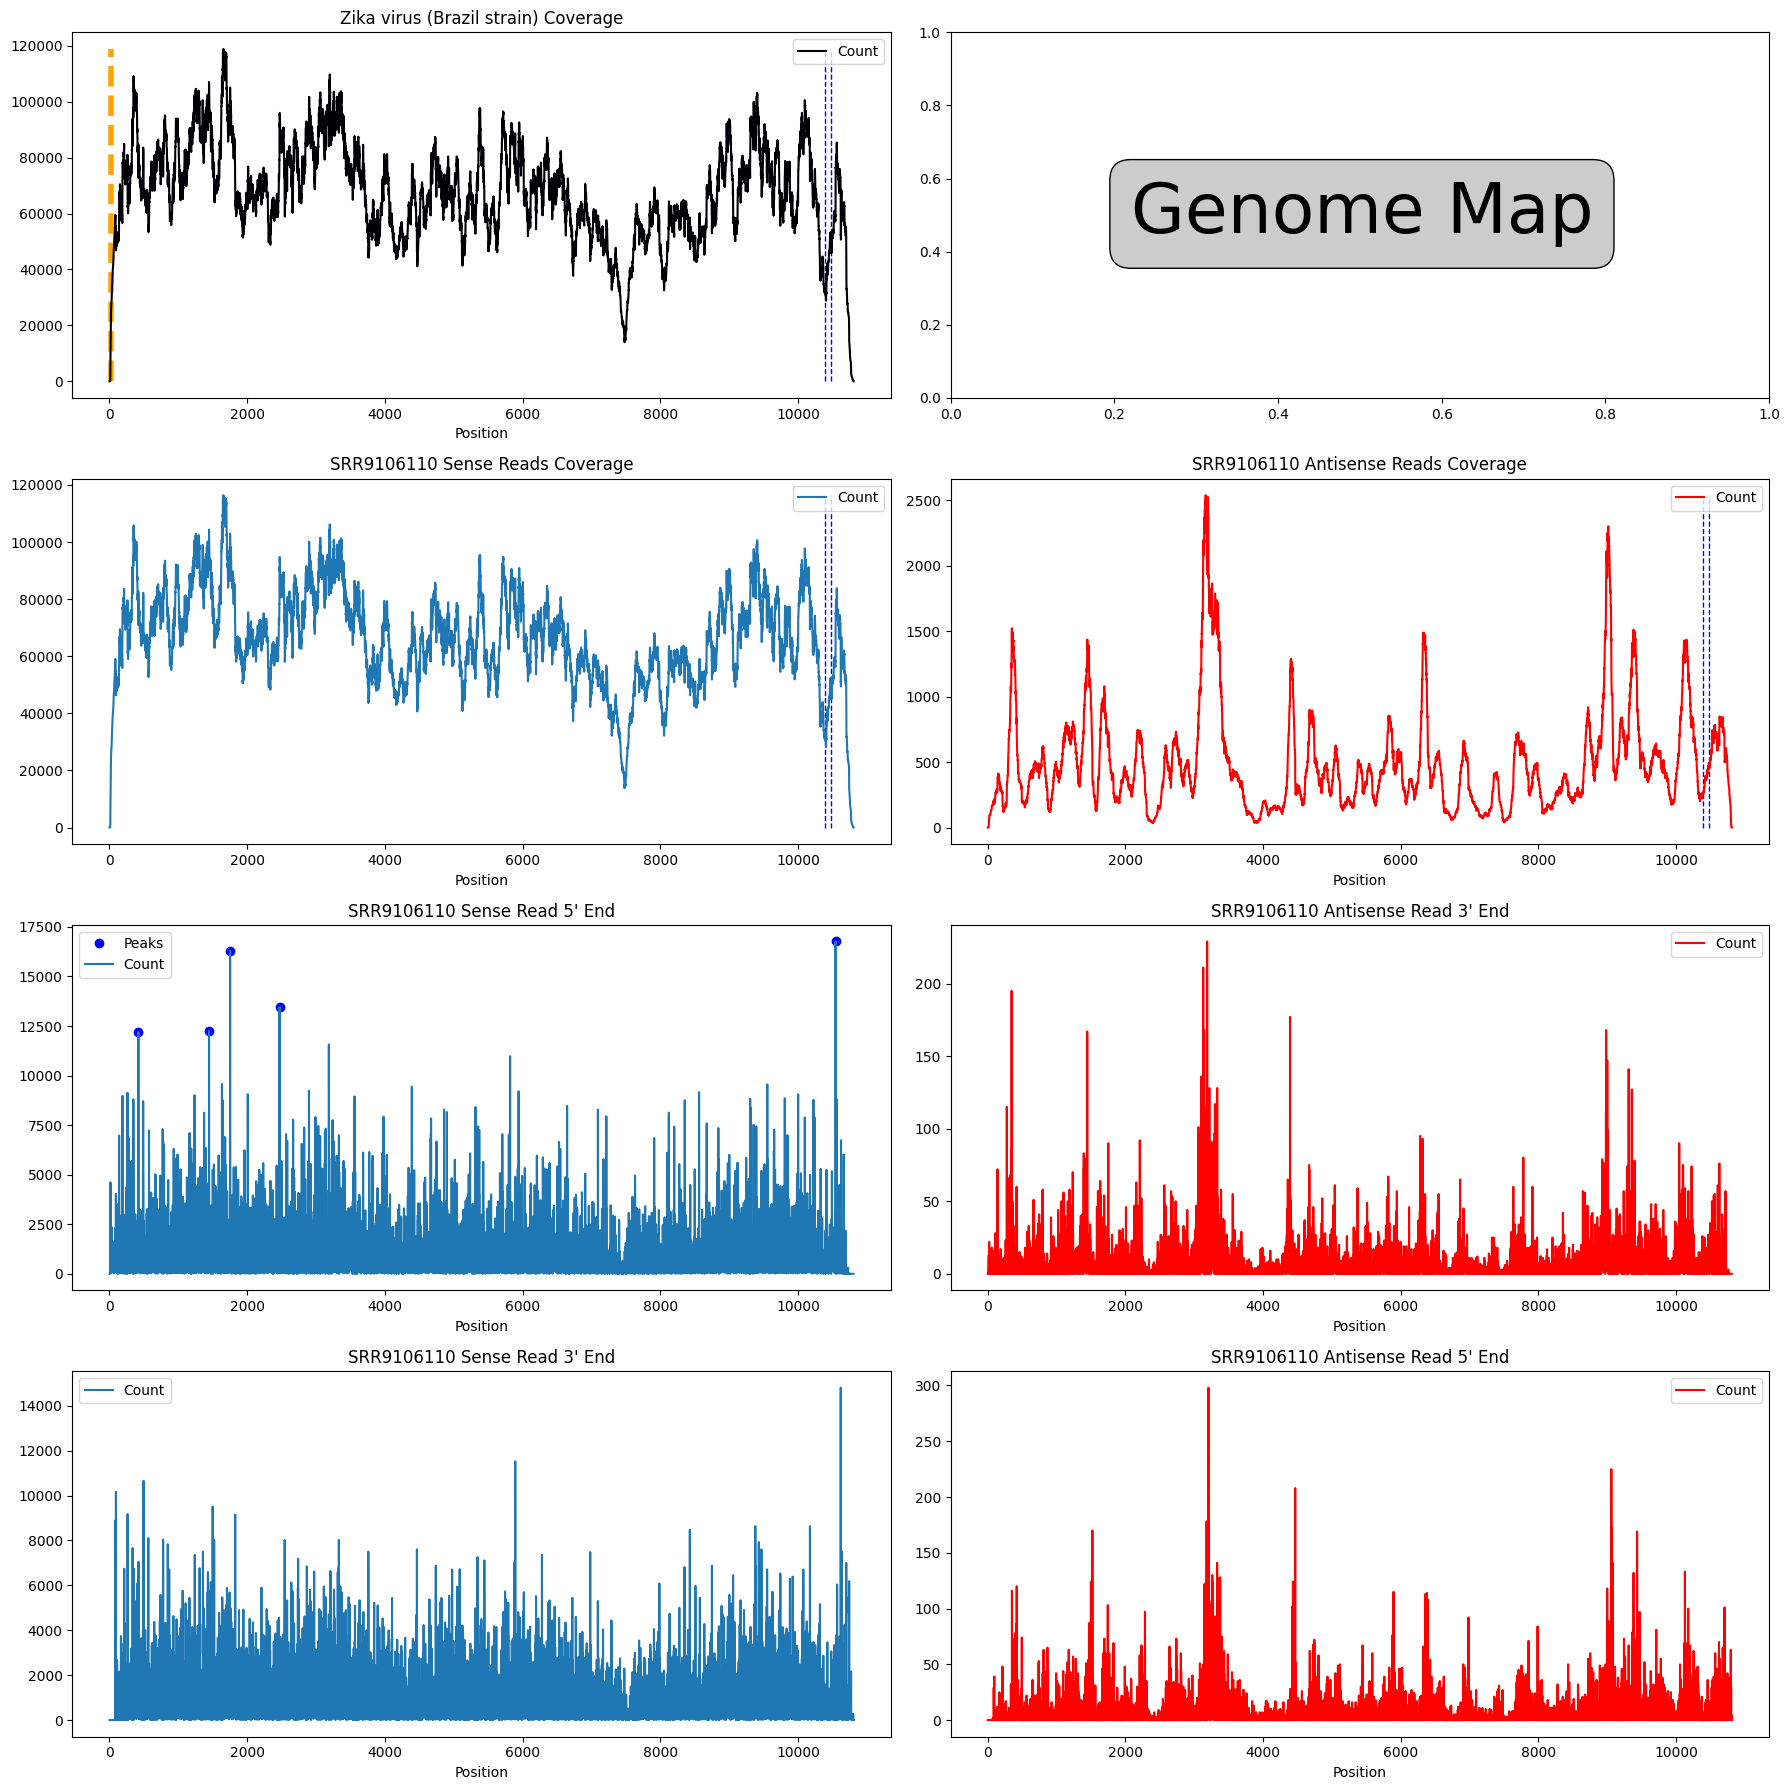

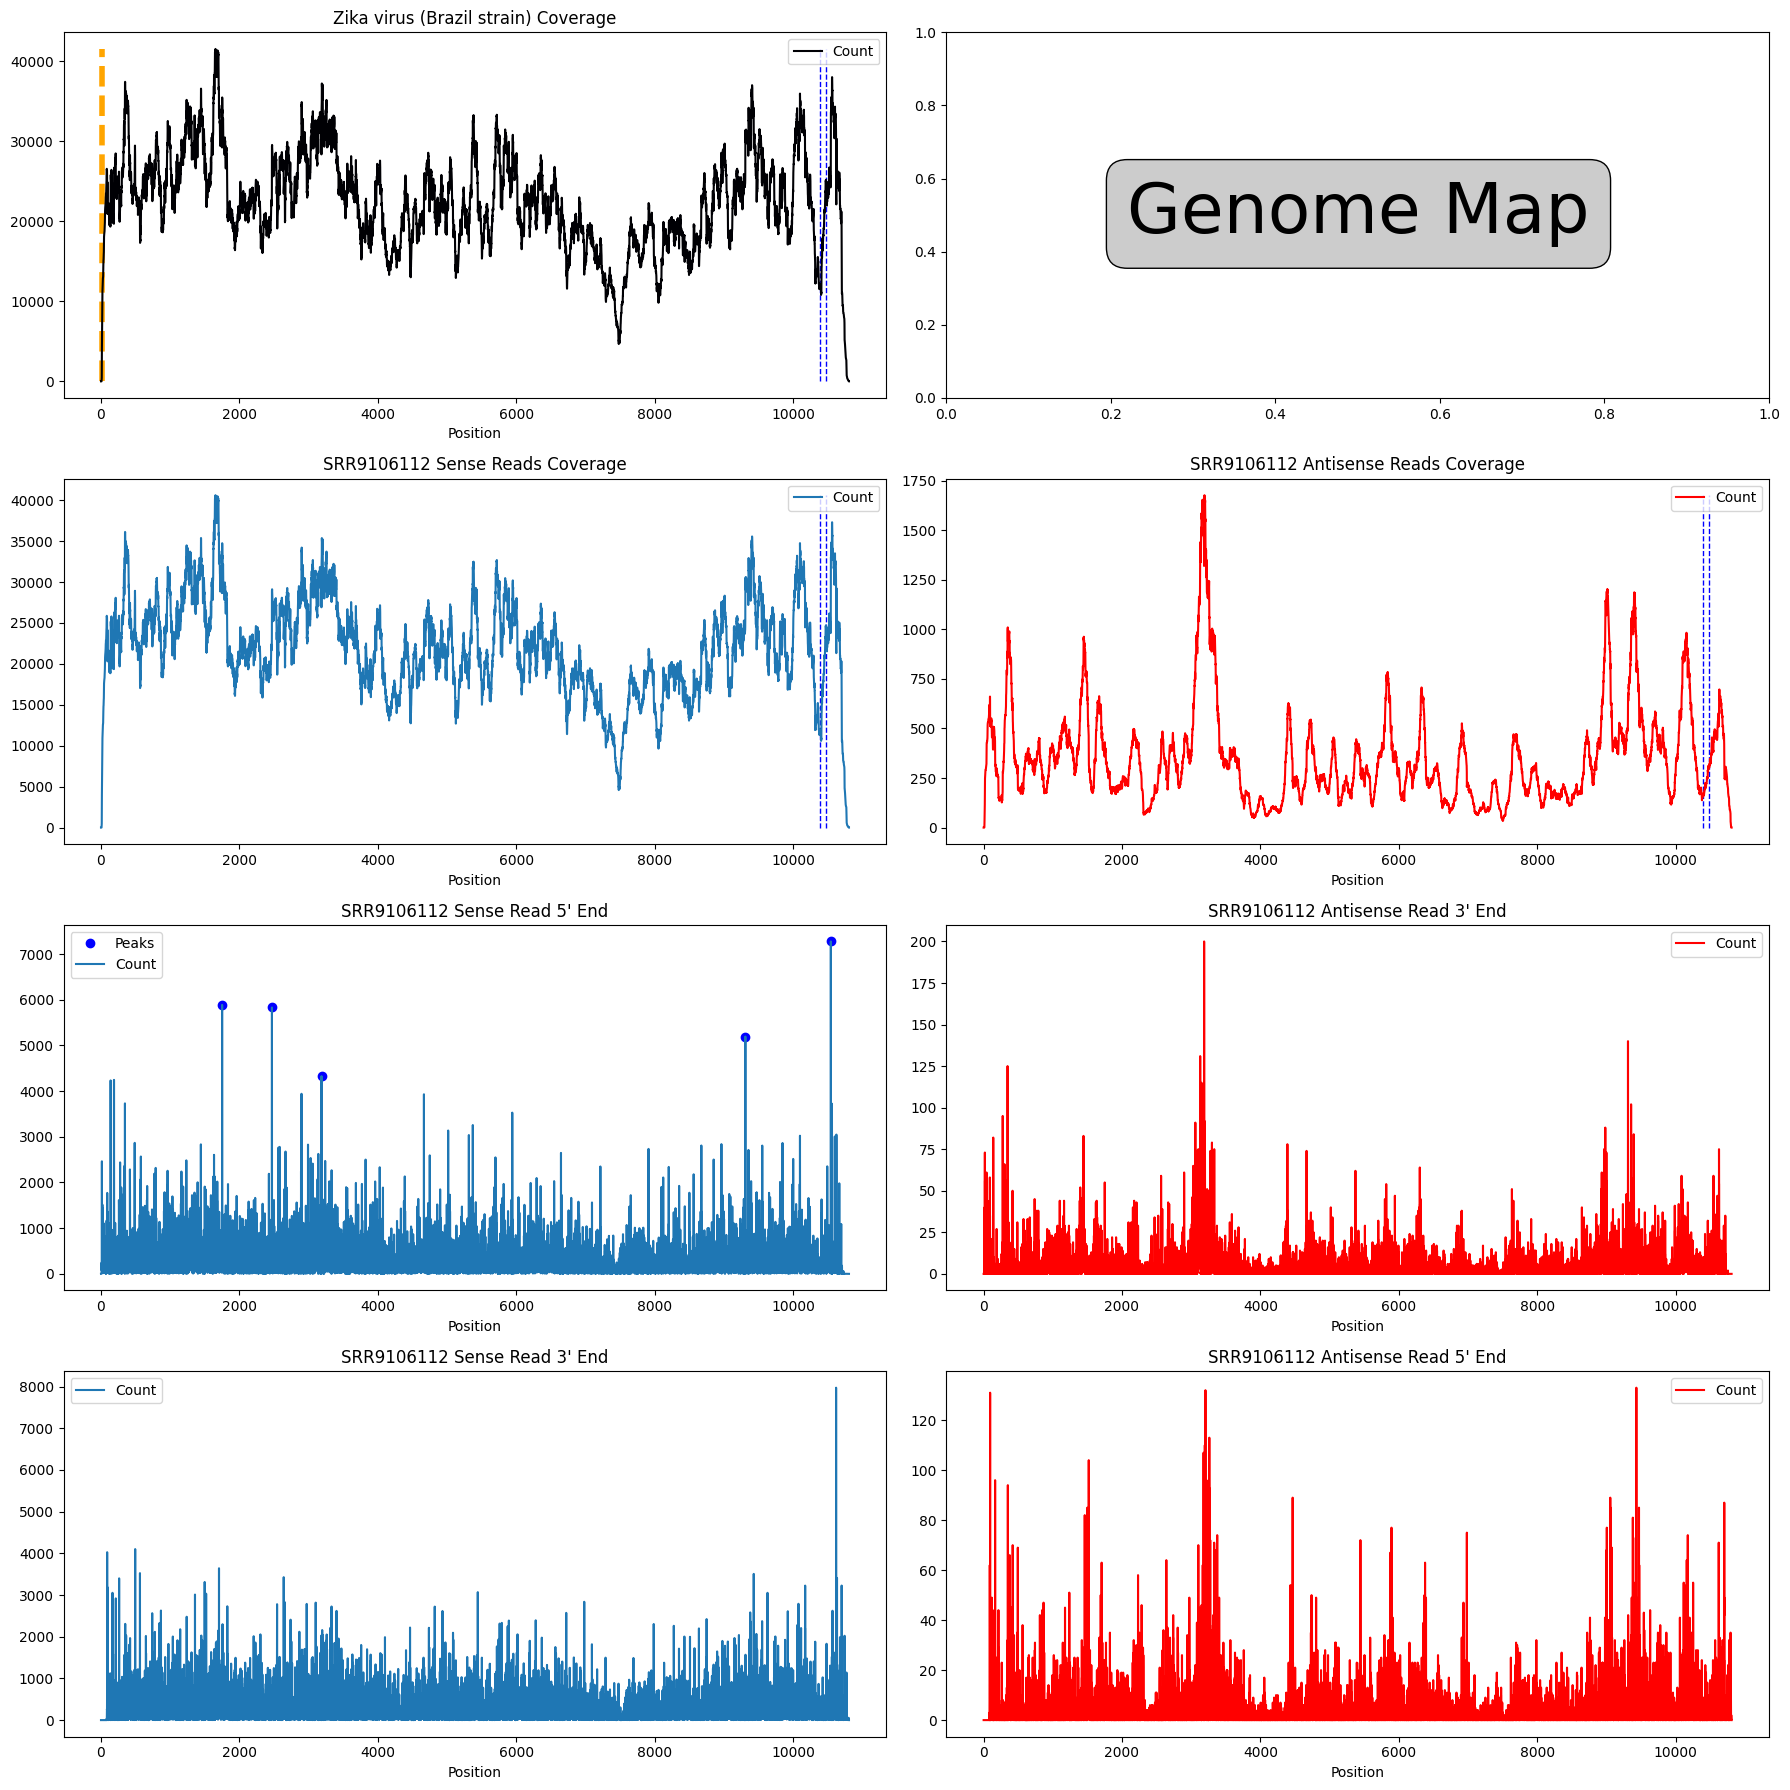

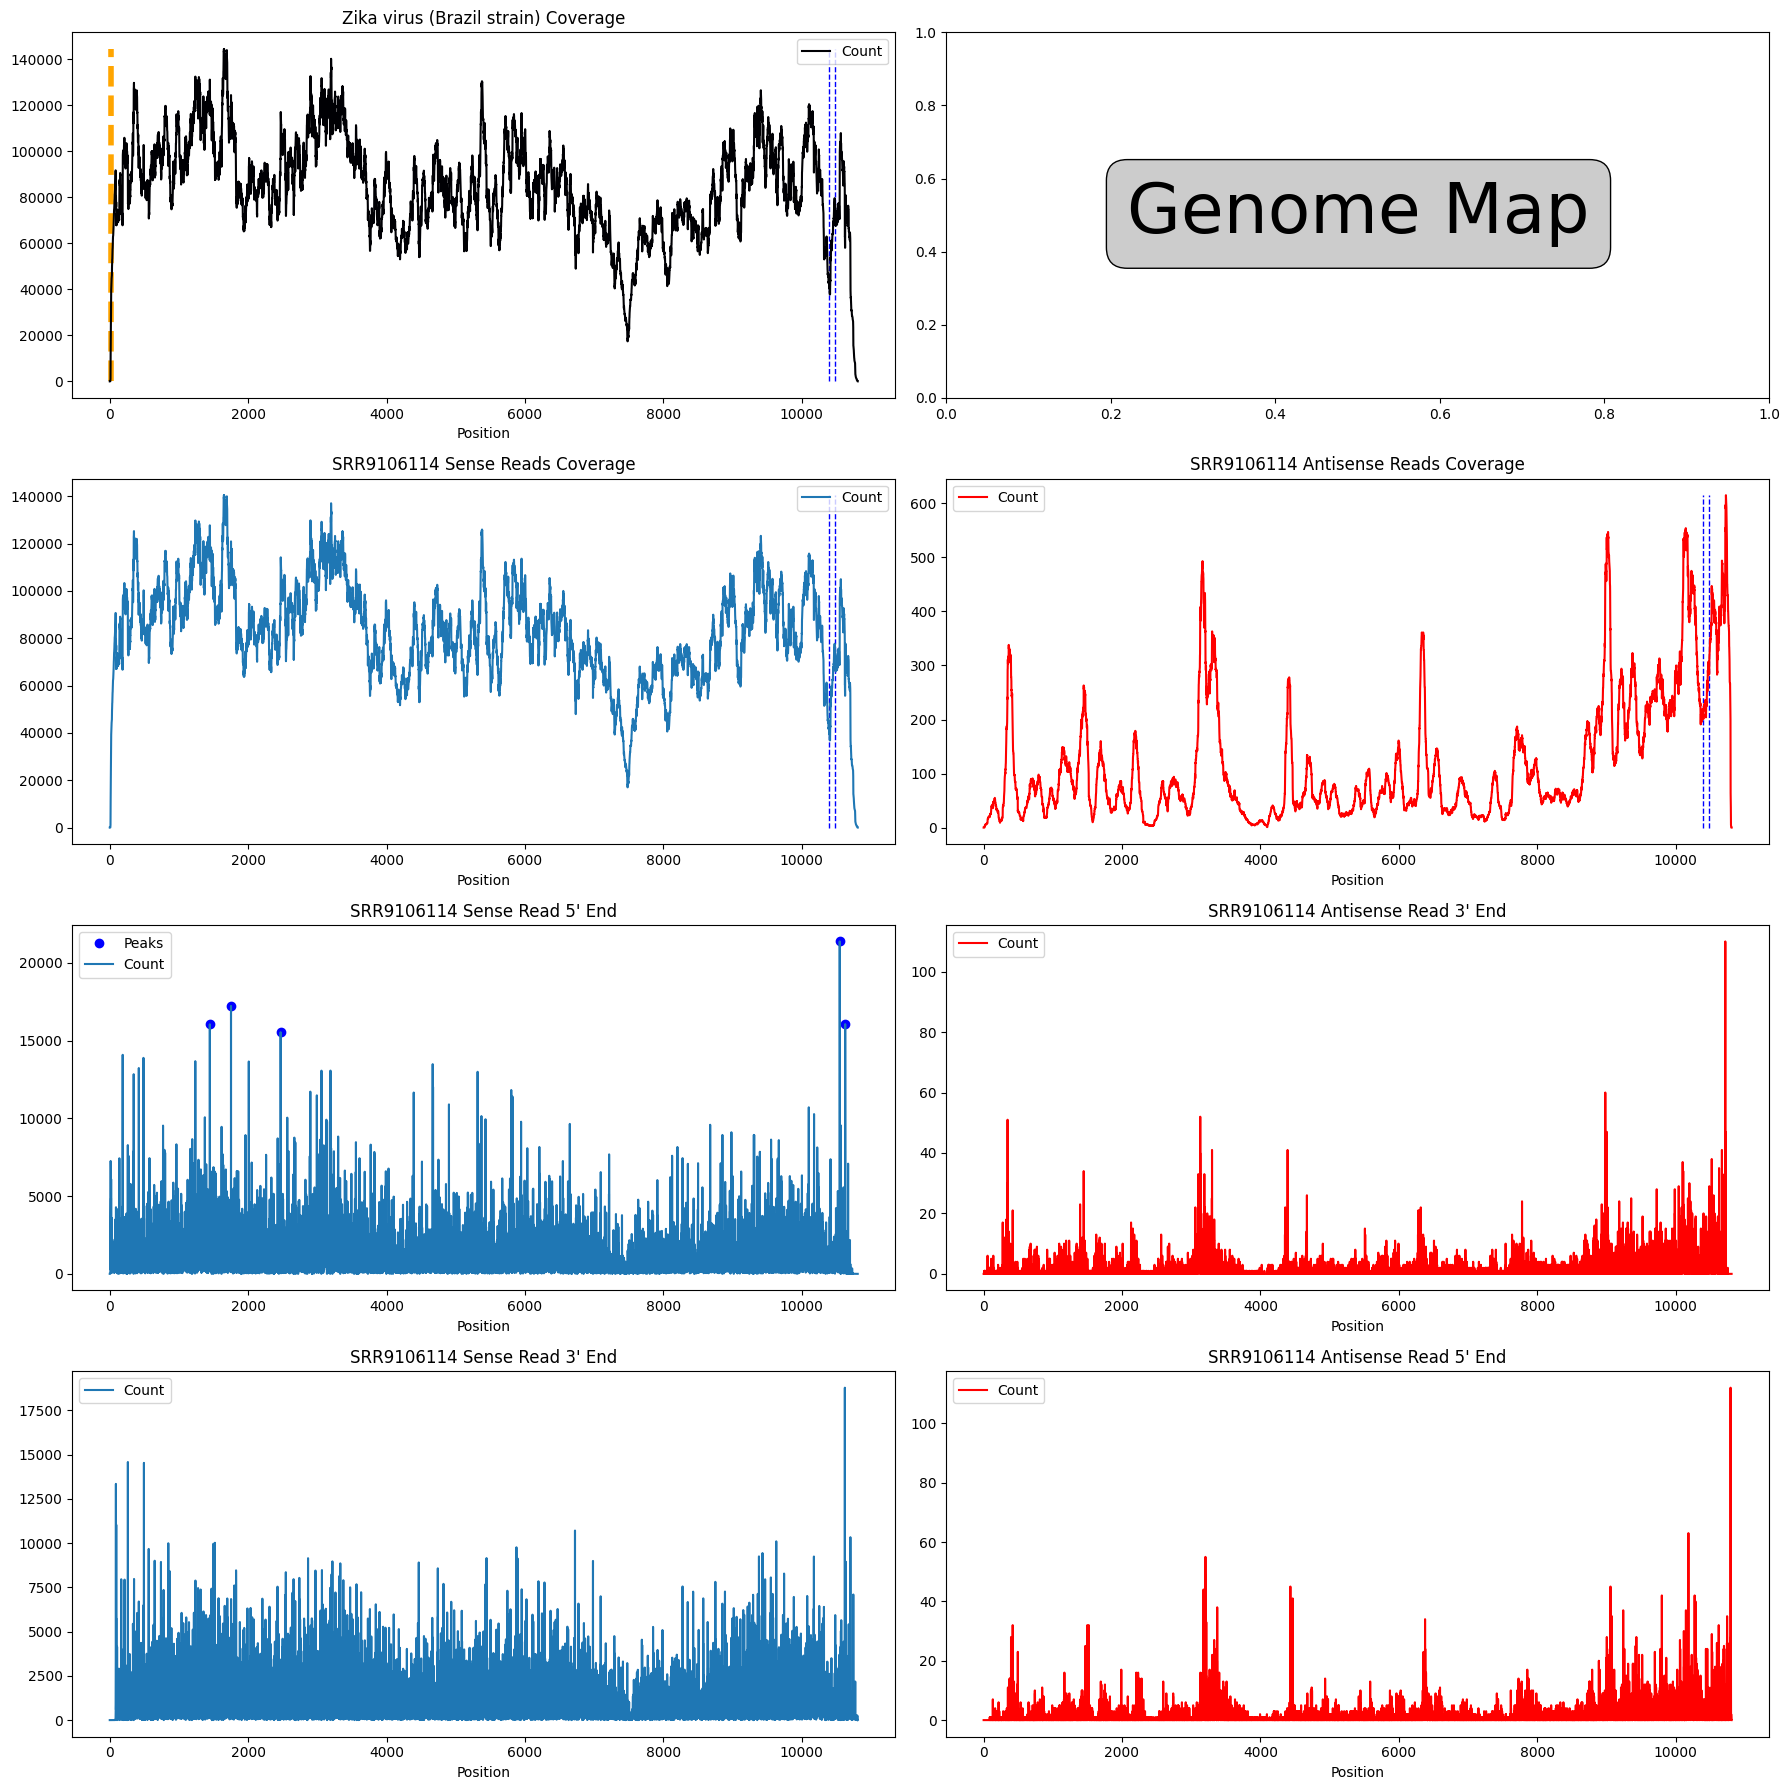

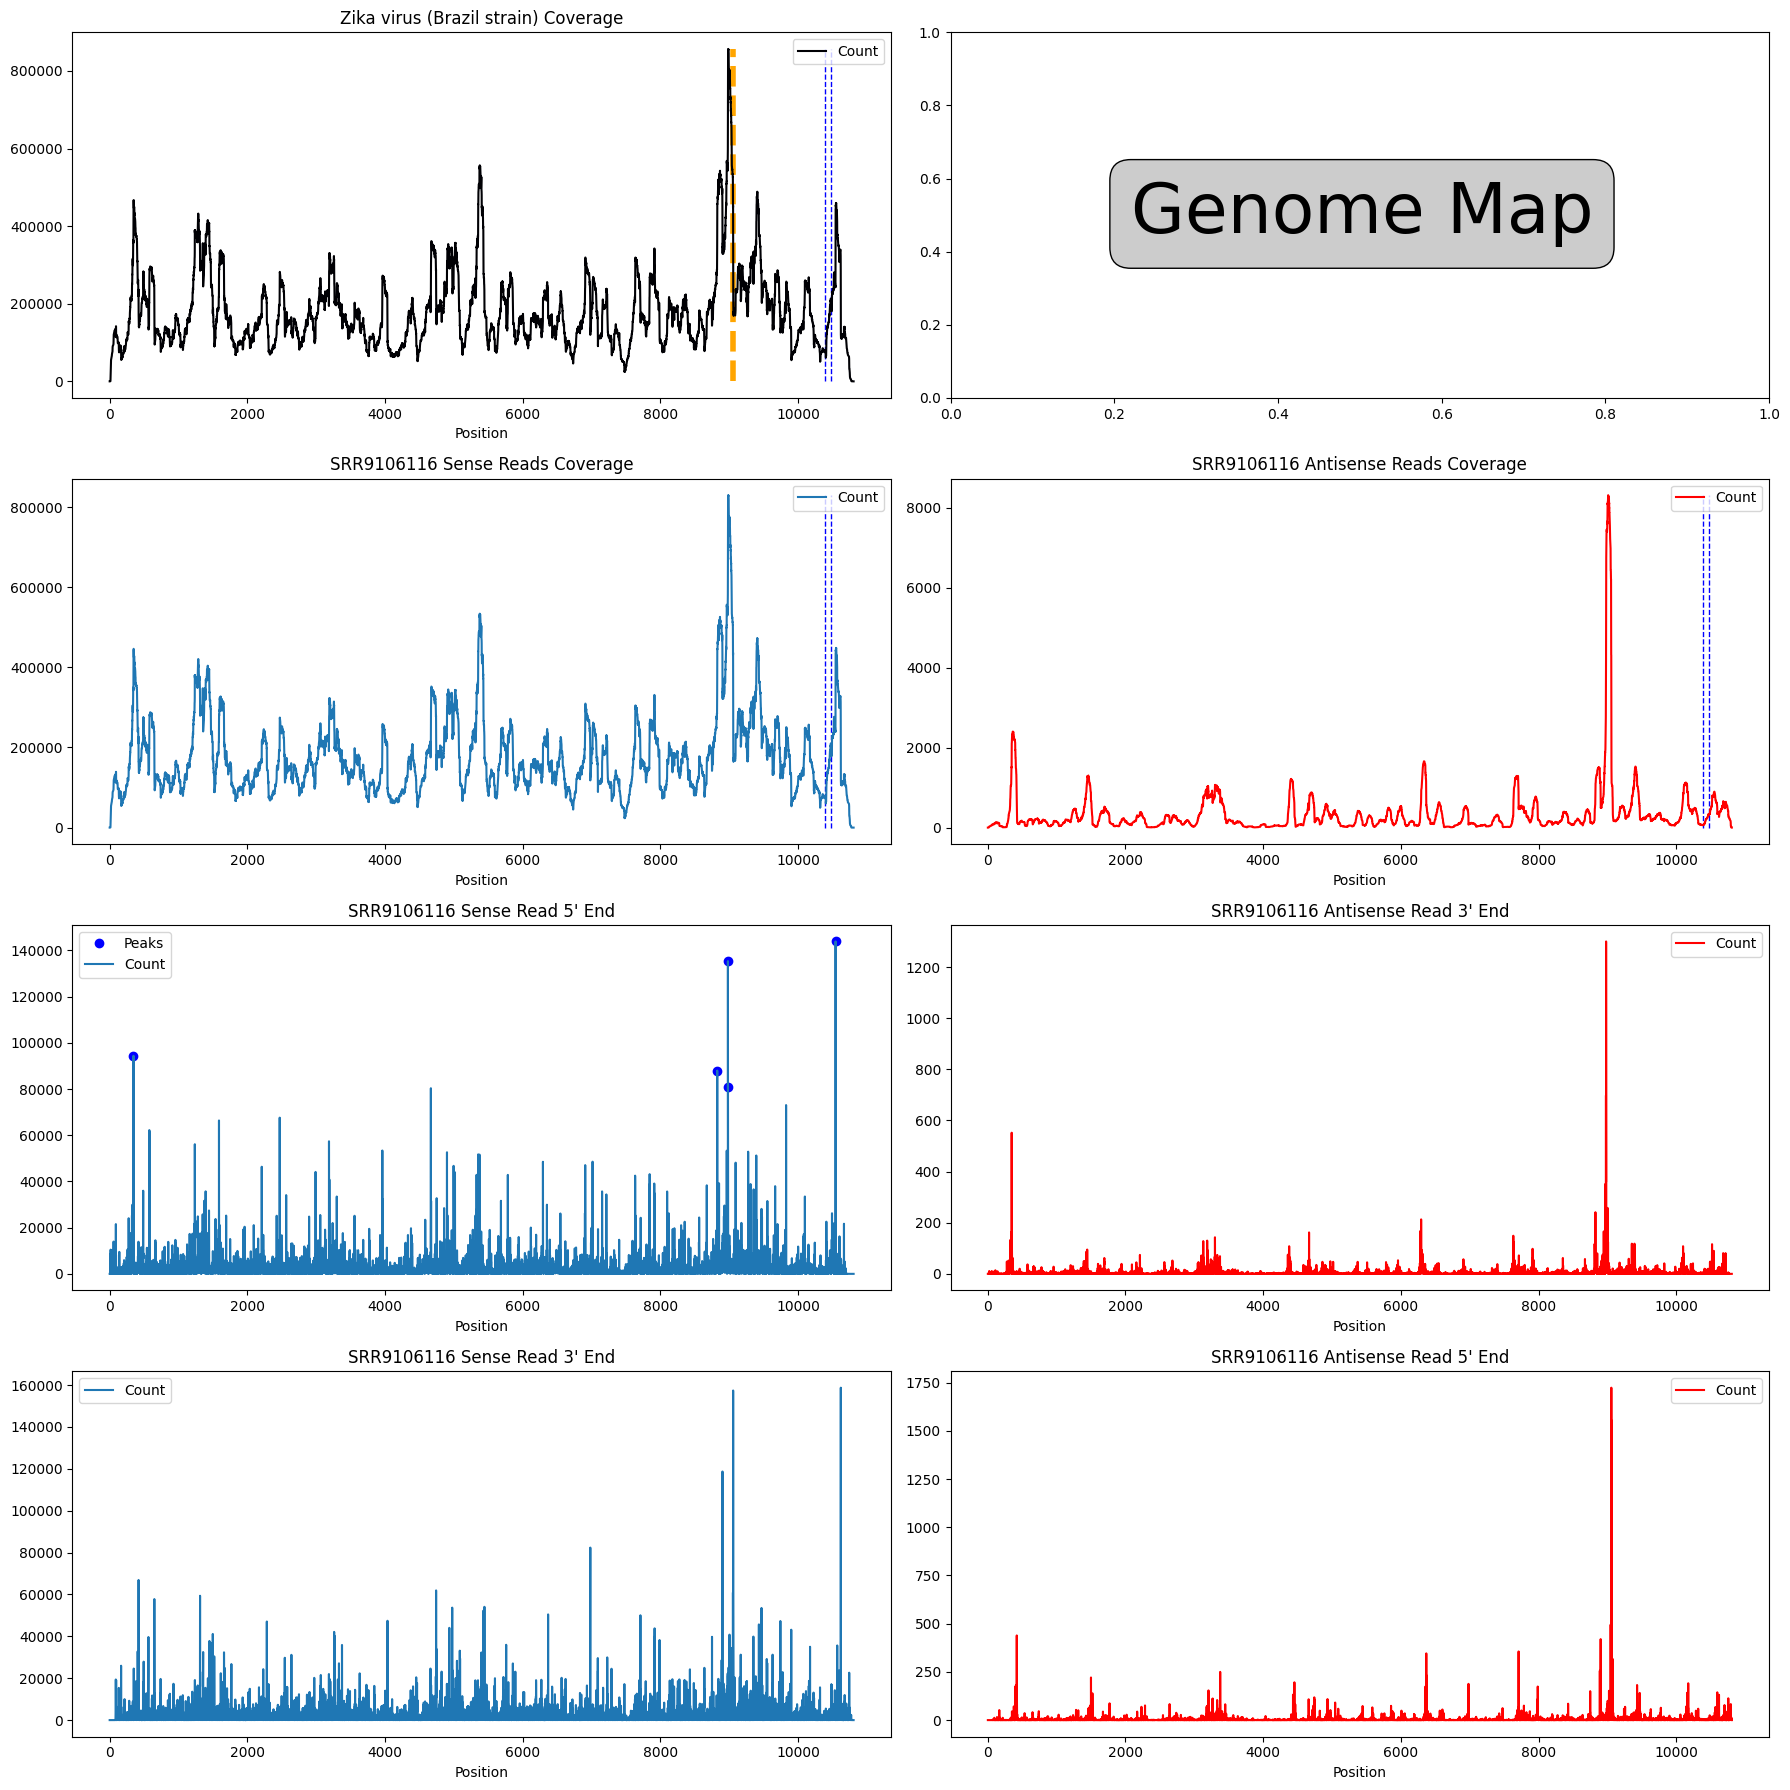

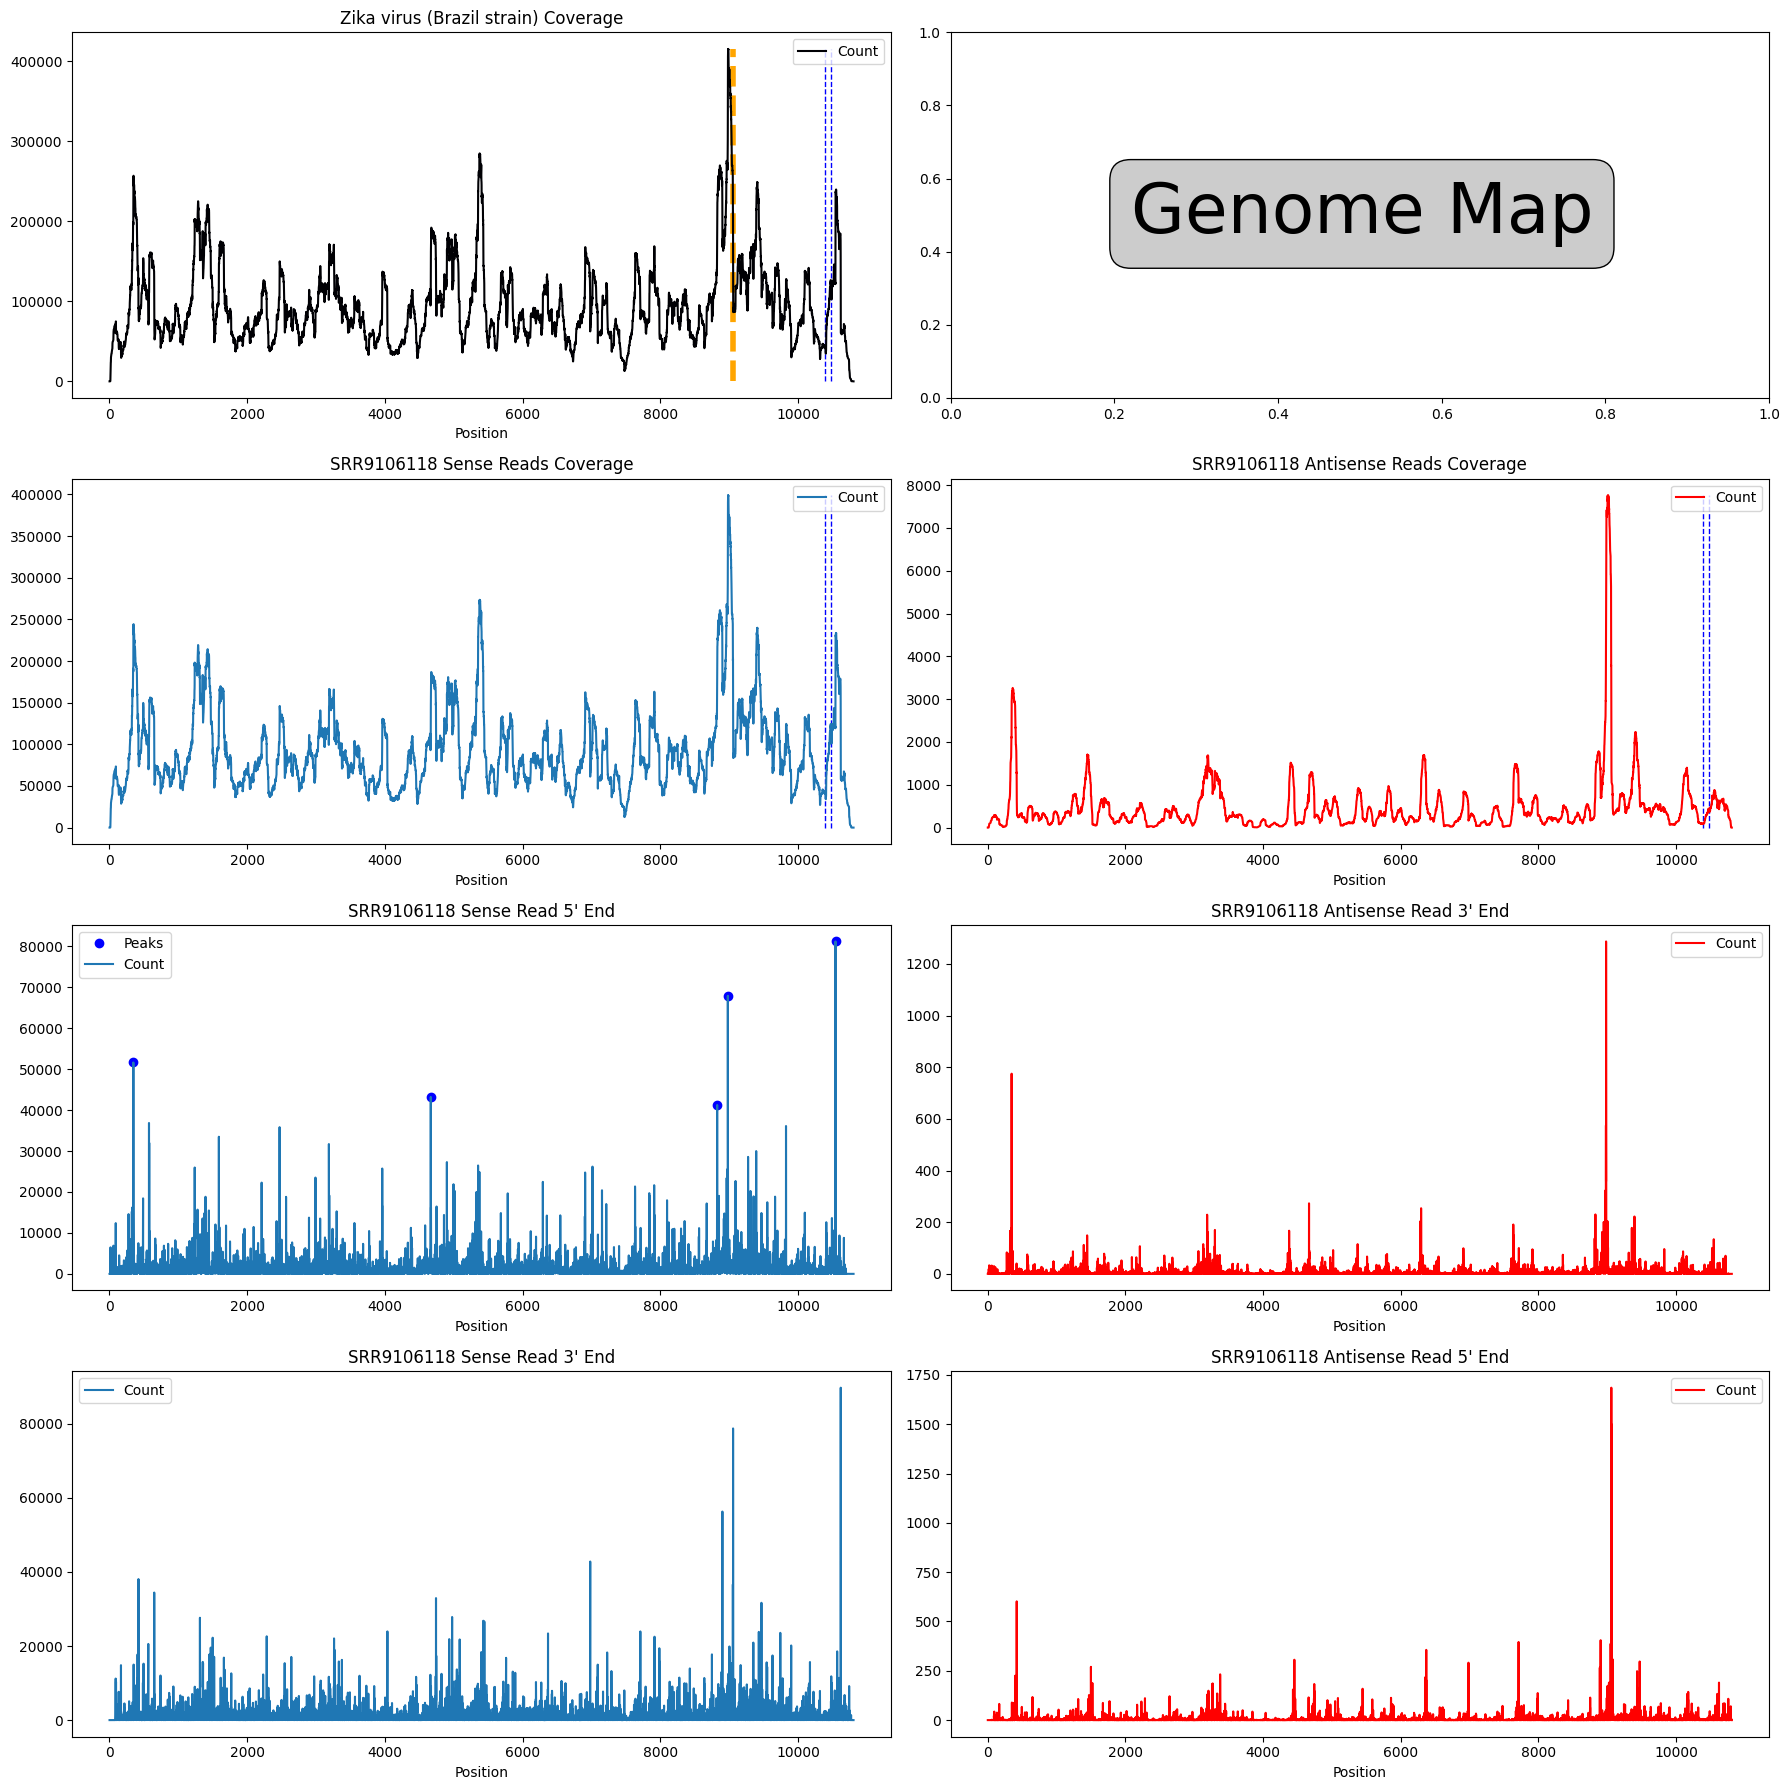

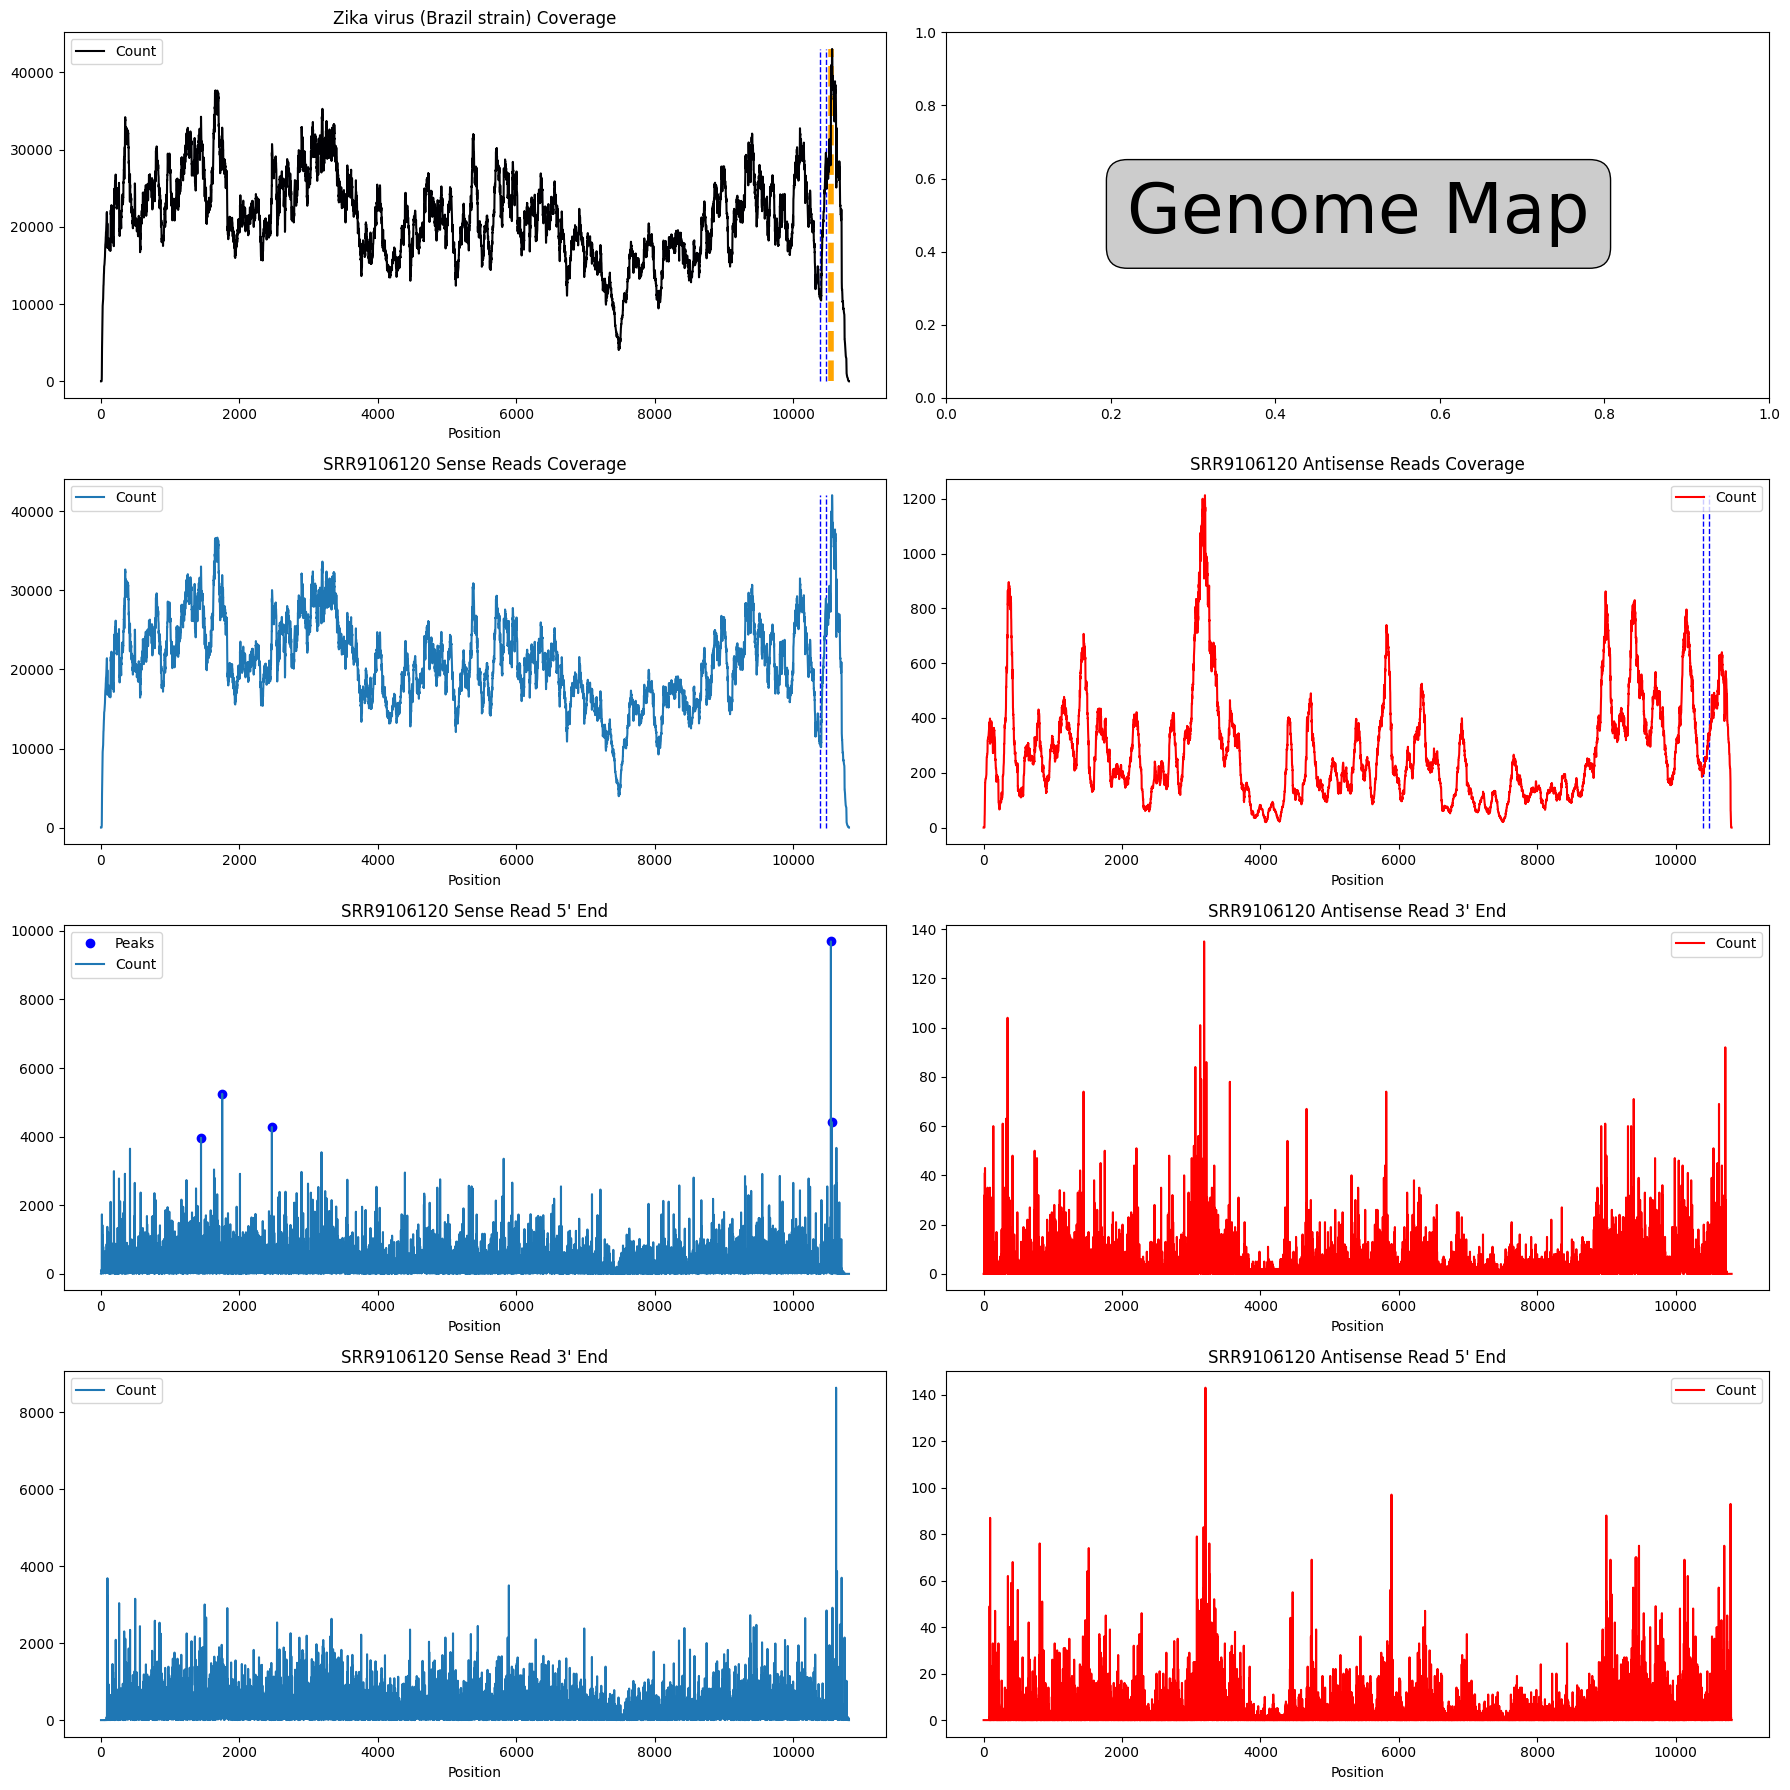

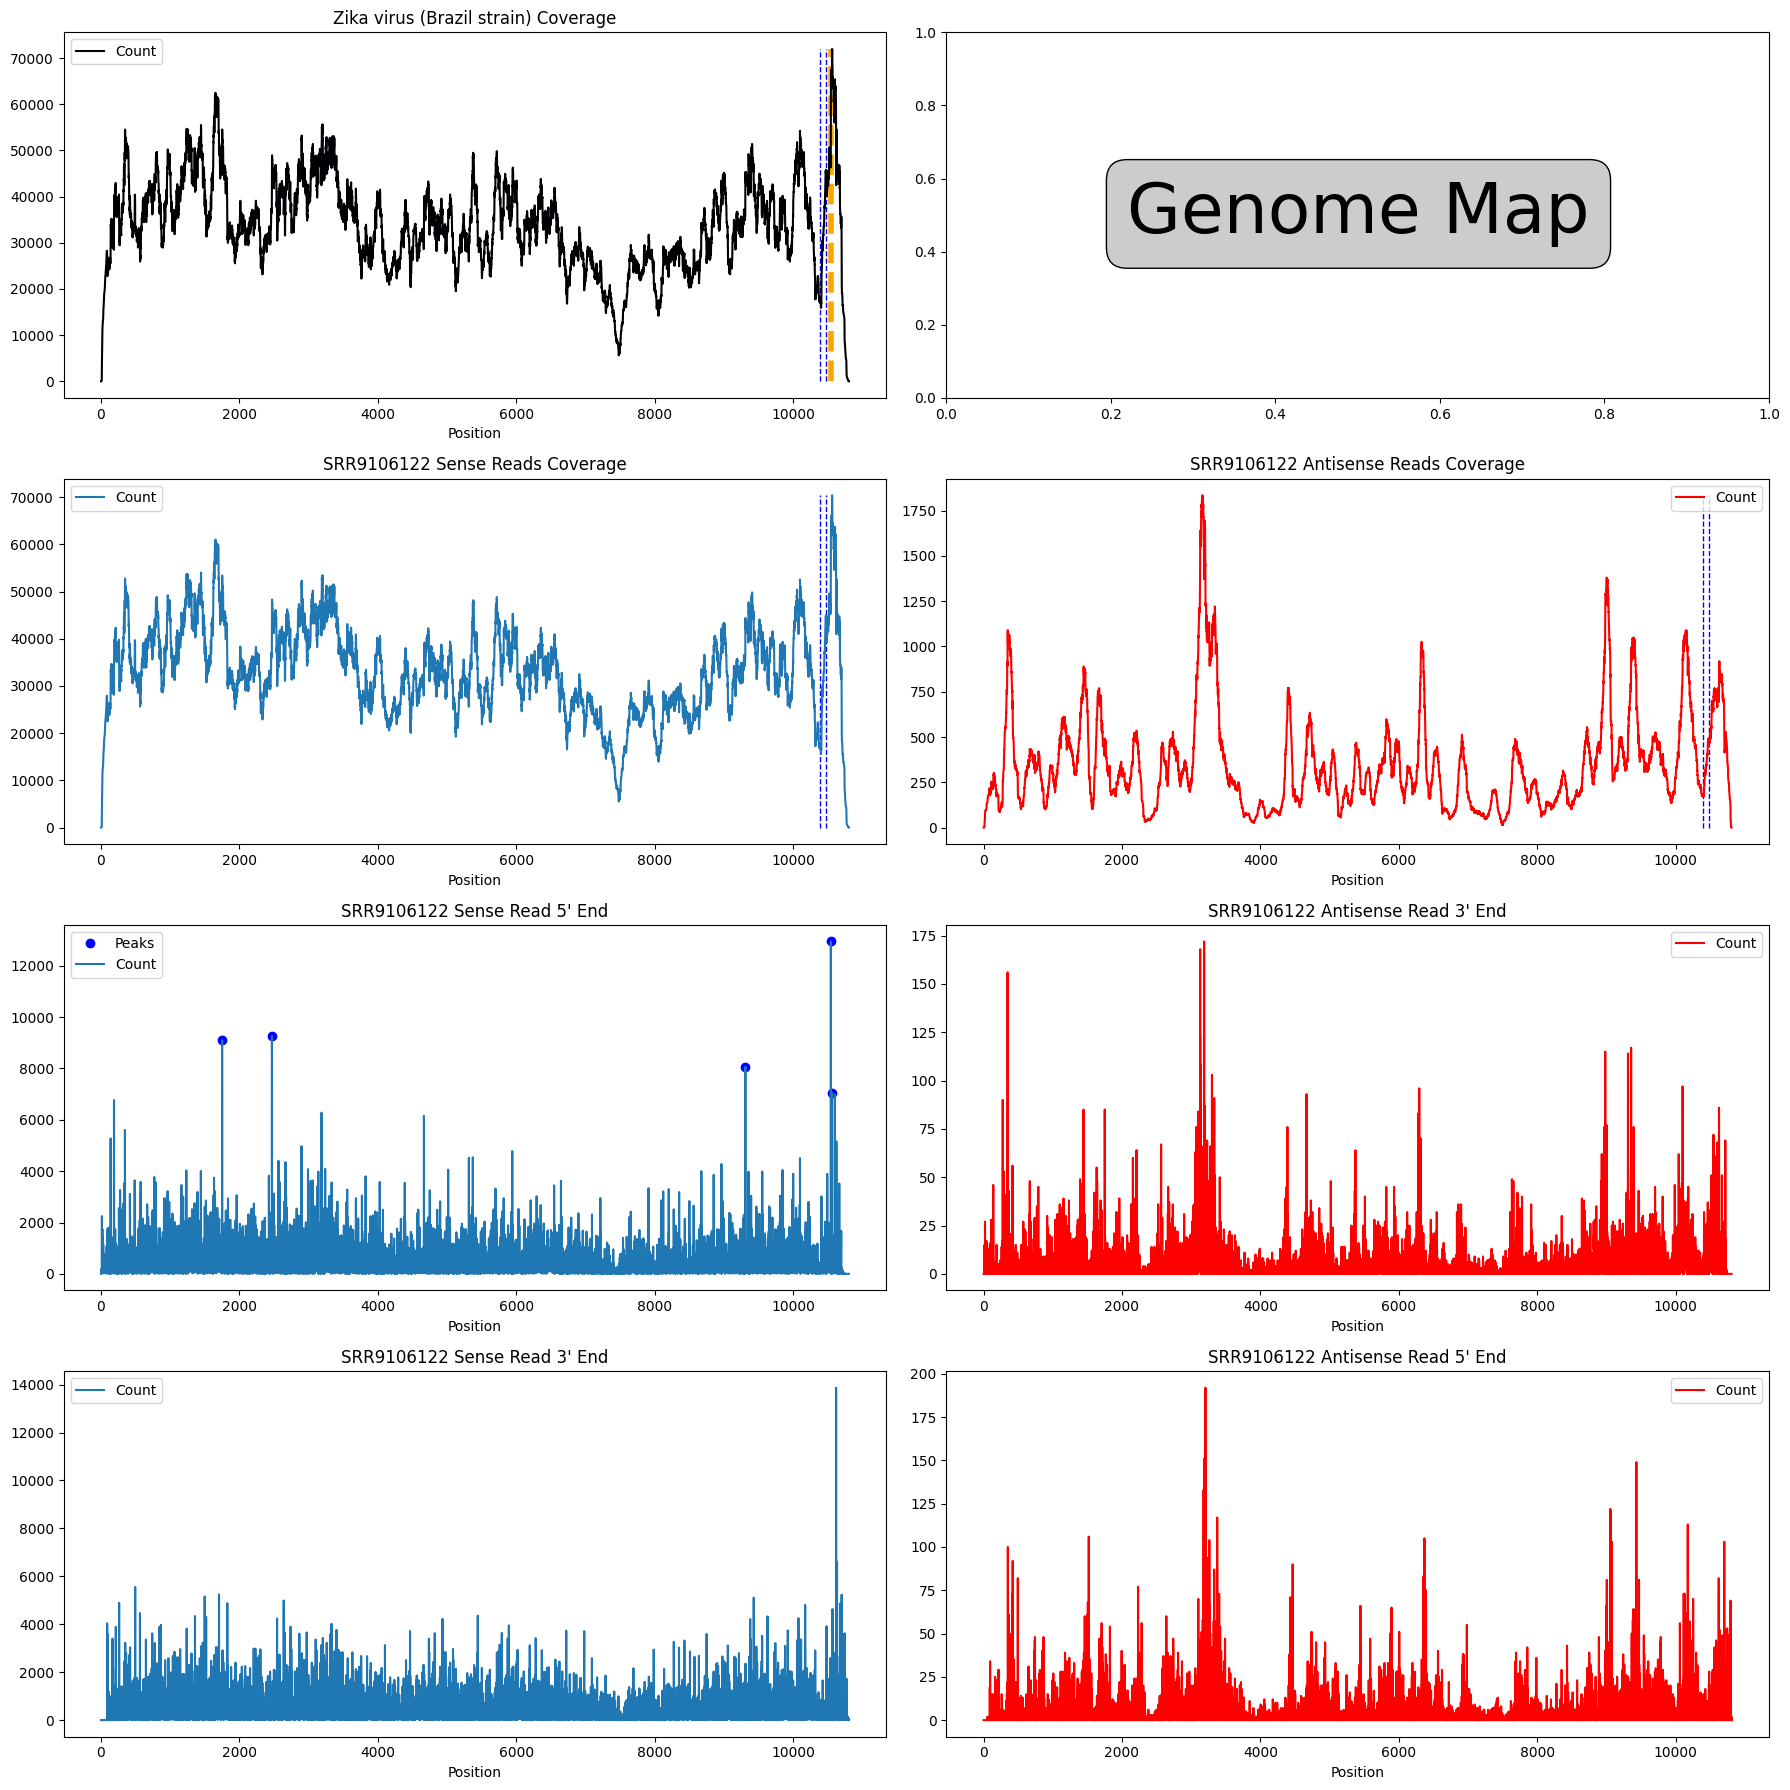

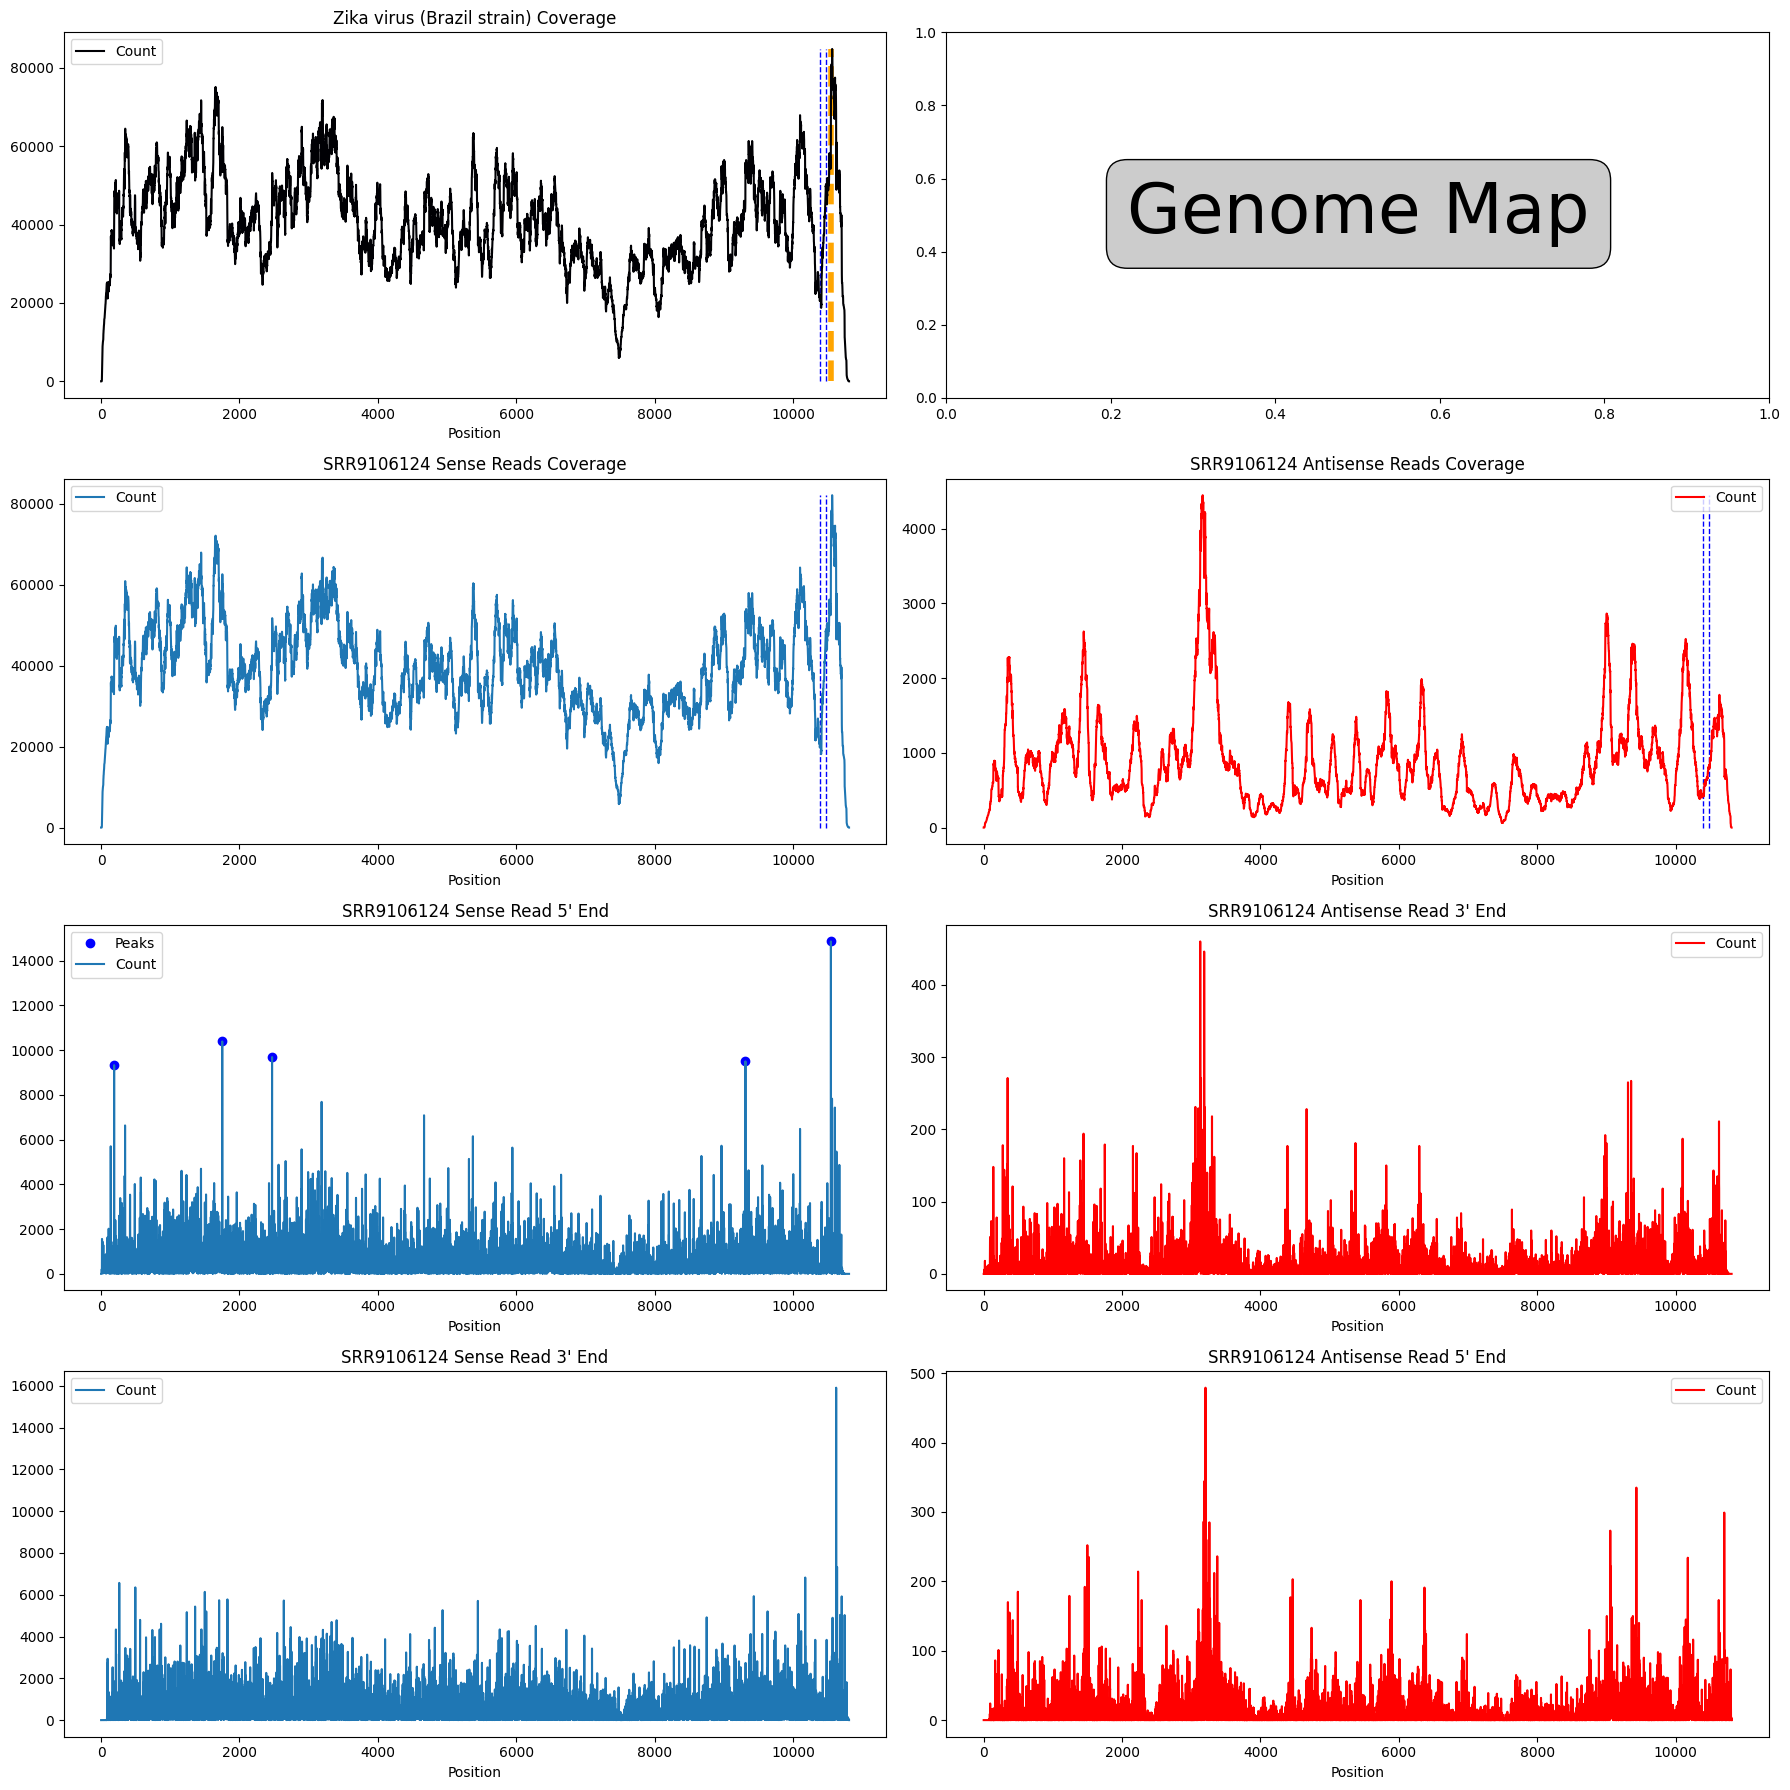

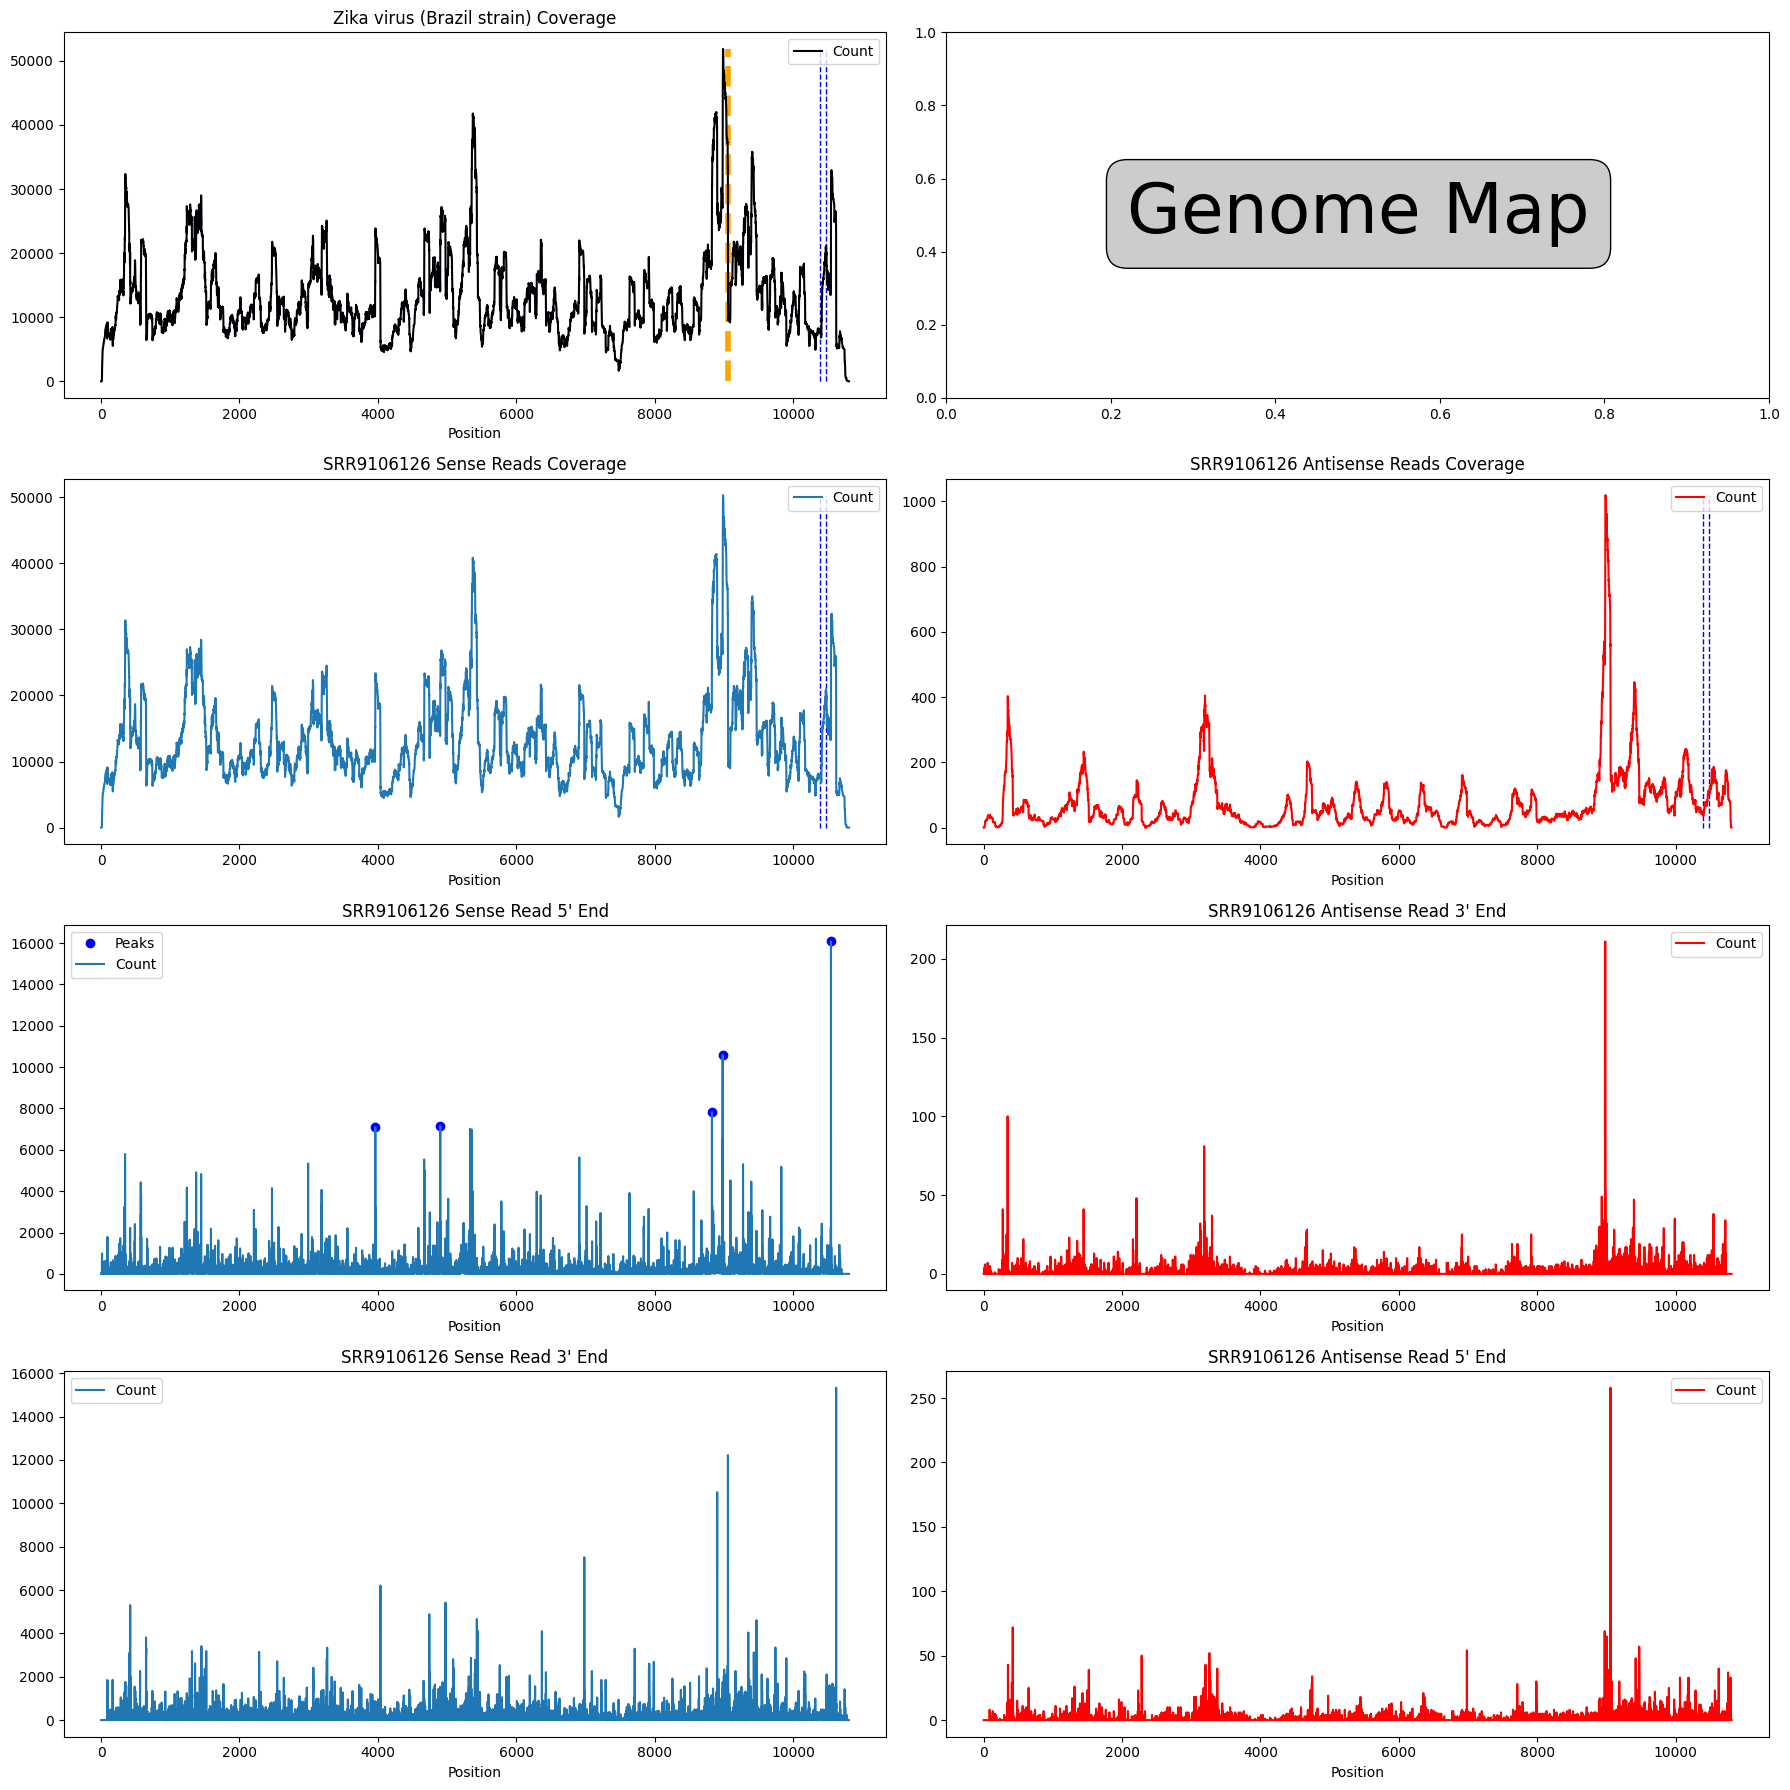

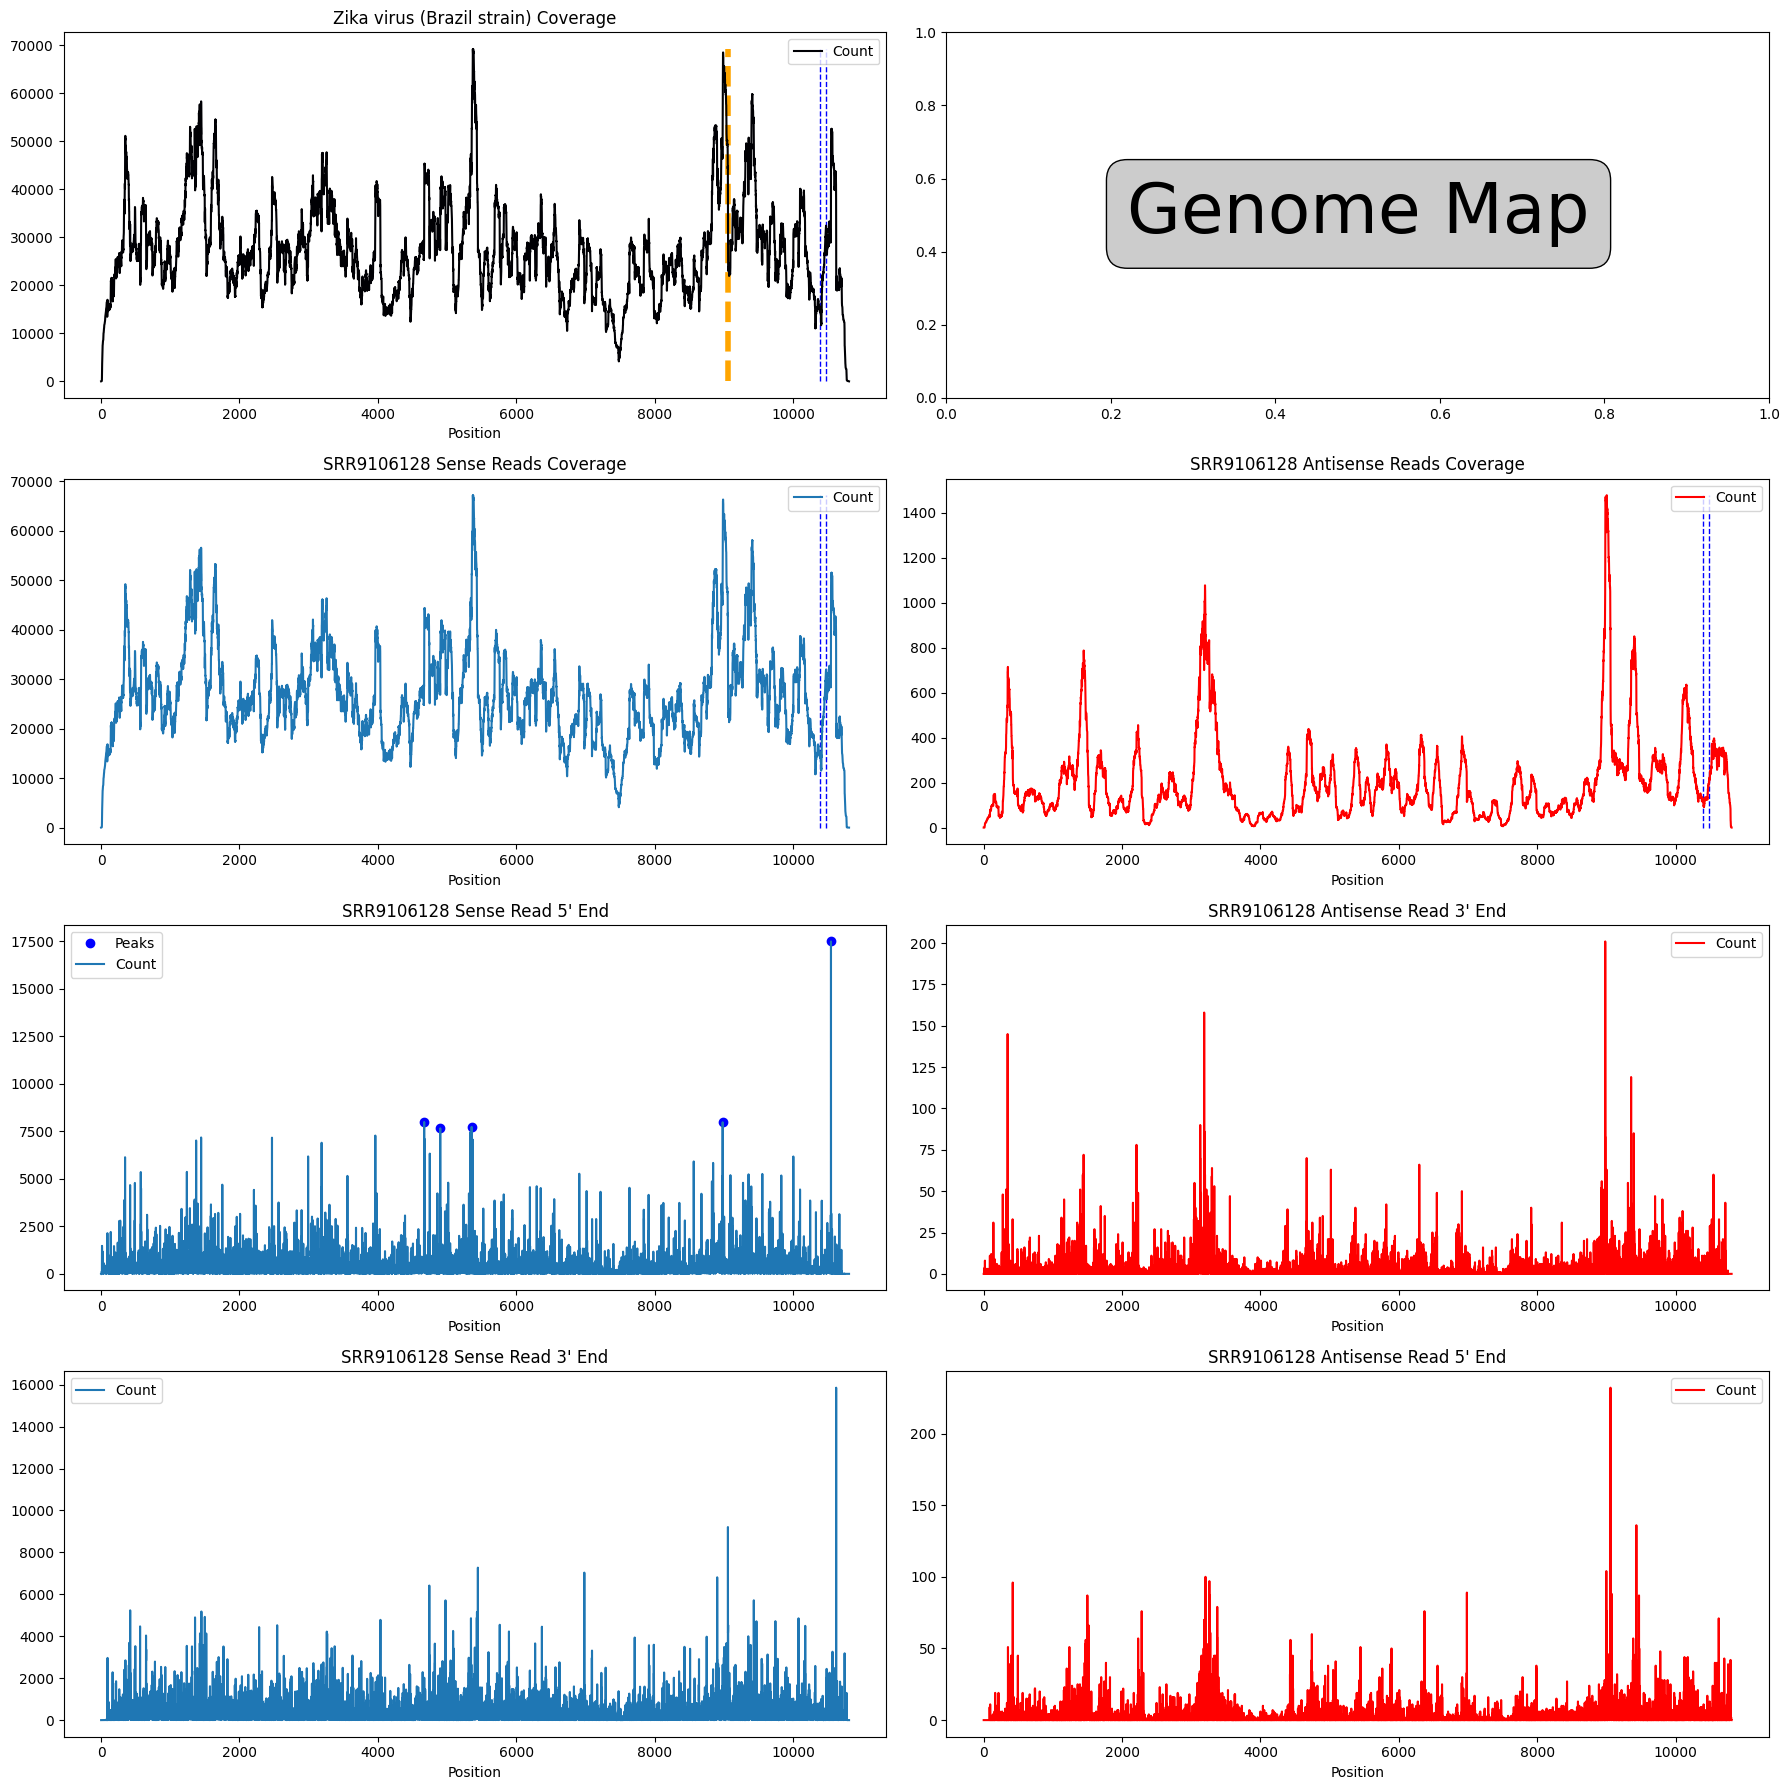

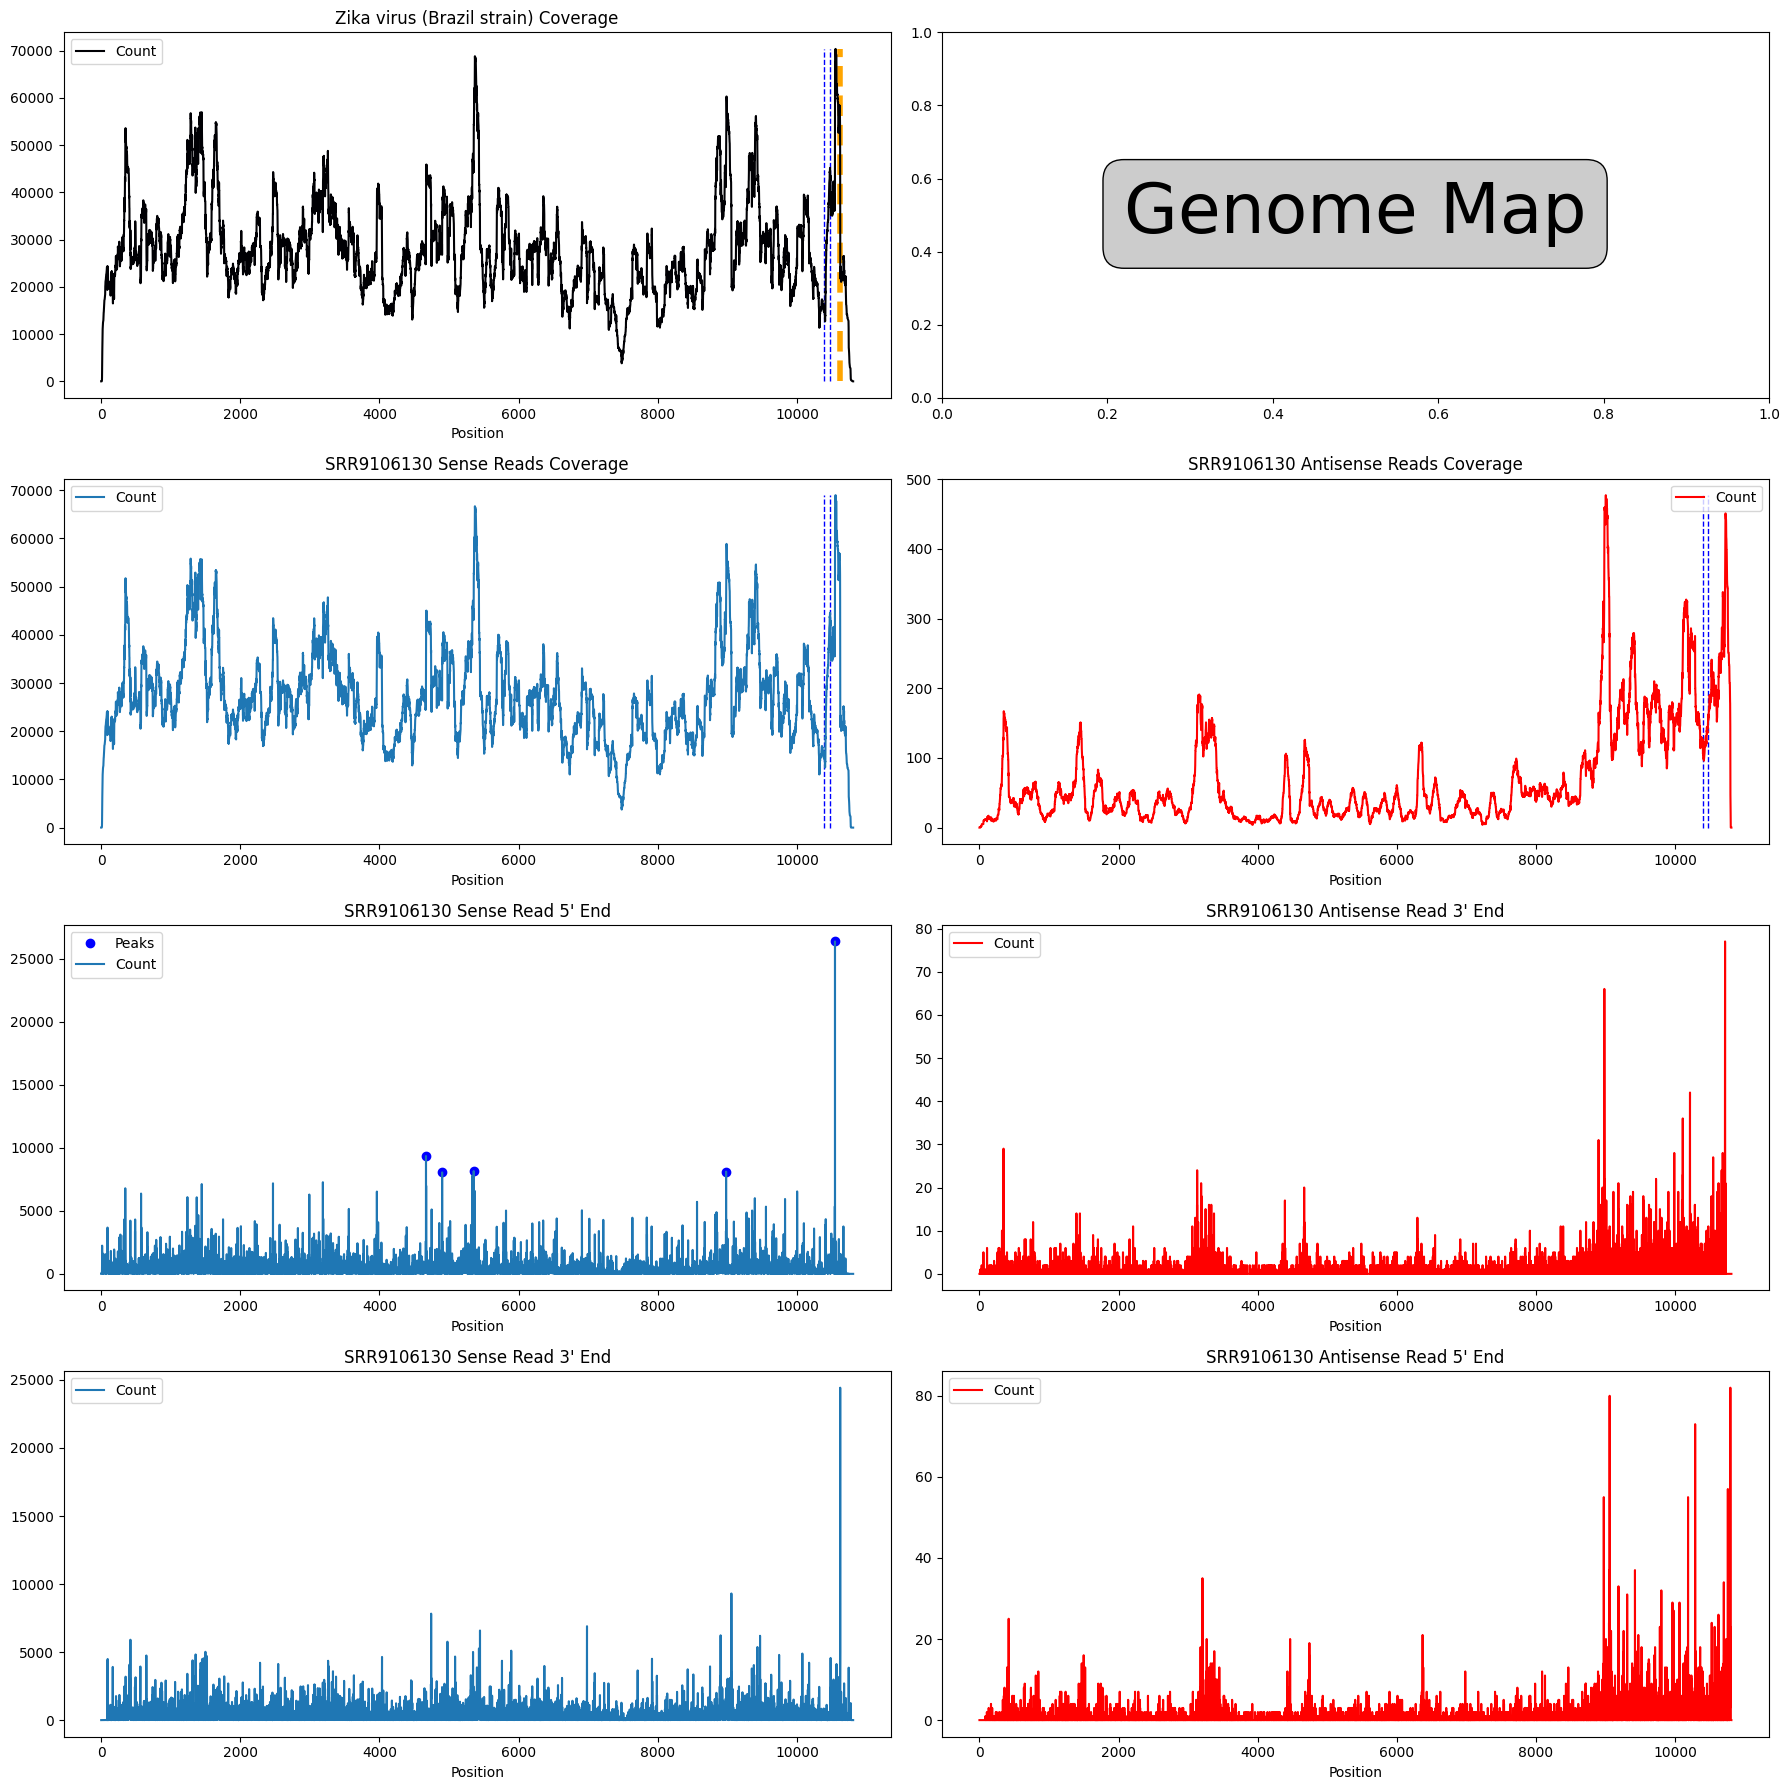

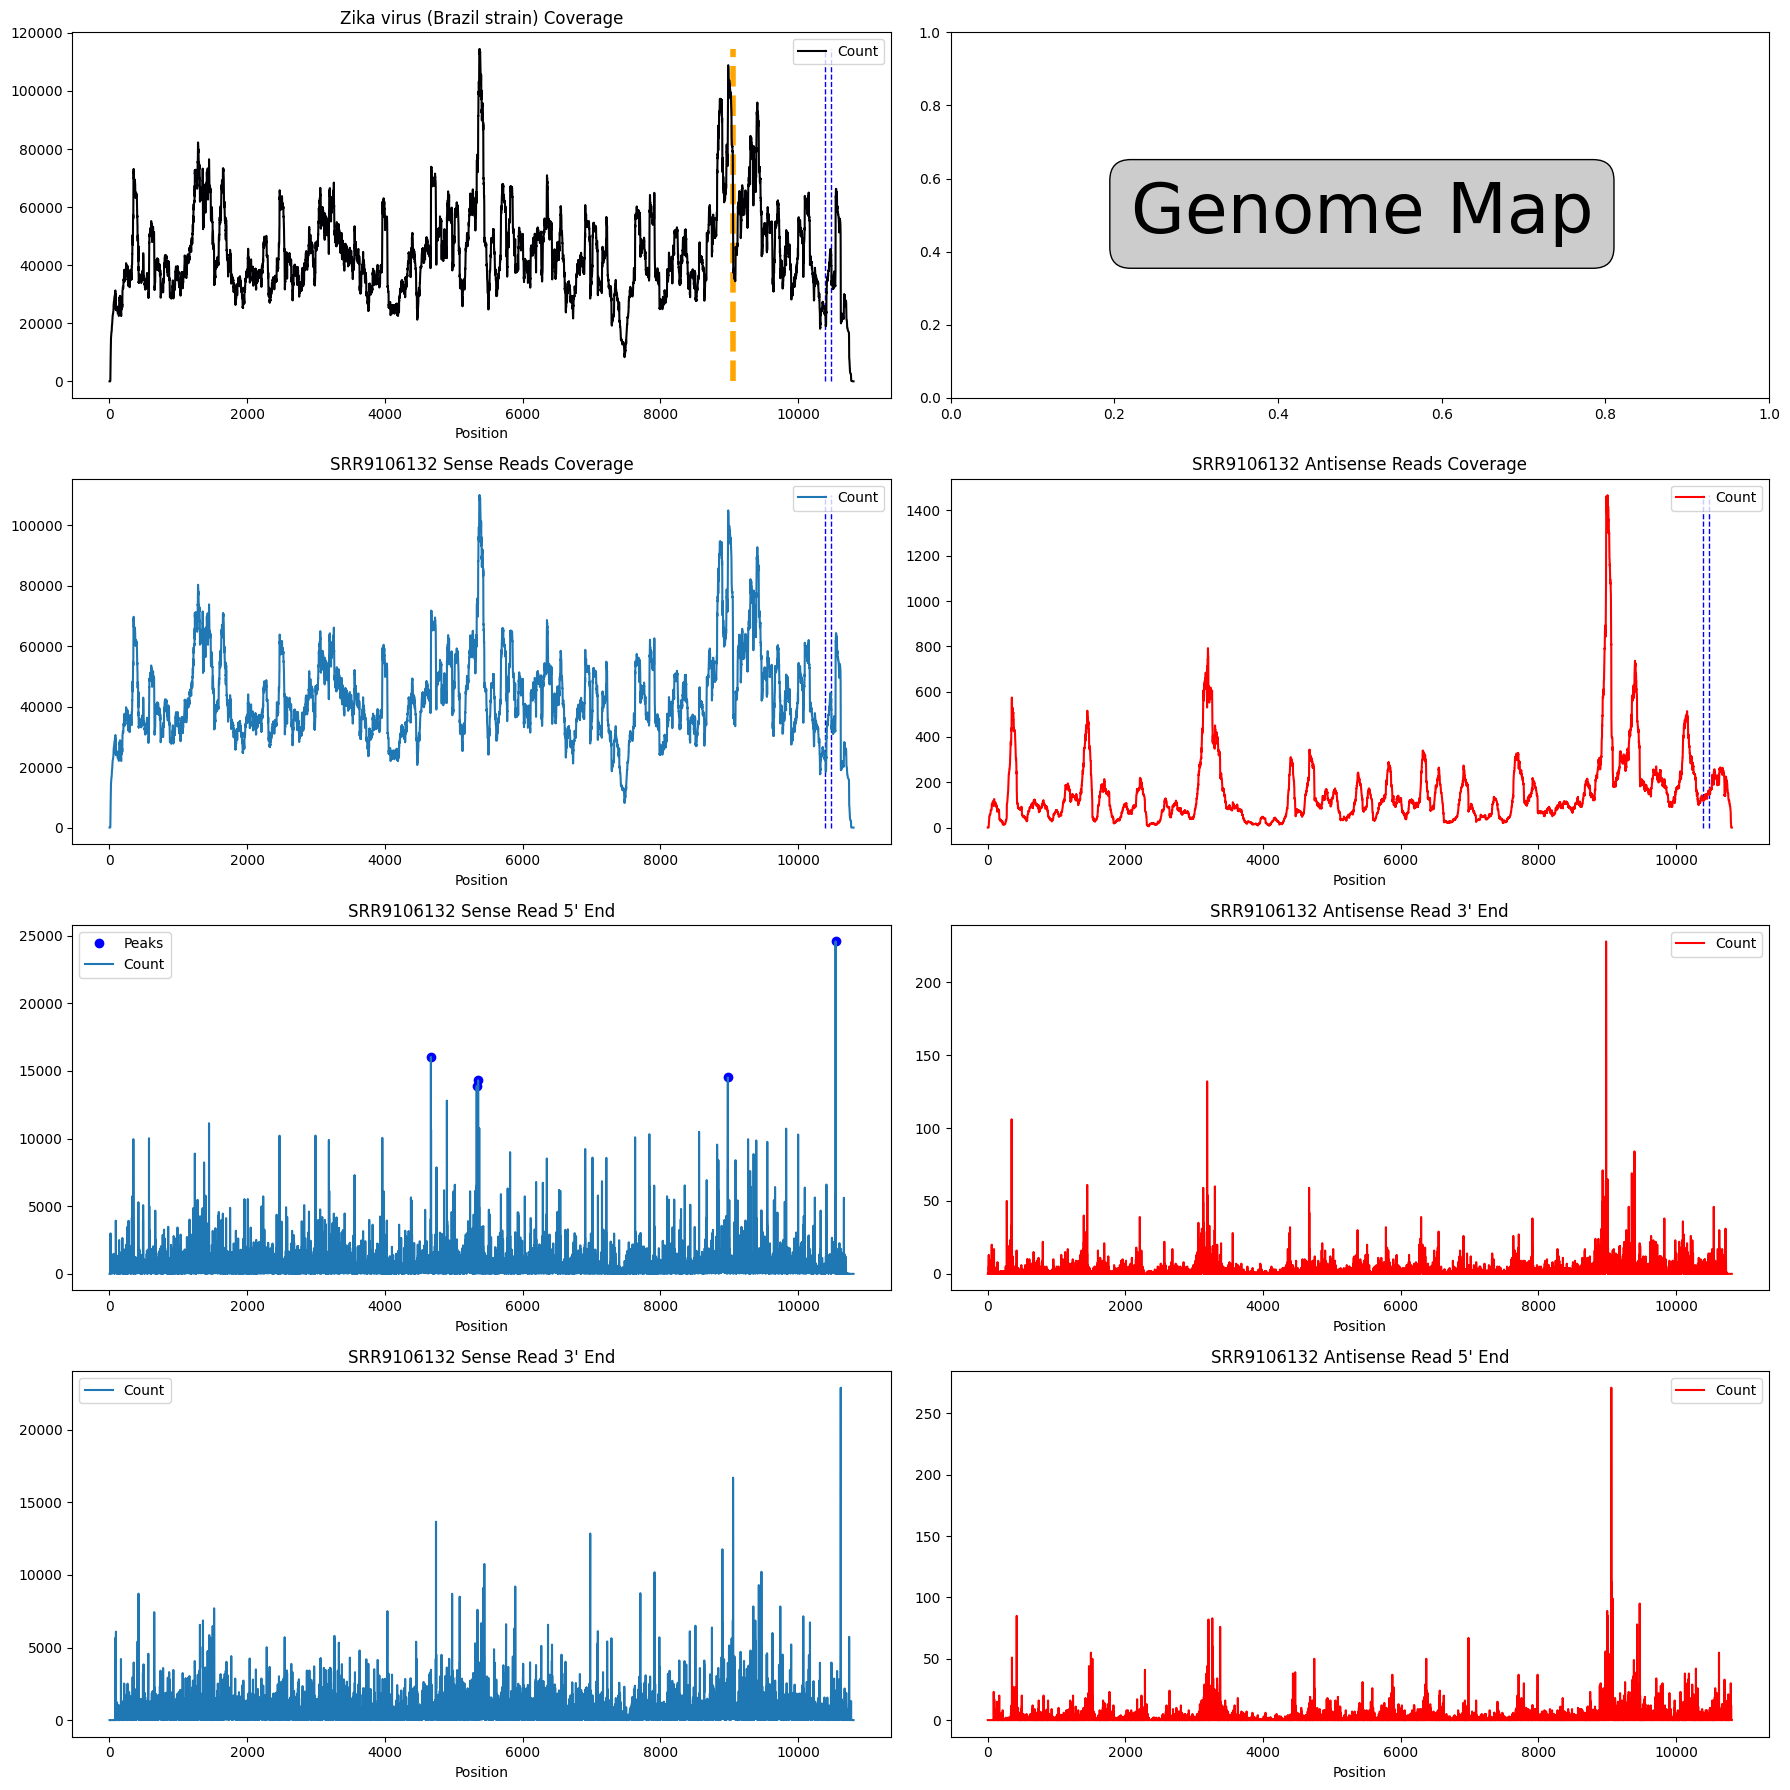

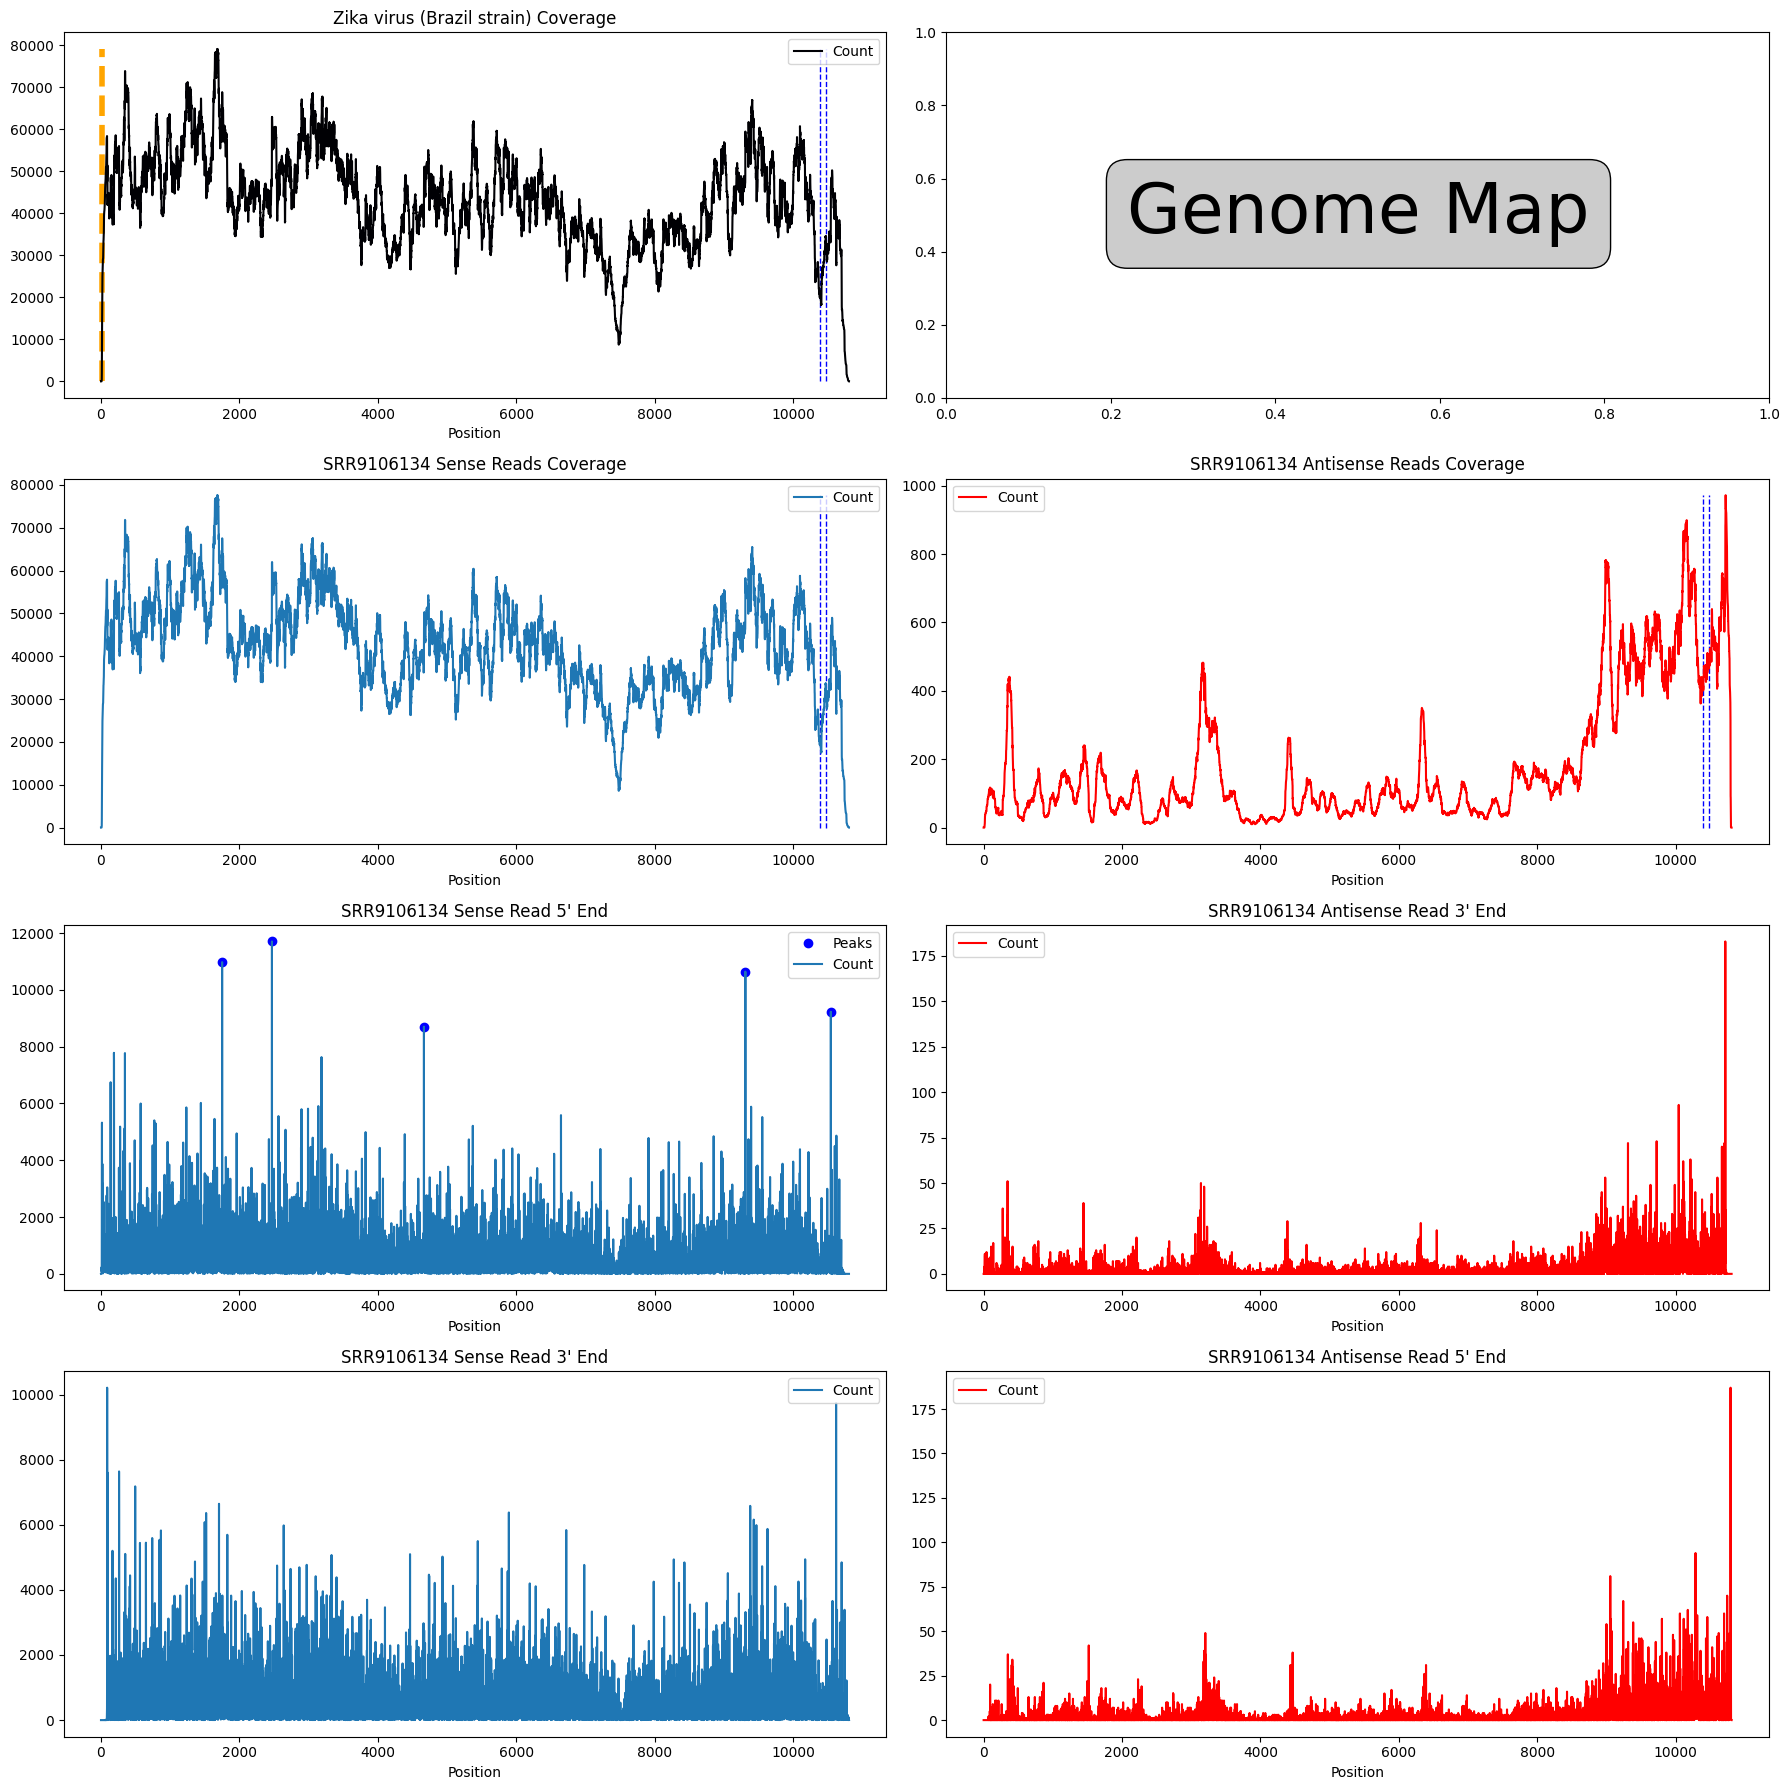

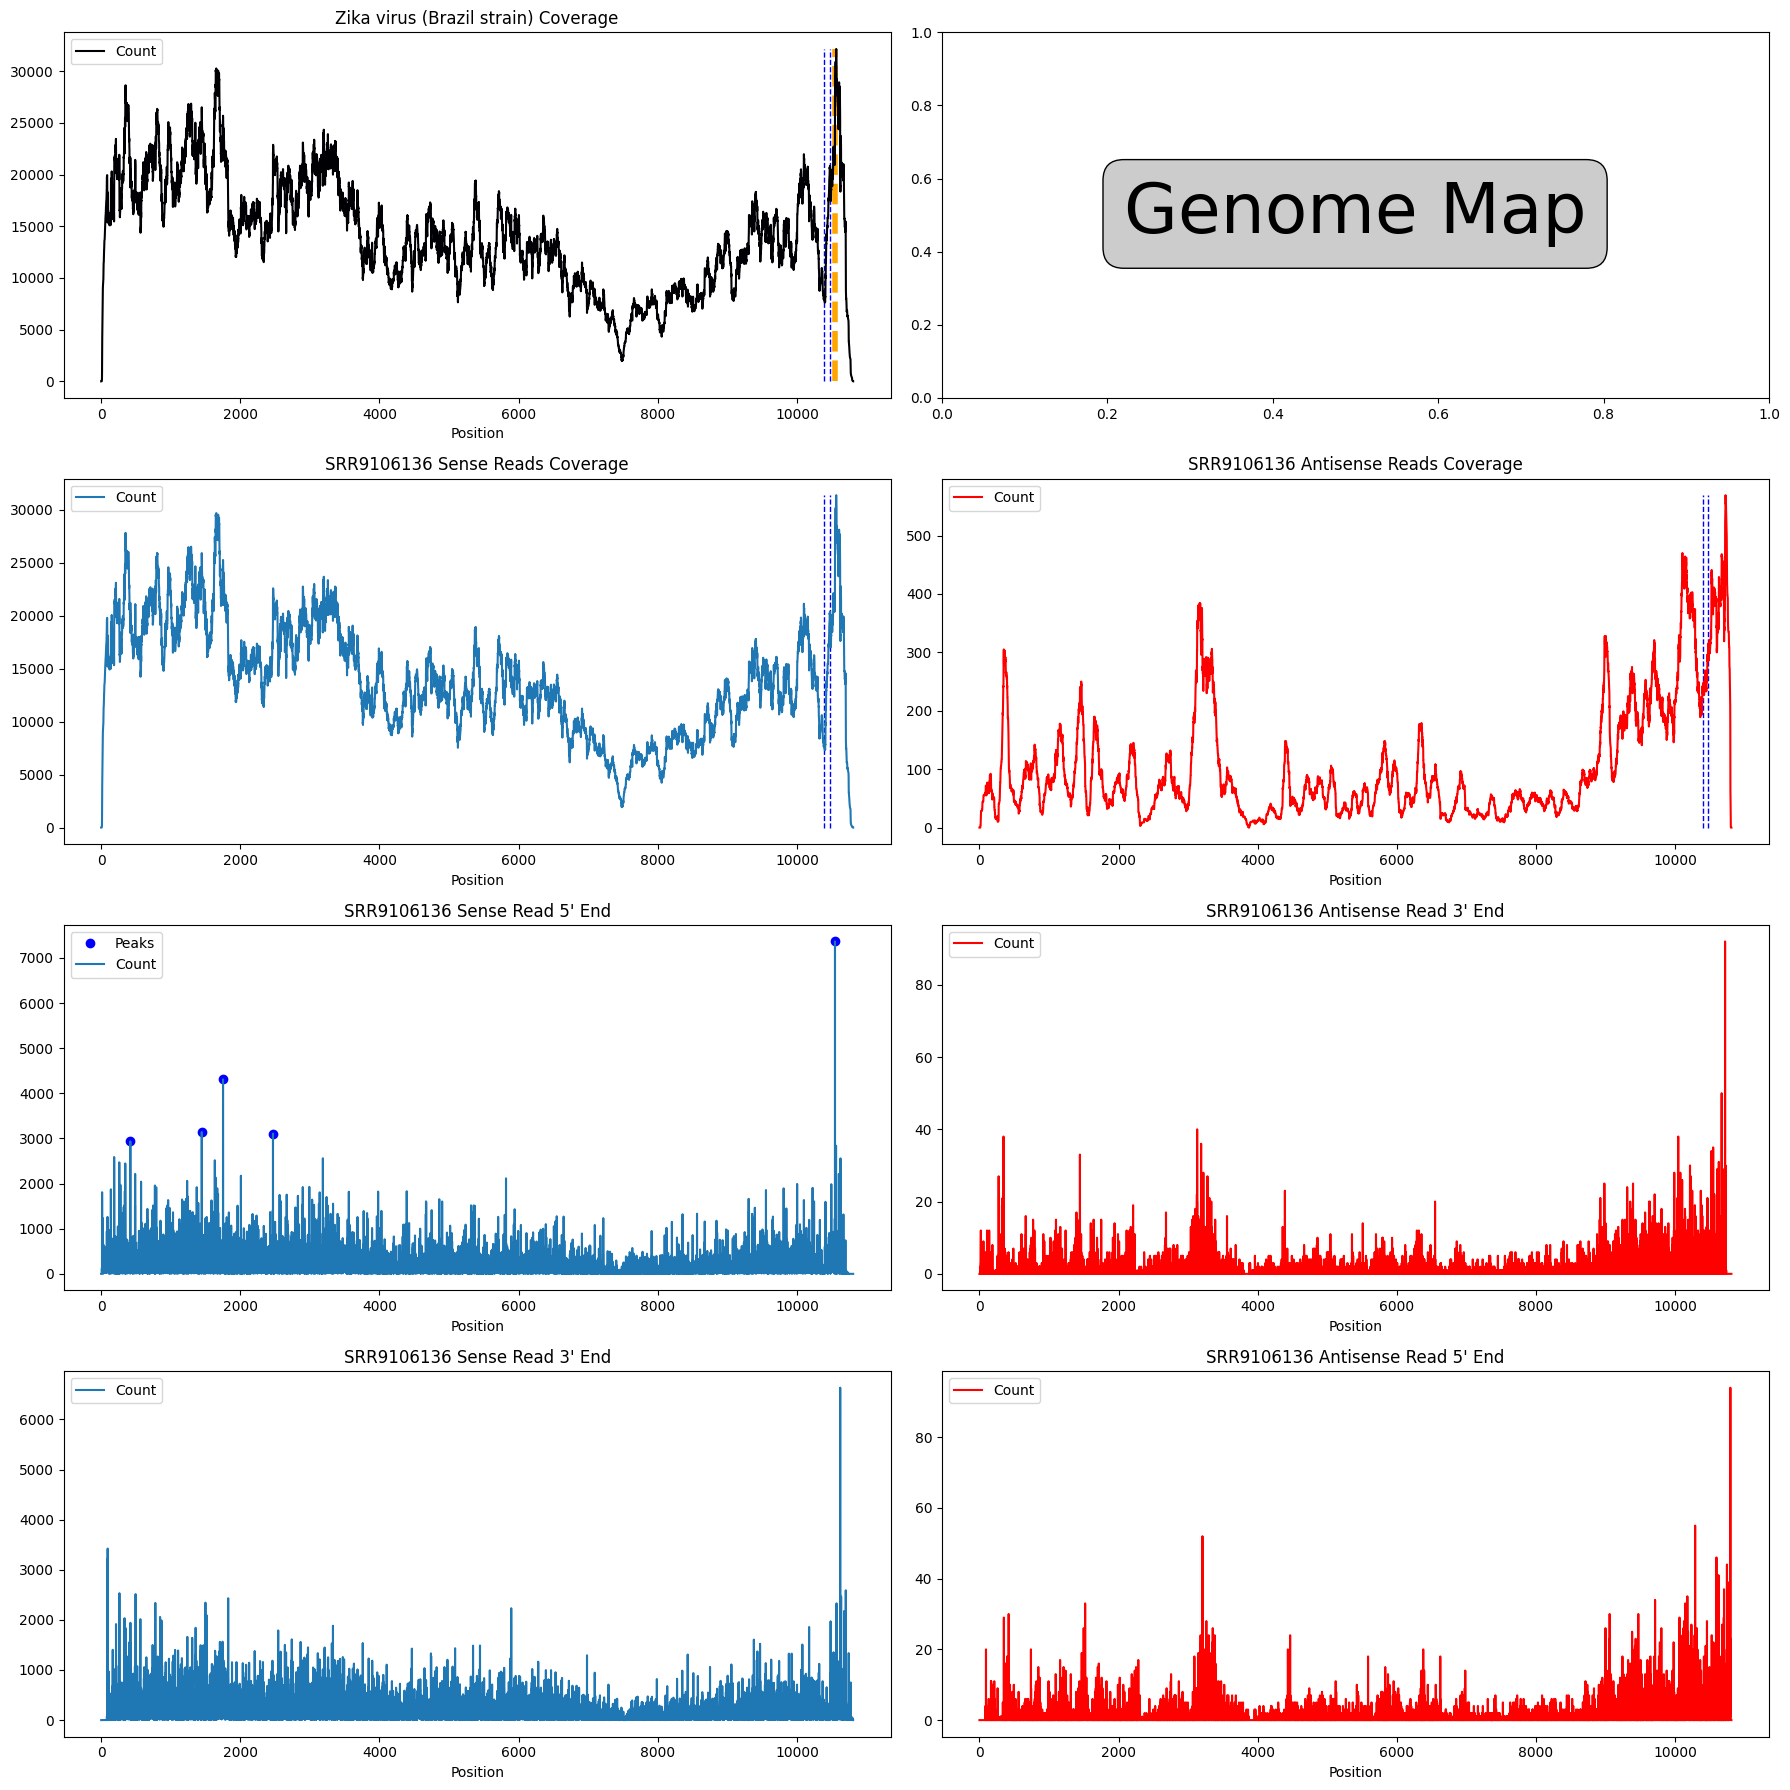

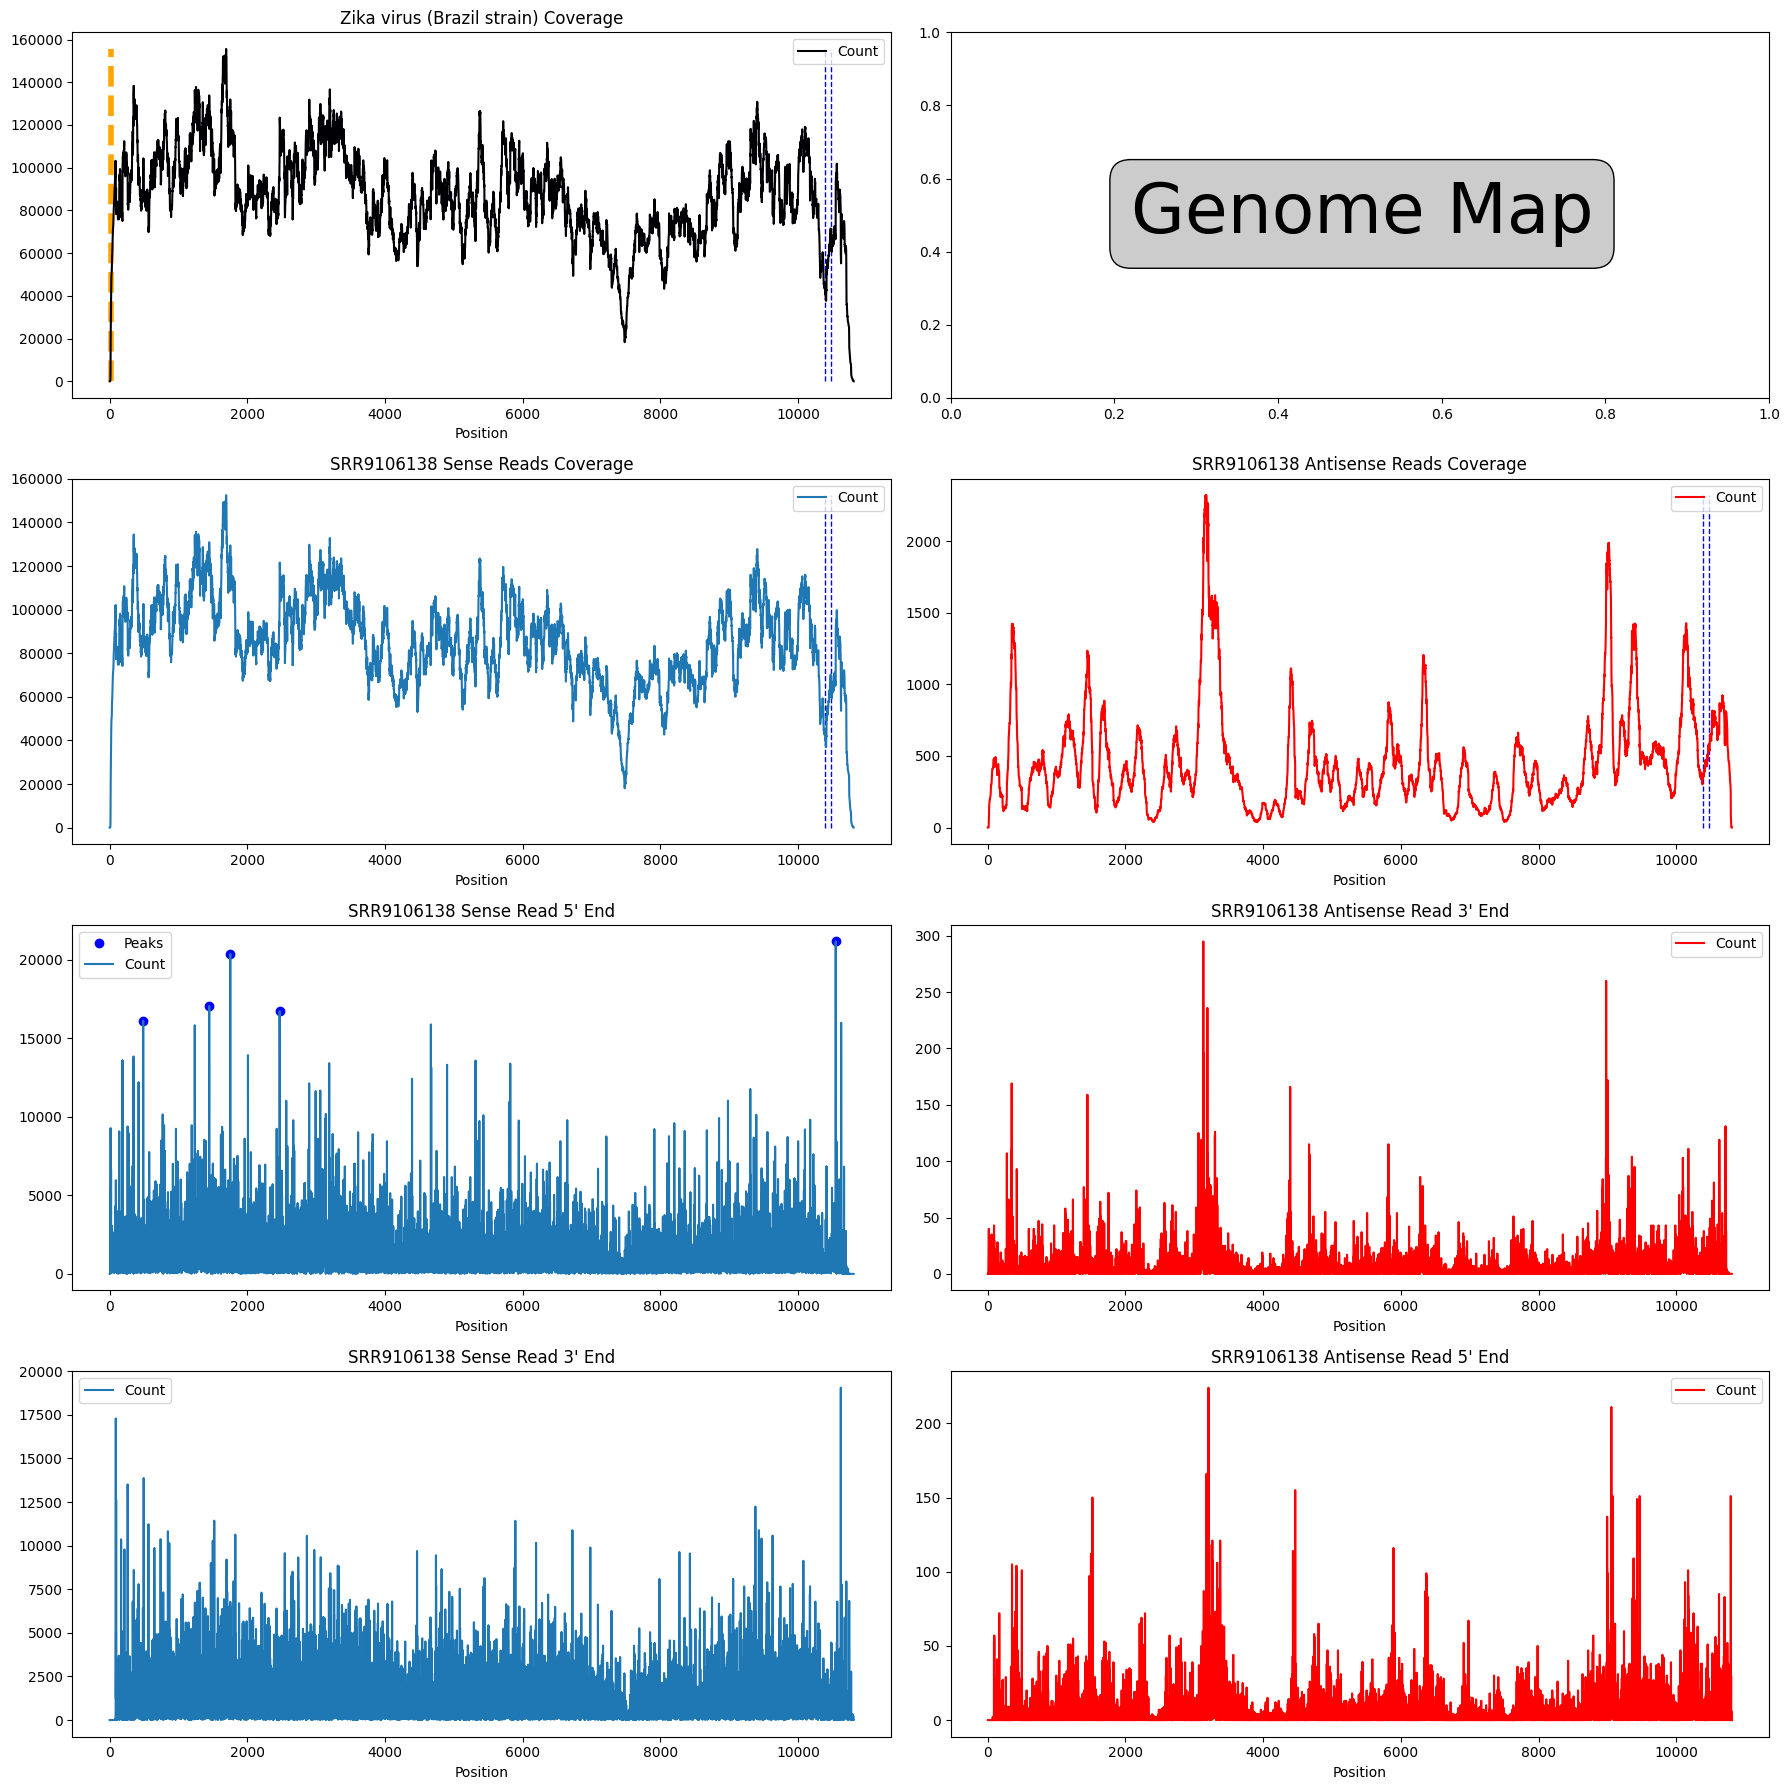

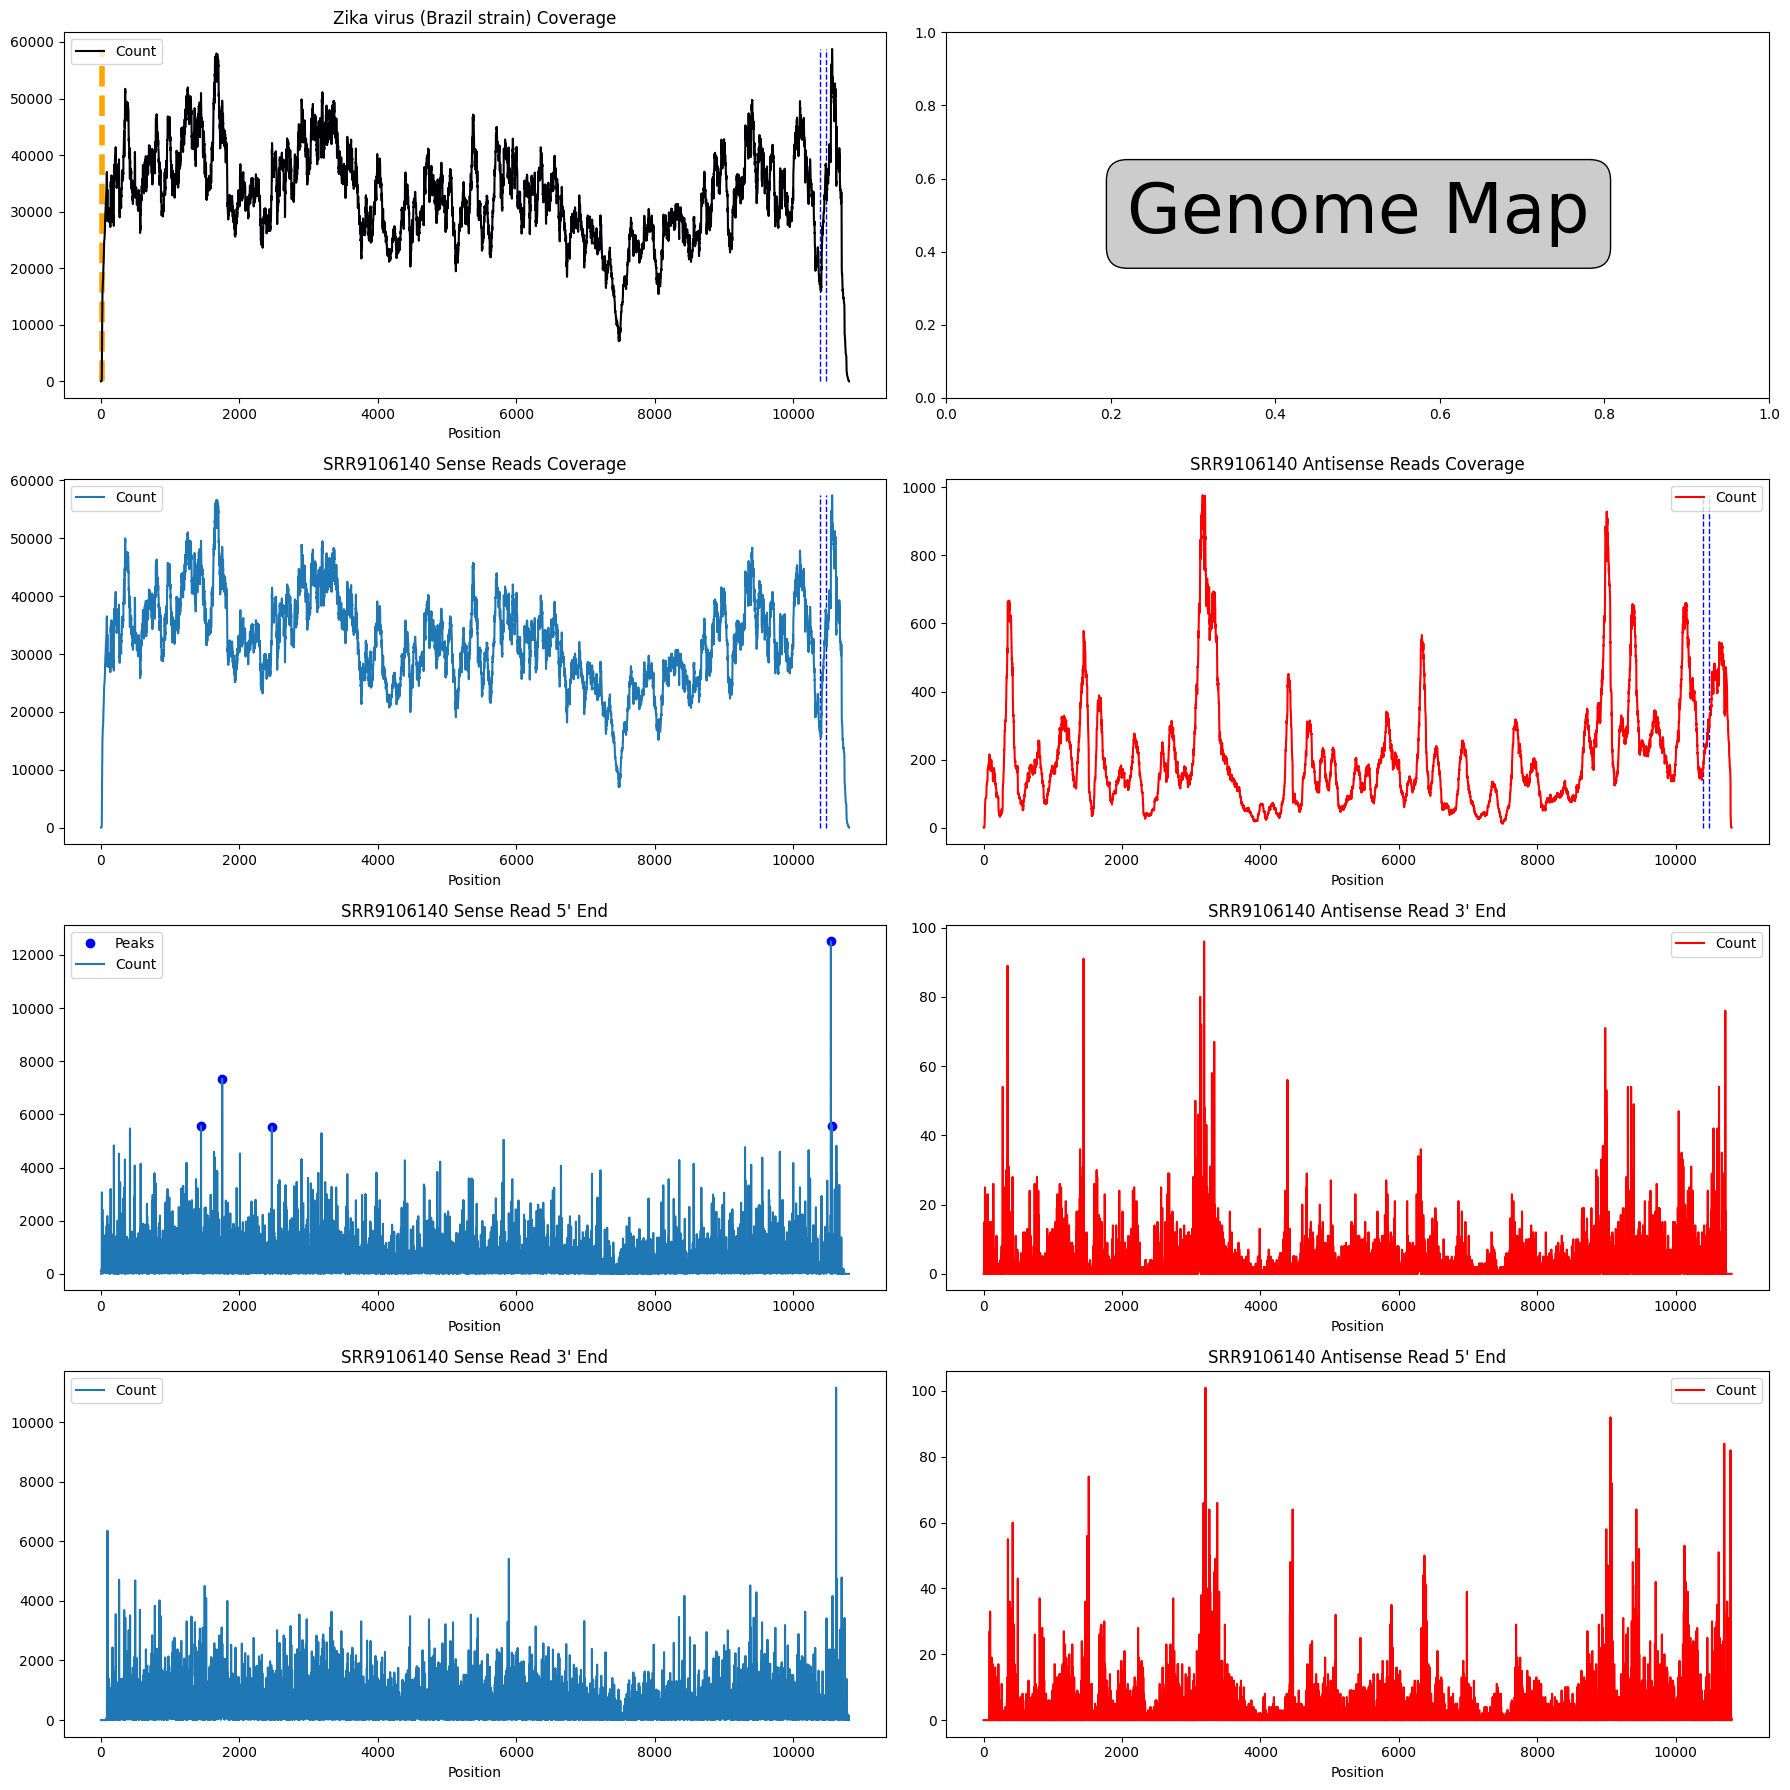

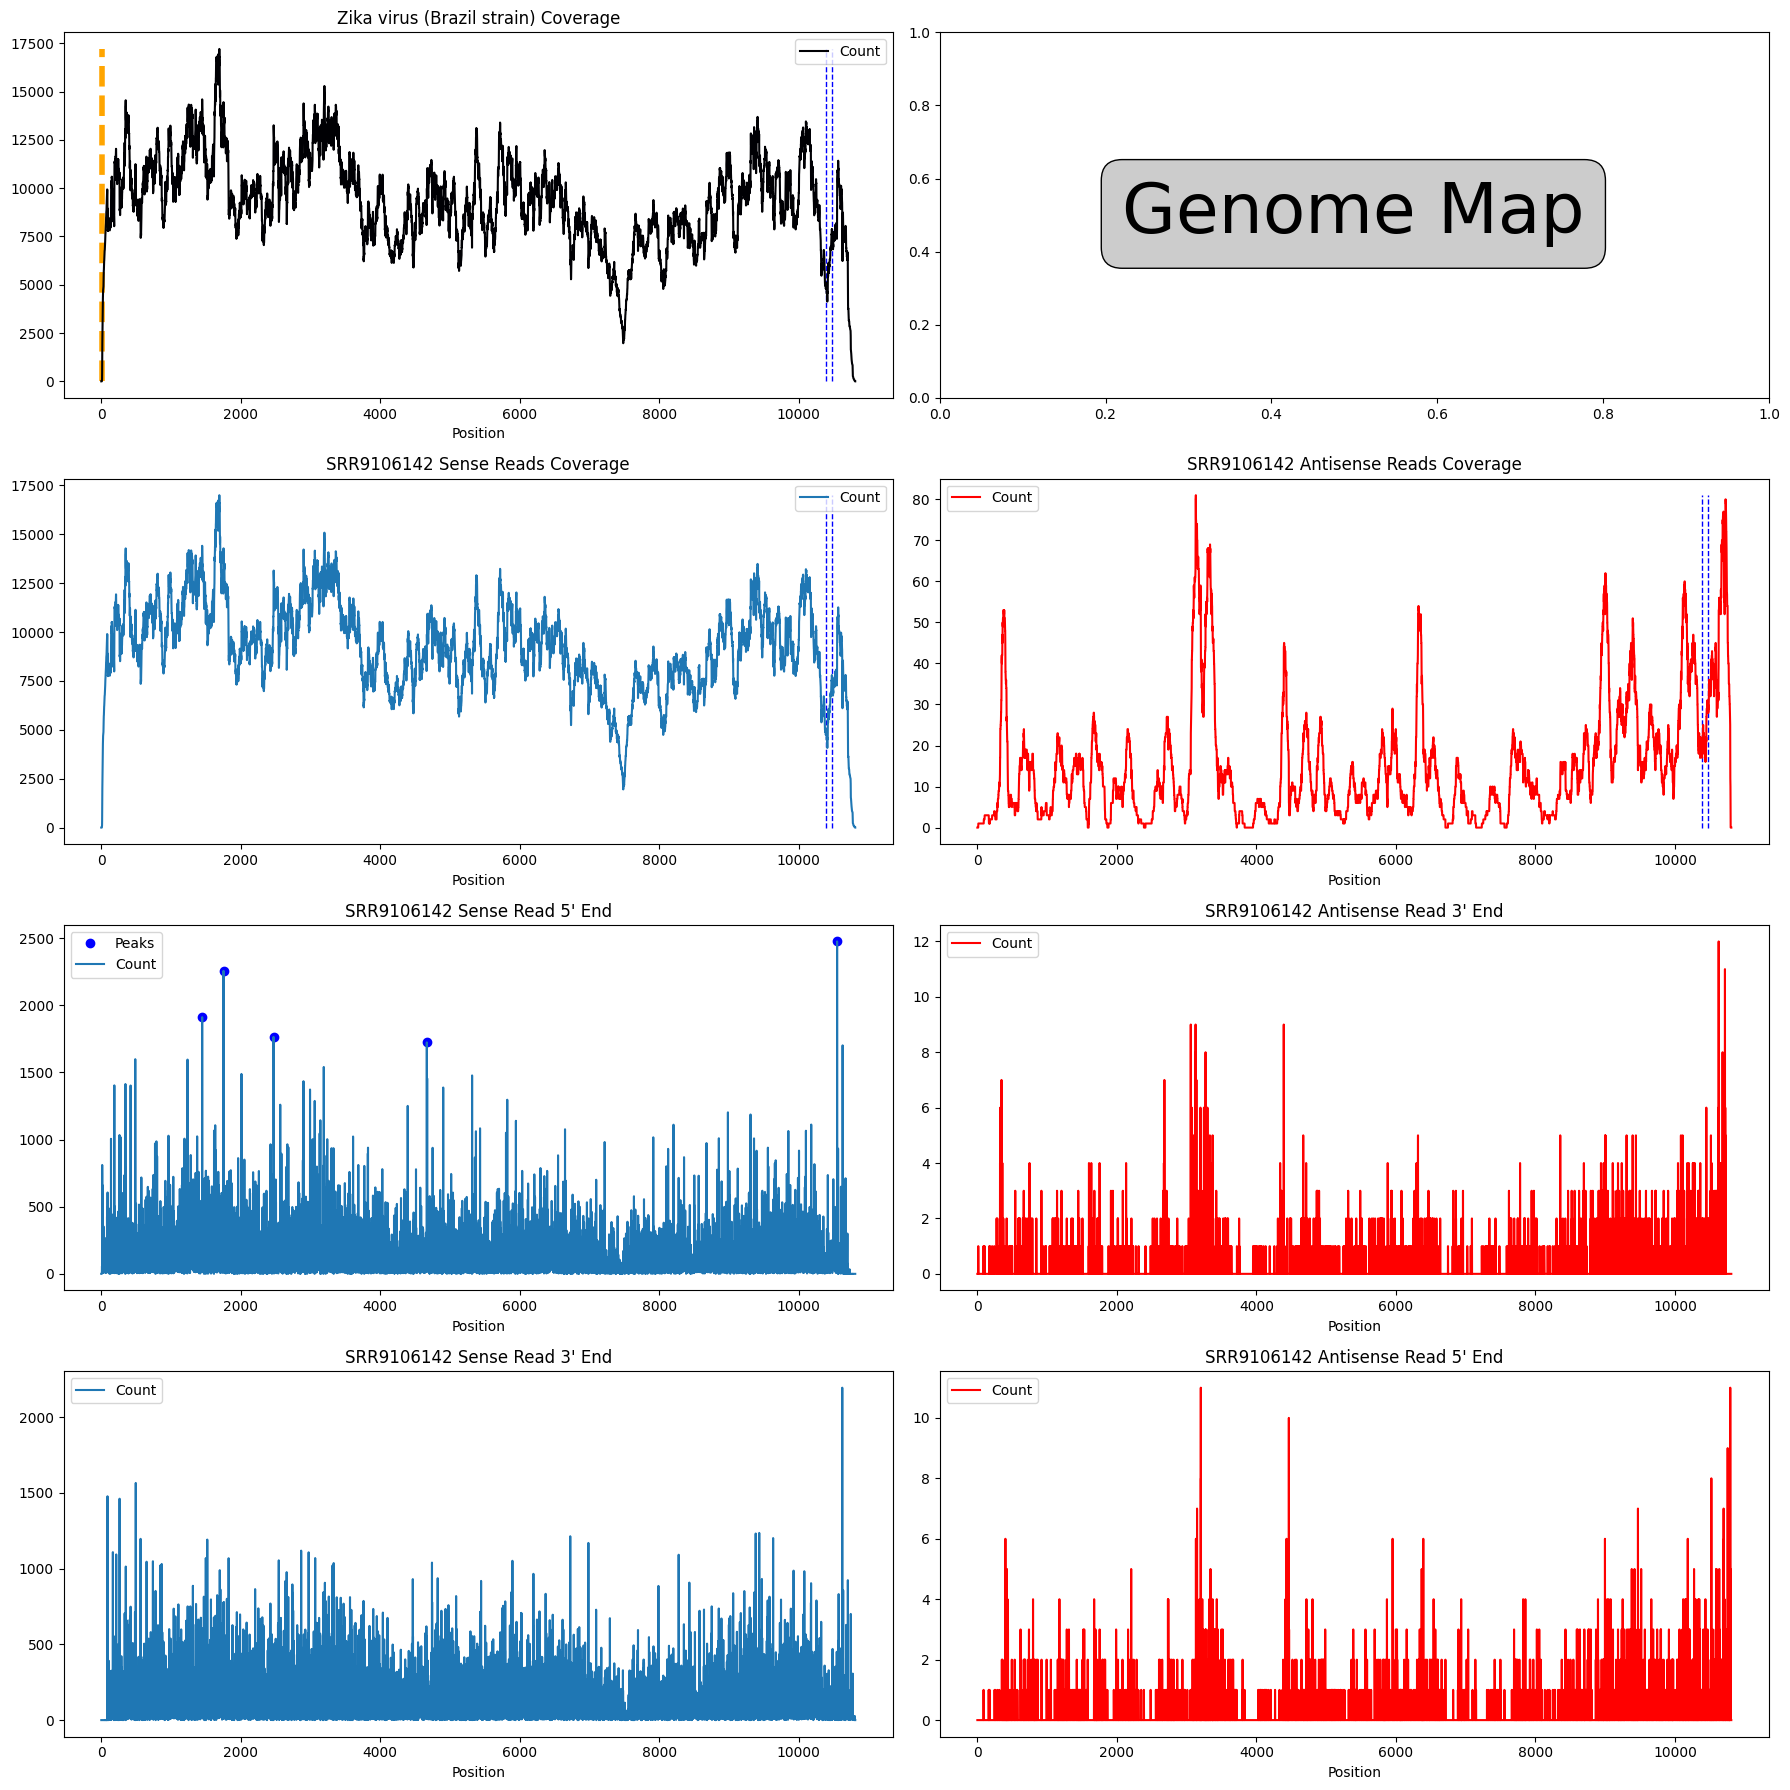

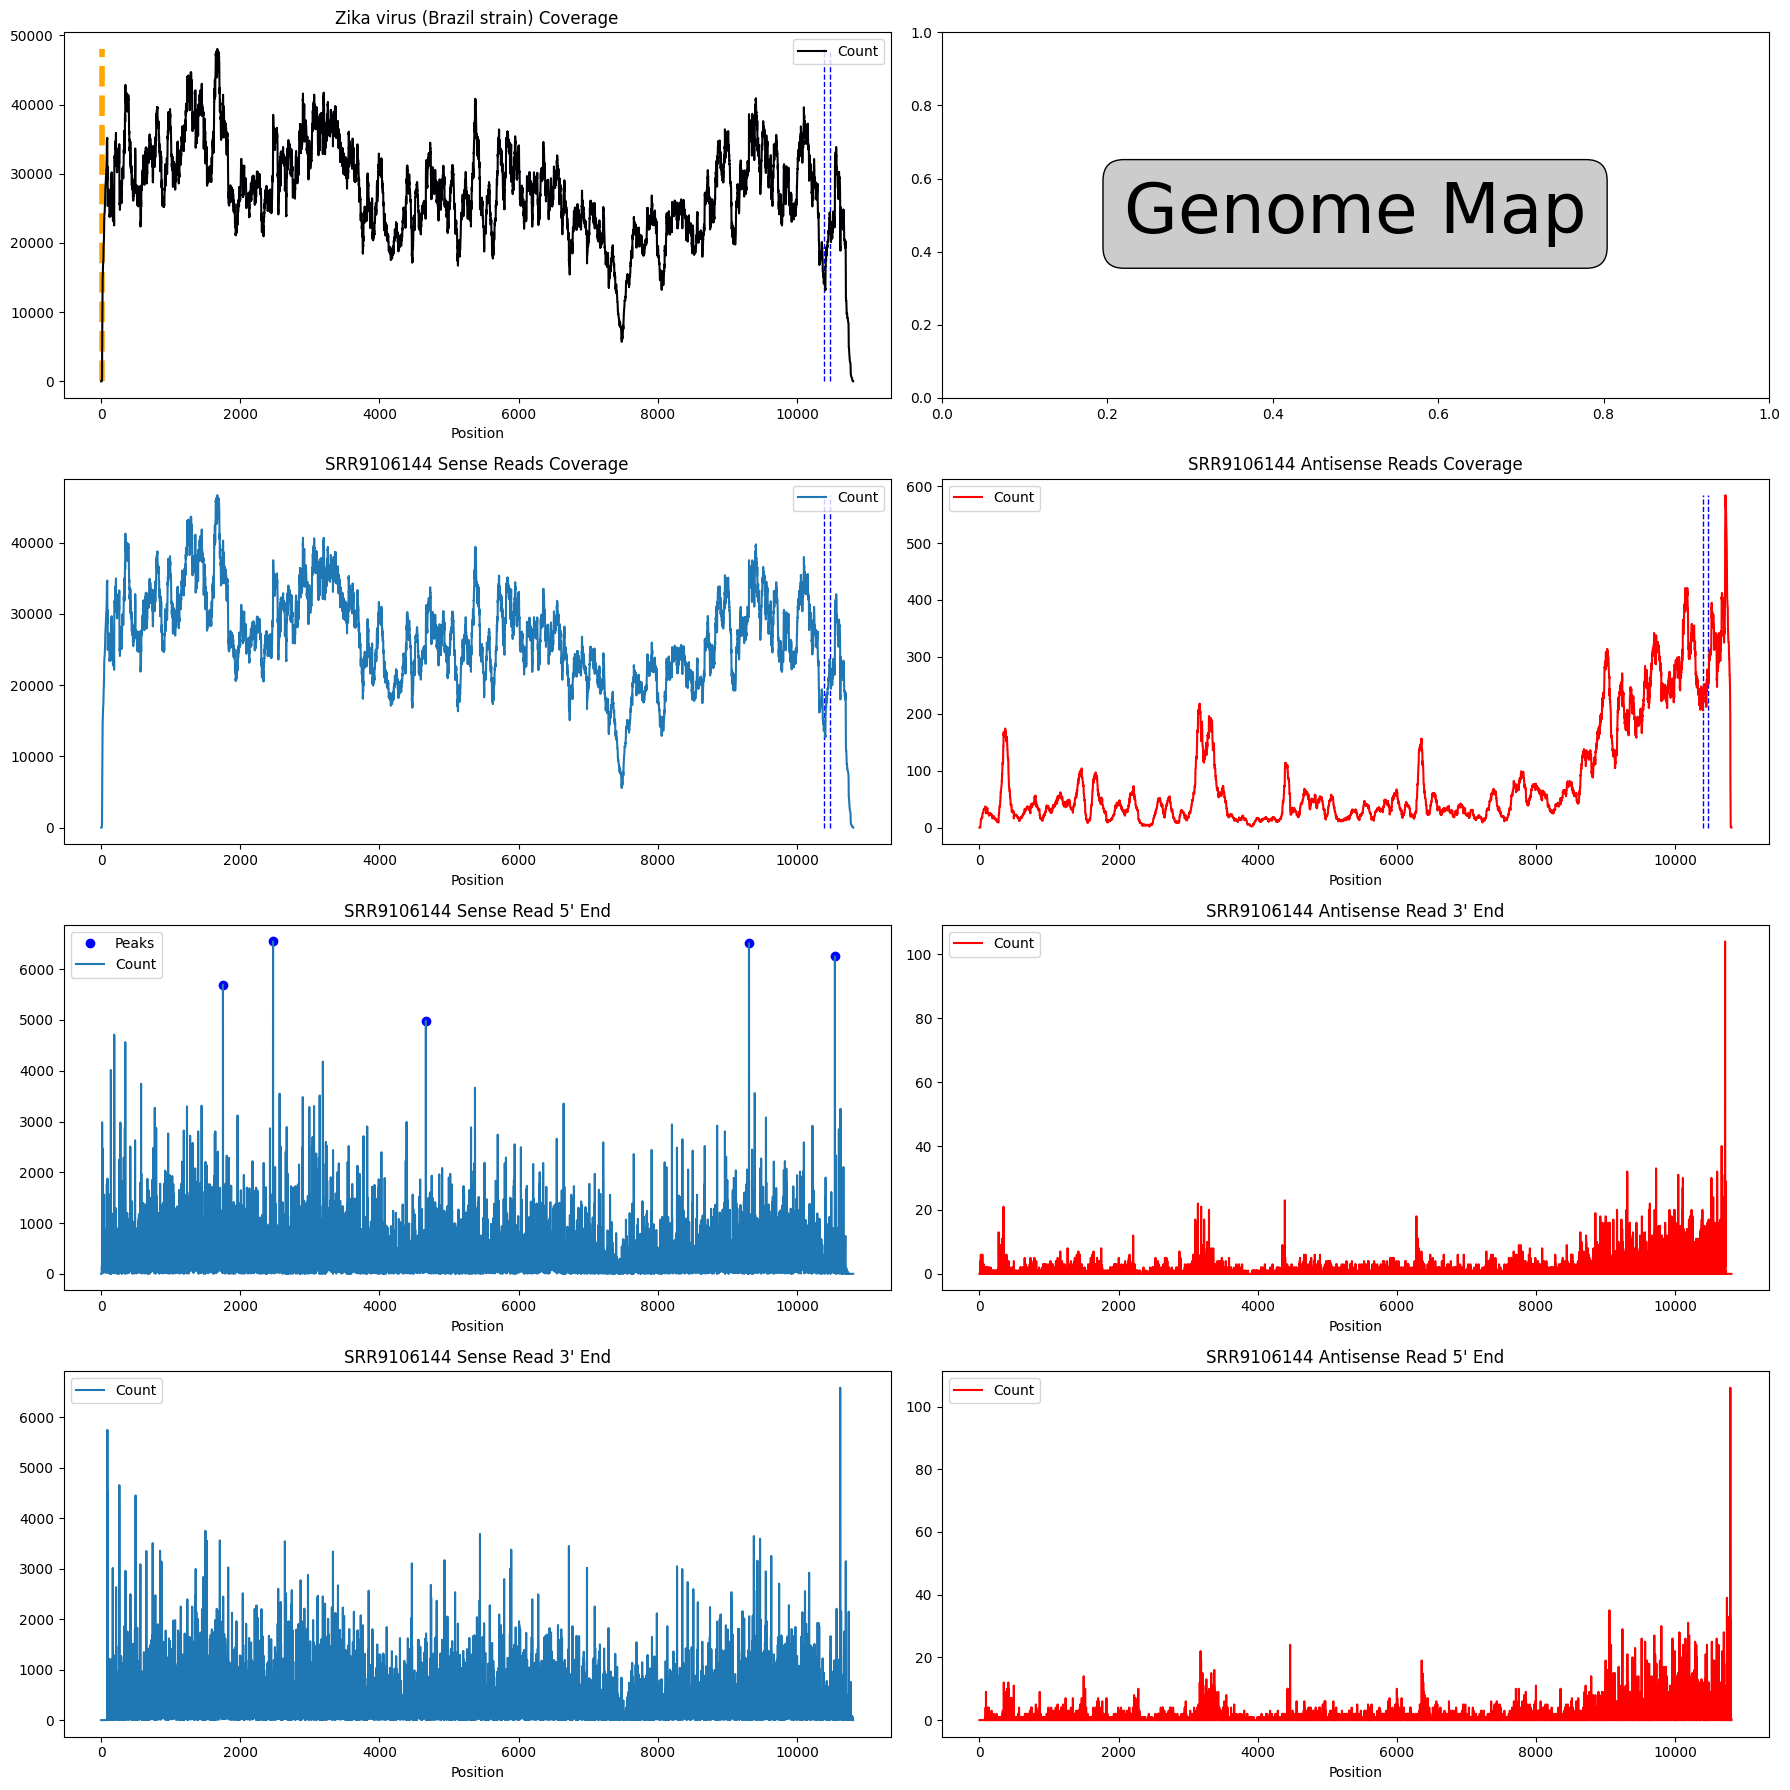

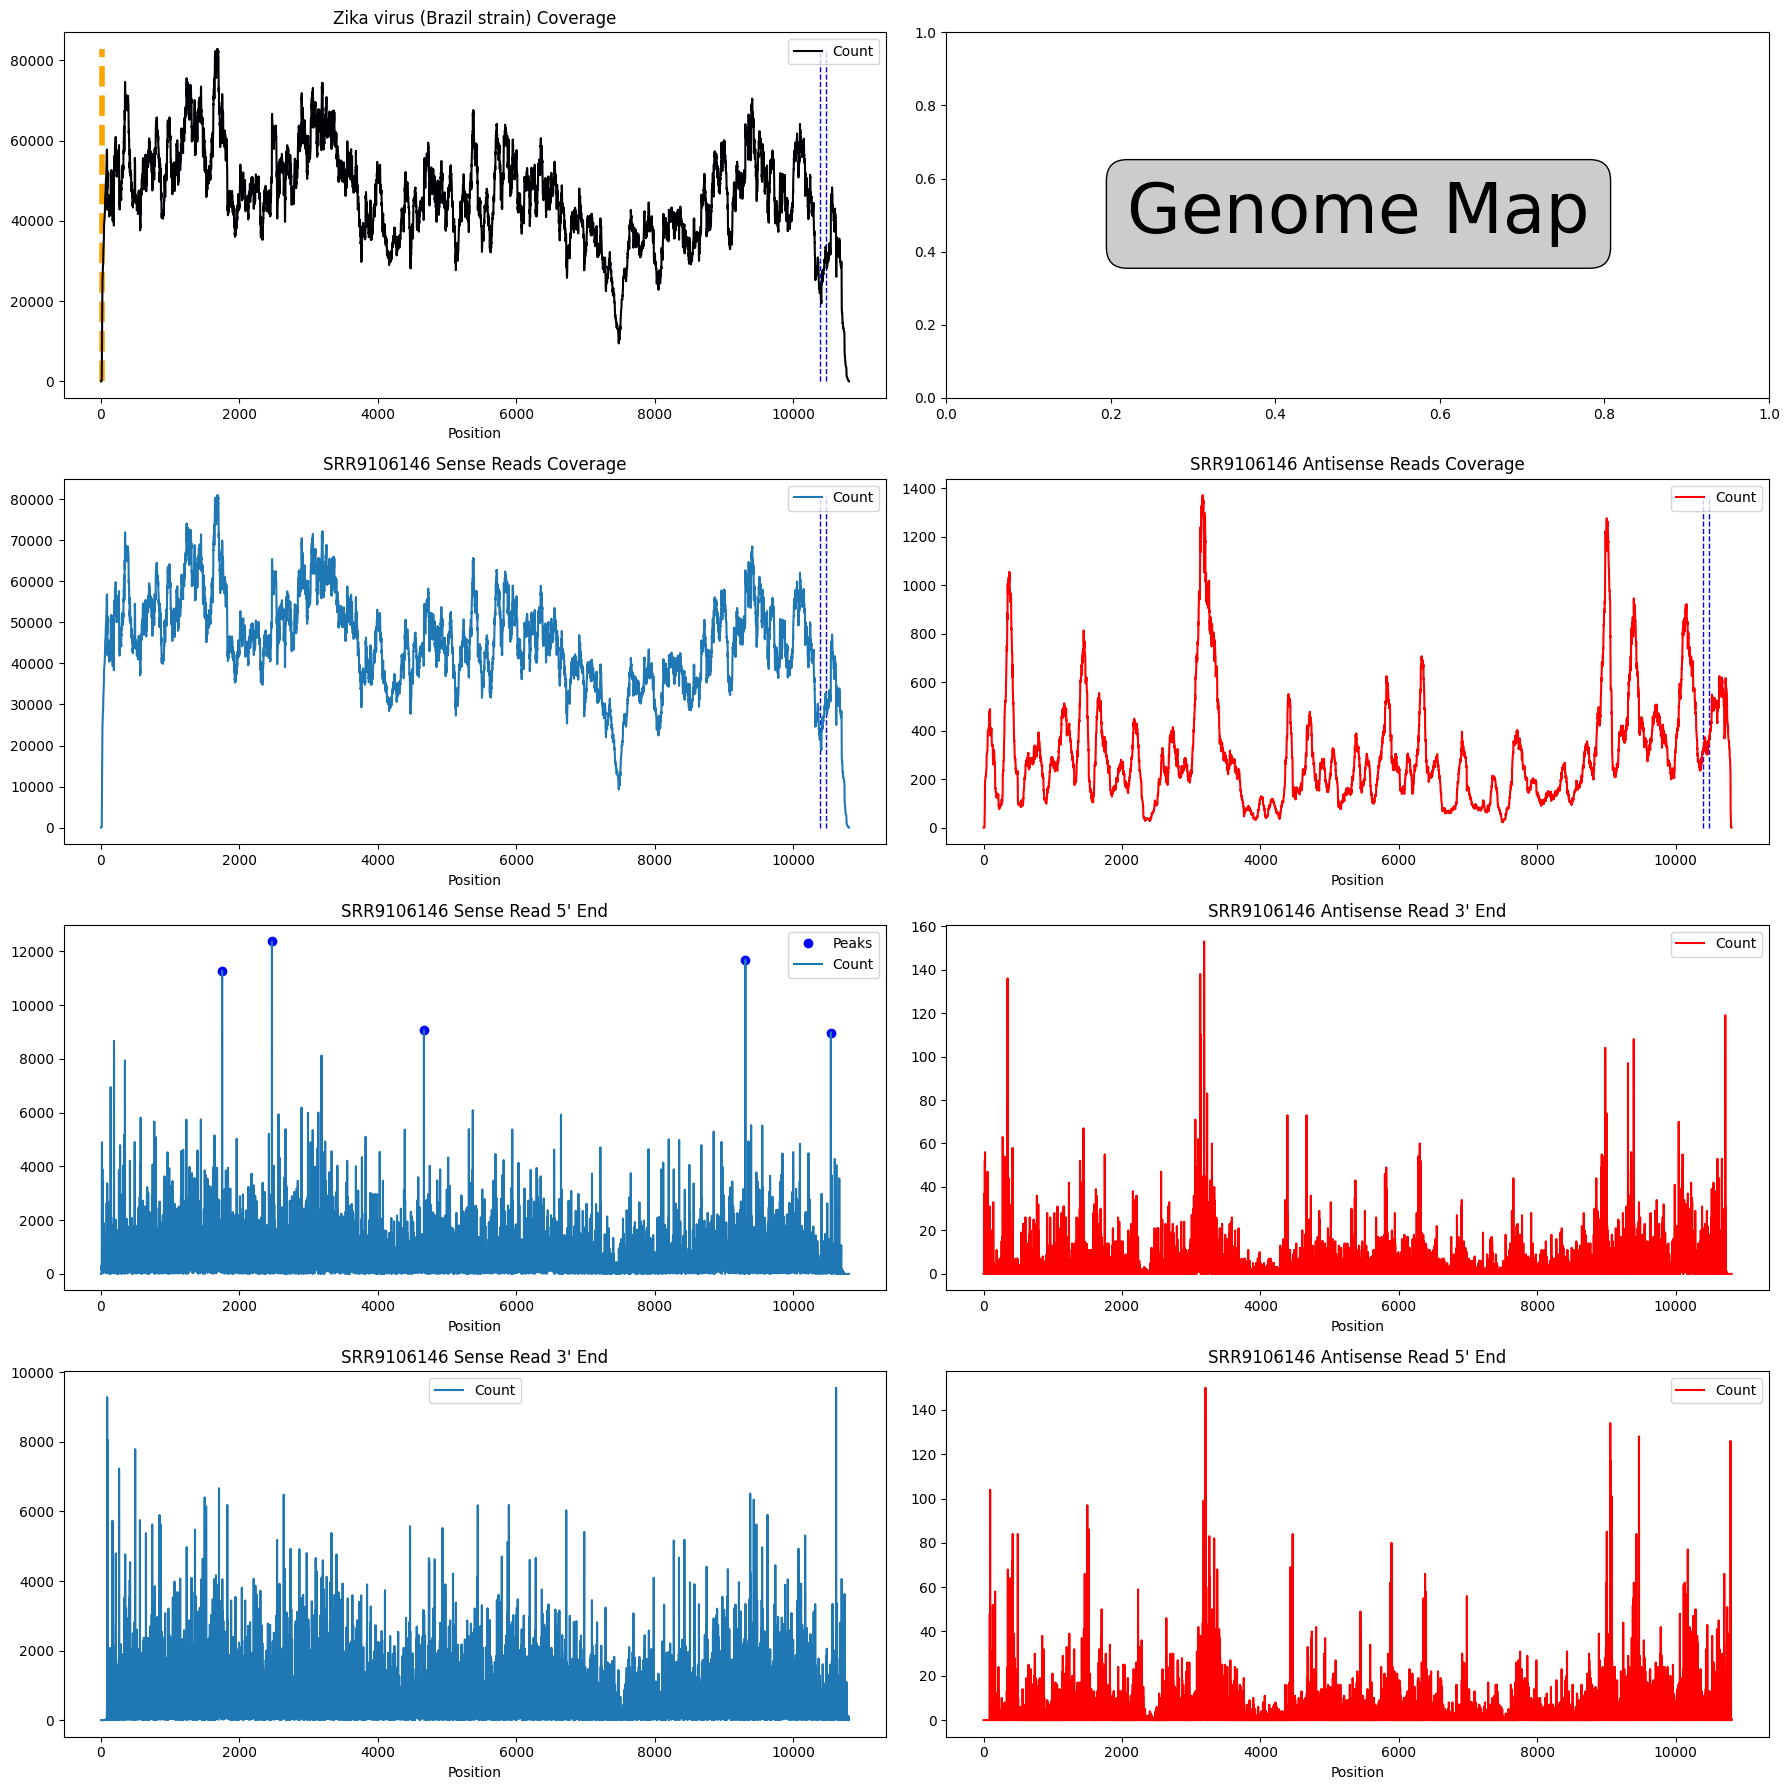

In [26]:
for acc in acc_list:
    
    original_depth = pd.read_csv("original_depth/" + acc + ".tsv", sep="\t", names=["Virus", "Position", "Count"])
    positive_depth = pd.read_csv("positive_depth/" + acc + ".tsv", sep="\t", names=["Virus", "Position", "Count"])
    negative_depth = pd.read_csv("negative_depth/" + acc + ".tsv", sep="\t", names=["Virus", "Position", "Count"])
    positive_start = pd.read_csv("positive_start/" + acc + ".tsv", sep="\t", names=["Position", "Count"])
    negative_start = pd.read_csv("negative_start/" + acc + ".tsv", sep="\t", names=["Position", "Count"])
    positive_end = pd.read_csv("positive_end/" + acc + ".tsv", sep="\t", names=["Position", "Count"])
    negative_end = pd.read_csv("negative_end/" + acc + ".tsv", sep="\t", names=["Position", "Count"])

    #5' start peak detection
    positive_start2 = pd.read_csv("positive_start/" + acc + ".tsv", sep="\t", names=["Position", "Count"])
    positive_start2 = positive_start2.sort_values(by=['Count'],ascending=False)
    top5peaks = positive_start2.head(5)
    top5peaks = top5peaks.to_numpy()


    #Read coverage Change Point Detection
    depth = pd.read_csv("positive_depth/" + acc + ".tsv", sep="\t", names=["Virus", "Position", "Count"])
    depth = depth.drop(columns=["Virus"])
    depth.set_index("Position", inplace=True)

    coverage = depth['Count'].values.reshape(-1,1)
    algo = rpt.Window(model="l2",width=30)
    algo.fit(coverage)
    result = algo.predict(n_bkps=1)
    
    
    # Create a list of the dataframes for easy iteration
    dataframes = [original_depth, positive_depth, negative_depth, positive_start, negative_start, positive_end, negative_end]
    titles = ["Zika virus (Brazil strain) Coverage", acc + " Sense Reads Coverage",acc + " Antisense Reads Coverage",
              acc + " Sense Read 5\' End",acc + " Antisense Read 3\' End", acc + " Sense Read 3\' End", acc + " Antisense Read 5\' End"]
    colours = ["magma",None, "autumn",None,"autumn",None, "autumn"]
    
    
    
    # Create subplots: 4 rows and 2 columns, but only using the first slot for a single graph
    fig = plt.figure()
    axs = []
    gs = gridspec.GridSpec(4, 2)
    axs.append(plt.subplot(gs[0, 0]))
    axs.append(plt.subplot(gs[1, 0]))
    axs.append(plt.subplot(gs[1, 1]))
    axs.append(plt.subplot(gs[2, 0]))
    axs.append(plt.subplot(gs[2, 1]))
    axs.append(plt.subplot(gs[3, 0]))
    axs.append(plt.subplot(gs[3, 1]))
    axs.append(plt.subplot(gs[0, 1]))
    
    # Plot each DataFrame on its corresponding subplot
    for i, df in enumerate(dataframes):
        ax = axs[i]
        if i==3:
            ax.plot(top5peaks[0][0],top5peaks[0][1], "ob")
            ax.plot(top5peaks[1][0],top5peaks[1][1], "ob")
            ax.plot(top5peaks[2][0],top5peaks[2][1], "ob")
            ax.plot(top5peaks[3][0],top5peaks[3][1], "ob")
            ax.plot(top5peaks[4][0],top5peaks[4][1], "ob")
            ax.legend(['Peaks'])
        if i==0:
            ax.vlines(result[0],ymin=0,ymax=df['Count'].max(), color='orange', linestyles='dashed', linewidth = 4)

        if i==0 or i==1 or i==2:
            # predicted 5′ end of RNA “stem-loop 2” (SL2)
            ax.vlines(10478,ymin=0,ymax=df['Count'].max(), color='blue', linestyles='dashed', linewidth = 1)

            # predicted 5′ end of RNA “stem-loop 1” (SL1)
            ax.vlines(10394,ymin=0,ymax=df['Count'].max(), color='blue', linestyles='dashed', linewidth = 1)
            

            #position from Andrew's paper: https://www.biorxiv.org/content/10.1101/112904v1.full
            
        df.plot("Position", "Count", ax=ax, colormap=colours[i], figsize=(18, 18))
        ax.set_title(titles[i])

    axs[7].annotate("Genome Map", (0.22,0.45), fontsize=50, bbox=dict(boxstyle="round", fc="0.8"))
    
    # Adjust layout for better spacing
    plt.tight_layout()
    
    # Show the plot
    plt.show()
    fig.savefig('/mnt/Zika_round4/final_plots/' + acc + '.png')